In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
#!cp "/content/drive/My Drive/Colab Notebooks/attention_keras/src/layers/attention.py" .

In [4]:
import attention

AttentionLayer was taken from here https://github.com/thushv89/attention_keras

In [5]:
from attention import AttentionLayer

In [6]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from os import listdir

In [7]:
import tensorflow as tf
tf.__version__

'2.3.0'

#Read the dataset

CNN daily mail dataset consists of long news articles(an average of ~800 words). It consists of both articles and summaries of those articles.

In [8]:
import zipfile
import os

In [9]:
zpfile = '/content/drive/My Drive/Colab Notebooks/cnn_stories.zip'
z = zipfile.ZipFile(zpfile, 'r')
z.extractall()

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only

	file = open(filename, encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights
 
# load all stories in a directory
def load_stories(directory):
	stories = list()
	for name in listdir(directory):
		filename = directory + '/' + name
		# load document
		doc = load_doc(filename)
		# split into story and highlights
		story, highlights = split_story(doc)
		# store
		stories.append({'story':story, 'highlights':highlights})
	return stories
 
# load stories
directory = 'cnn_stories/cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [ ]:
zpfile_1 = '/content/drive/My Drive/Colab Notebooks/dailymail_stories.zip'
z = zipfile.ZipFile(zpfile_1, 'r')
z.extractall()

In [ ]:
directory = 'dailymail_stories/dailymail/stories/'
stories_dailymail = load_stories(directory)
print('Loaded Stories %d' % len(stories_dailymail))

Loaded Stories 219506


In [ ]:
import string


# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	# prepare a translation table to remove punctuation
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# strip source cnn office if it exists
		index = line.find('(CNN) -- ')
		if index > -1:
			line = line[index+len('(CNN)'):]
		# tokenize on white space
		line = line.split()
		# convert to lower case
		line = [word.lower() for word in line]
		# remove punctuation from each token
		line = [w.translate(table) for w in line]
		# remove tokens with numbers in them
		line = [word for word in line if word.isalpha()]
		# store as string
		cleaned.append(' '.join(line))
	# remove empty strings
	cleaned = [c for c in cleaned if len(c) > 0]
	return cleaned

# clean stories
for example in stories:
	example['story'] = clean_lines(example['story'].split('\n'))
	example['highlights'] = clean_lines(example['highlights'])

In [ ]:
data_cnn= pd.DataFrame(stories)

In [ ]:
# clean stories
for example in stories_dailymail:
	example['story'] = clean_lines(example['story'].split('\n'))
	example['highlights'] = clean_lines(example['highlights'])

In [ ]:
data_dailymail= pd.DataFrame(stories_dailymail)

In [ ]:
data_dailymail.head()

,story,highlights
0,"[a former gymnast who represented her country numerous times and won medals for her skills has now been exposed as a highclass prostitute who earns a night, florica leonida from the romanian capit...","[florica leonida from bucharest is a former silver world medallist, but she said becoming a prostitute was the only way to make ends meet, she works under a different name currently residing in a ..."
1,"[by, daily mail reporter, published, est april, updated, est september, a champion swimmer spied on a woman using a pair of mirrored goggles to peek under a changing room cubicle a court heard fre...","[married james mackay used goggles to watch same woman in cubicle three times, he set the british freestyle record in, update since publication of this article mr mackay successfully appealed agai..."
2,"[liverpool cruised to a win over swansea to ease the pressure on brendan rodgers at anfield, alberto moreno fired the hosts ahead before a brace from adam lallana either side of gylfi sigurdssons ...","[former southampton midfielder adam lallana scored a brace in win, jonjo shelvey who used to play for liverpool endured a miserable game, the win pushes liverpool level on points but above swansea..."
3,"[by, daily mail reporter, published, est december, updated, est december, anderson cooper shocked viewers on thursday night by discussing his mother and oral sex in one outrageous anecdote, the cn...",[the cnn anchor was hosting his review of the year show when he made the shocking remark]
4,"[wasps fans have been told to accept the reality of professional sport following the watershed purchase of ricoh arena in a move which paves the way for nflstyle franchises in rugby union, the two...","[wasps came close to going bankrupt two years ago and confirmed on wednesday that they have agreed a deal to move to the ricoh arena, coventry city council have sold the club a per cent share in t..."


In [ ]:
data = data_cnn.append(data_dailymail, ignore_index=True)

In [ ]:
data.tail()

,story,highlights
312080,"[by, louise eccles and becky barrow, last updated at am on january, hundreds of railway staff will be paid simply for agreeing to work without disruption during the olympics, it also emerged yeste...","[workers on driverless dlr network offered per cent overtime increase during the games, union describes pay deal as truly groundbreaking, critics accuse rail bosses of bribing staff not to strike]"
312081,"[by, ellie zolfagharifard, published, est october, updated, est october, a powerful solar flare directed at earth has put on majestic display of the northern lights across parts of canada the us a...","[a solar explosion crashed into earths magnetic field on tuesday allowing photographers to capture these images, solar flares create auroras when radiation from the sun reaches earth and mixes wit..."
312082,"[by, louise saunders, published, est august, updated, est august, when the only way is essexs tom kilbey started dating lydia bright it was clear he was never going to be best pals with her exboyf...","[lucy mecklenburgh vs sam faiers, gemma collins vs charlie king and bobby cole norris, joey essex vs jamie reed]"
312083,"[by, steve doughty social affairs correspondent, fortnightly rubbish collections are a threat to public health government guidance warned yesterday, it said that no longer picking up bins from hom...","[guidance was issued yesterday by department led by eric pickles, he has pushed councils to make weekly bin collections with grant, surprise announcement puts mr pickles on collision course with d..."
312084,"[the remains of two dinosaurs that were perfectly preserved in a bitter fight to the death are to be sold for a record million, the fossil of the tyrannosaurus and a triceratops locked in mortal c...","[tyrannosaurus and triceretops were found in, perfectly preserved fossils show them embraced in a fight to the death, chance discovery is thought to be among the most important of all time, expert..."


In [ ]:
data.rename(columns={"highlights": "Summary", "story": "Text"}, inplace=True)

In [ ]:
data['Text'] = data['Text'].apply(lambda x: ' '.join(x) )

In [ ]:
for i in range(len(data['Summary'])):
  data['Summary'][i]=data['Summary'][i][0]

### Drop Duplicates and NA values

In [11]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

### Information about dataset


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308827 entries, 0 to 312084
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     308827 non-null  object
 1   Summary  308827 non-null  object
dtypes: object(2)
memory usage: 7.1+ MB


In [ ]:
data.to_csv("cnn_dailymail_before_processing_2510.csv")

In [10]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cnn_dailymail_before_processing_2510.csv")

In [12]:
data.head()

,Unnamed: 0,Text,Summary
0,0,for architects perfection is necessary said japanese architect kengo kuma it is my mission to use the kindness and delicateness that old architecture had i believe that this mission is not easy to...,japanese architect has popularized sensitive japanese traditions in buildings
1,1,the trial of former egyptian president mohamed morsy on charges of inciting the murders of at least three protesters in has been postponed until february because he did not appear in court wednesd...,the second session in the trial of mohamed morsy is postponed until february
2,2,cnn toyota motor corp has recently been in the hot seat after issuing massive recalls because of problems related to the accelerator pedal in several of its auto models to date million vehicles wo...,million vehicles worldwide have been recalled by toyota
3,3,mexicos international image may be taking hits because of the violence produced by drug cartels but it hasnt hurt its tourism industry officials say international tourism to mexico has increased i...,mexico remains the no destination for americans traveling abroad
4,4,thai scrapyard workers accidentally detonated a suspected world war iiera bomb wednesday killing seven and injuring after attempting to cut into it with a blowtorch the device was discovered at a ...,suspected wwiiera aerial bomb explodes in bangkok neighborhood killing seven


In [ ]:
from google.colab import files
files.download("cnn_dailymail_before_processing_2510.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Preprocessing

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Eliminate punctuations and special characters


Let’s define the function:

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import string

In [15]:
stop_words = set(stopwords.words('english')) 

In [16]:
def text_cleaner(text,num):
    
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    for c in string.punctuation:
      newString = newString.replace(c,"")
       
    newString = re.sub(r"'s\b","",newString)
    
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>0:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [17]:
cleaned_text = []
k=0
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,1)) 

Let us look at the first five preprocessed reviews

In [18]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [19]:
cleaned_summary[:5]

['japanese architect has popularized sensitive japanese traditions in buildings',
 'the second session in the trial of mohamed morsy is postponed until february',
 'million vehicles worldwide have been recalled by toyota',
 'mexico remains the no destination for americans traveling abroad',
 'suspected wwiiera aerial bomb explodes in bangkok neighborhood killing seven']

In [20]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [21]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### Understanding the distribution of the sequences

Here is an analysis of the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help to fix the maximum length of the sequence:

In [22]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

In [23]:
length_df.head()

,text,summary
0,689,9
1,553,13
2,440,8
3,893,9
4,252,10


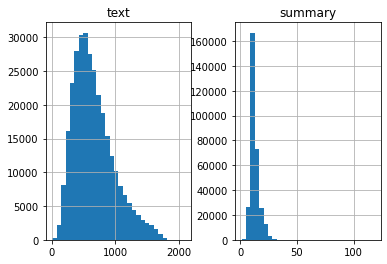

In [24]:
length_df.hist(bins = 30)
plt.show()

We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [25]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=17):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.8897923102329467


In [26]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=150):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.009066594133913594


Let us fix the maximum length of review to 120 and length of summary to 17.


In [27]:
max_text_len=120
max_summary_len=17

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [28]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])


In [29]:
len(cleaned_text)

308826

In [30]:
max_text_len

120

In [31]:
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if (len(cleaned_summary[i].split())>max_summary_len):
        short_summary.append(" ".join(cleaned_summary[i].split()[:17]))
    else:
        short_summary.append(cleaned_summary[i])
    
    if(len(cleaned_text[i].split())>max_text_len):
        short_text.append(" ".join(cleaned_text[i].split()[:120]))
    else:
        short_text.append(cleaned_text[i])
       
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

adding the **START** and **END** special tokens at the beginning and end of the summary.

In [32]:
df['summary'] = df['summary'].apply(lambda x : 'xl '+ x + ' xy')

In [33]:
df.shape

(308826, 2)

In [34]:
df.head()

,text,summary
0,for architects perfection is necessary said japanese architect kengo kuma it is my mission to use the kindness and delicateness that old architecture had i believe that this mission is not easy to...,xl japanese architect has popularized sensitive japanese traditions in buildings xy
1,the trial of former egyptian president mohamed morsy on charges of inciting the murders of at least three protesters in has been postponed until february because he did not appear in court wednesd...,xl the second session in the trial of mohamed morsy is postponed until february xy
2,cnn toyota motor corp has recently been in the hot seat after issuing massive recalls because of problems related to the accelerator pedal in several of its auto models to date million vehicles wo...,xl million vehicles worldwide have been recalled by toyota xy
3,mexicos international image may be taking hits because of the violence produced by drug cartels but it hasnt hurt its tourism industry officials say international tourism to mexico has increased i...,xl mexico remains the no destination for americans traveling abroad xy
4,thai scrapyard workers accidentally detonated a suspected world war iiera bomb wednesday killing seven and injuring after attempting to cut into it with a blowtorch the device was discovered at a ...,xl suspected wwiiera aerial bomb explodes in bangkok neighborhood killing seven xy


In [35]:
# df.to_csv("cnn_dailymail_after_processing_long.csv")

In [36]:
#files.download("cnn_dailymail_after_processing_long.csv")

We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [37]:
from sklearn.model_selection import train_test_split
x_tr1,x_val1,y_tr1,y_val1=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=False) 

### Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

### Text Tokenizer

In [38]:
!pip install youtokentome 

     |████████████████████████████████| 1.7MB 8.5MB/s 


In [39]:
import youtokentome as yttm

In [40]:
x_tokenizer = yttm.BPE(model='/content/drive/My Drive/Colab Notebooks/bpe.model')

In [42]:
print(x_tokenizer.encode([x_tr1[0]], output_type=yttm.OutputType.SUBWORD, dropout_prob=0.1))     

[['▁for', '▁ar', 'ch', 'it', 'ect', 's', '▁perfection', '▁is', '▁necessary', '▁said', '▁japanese', '▁ar', 'ch', 'it', 'ect', '▁k', 'en', 'go', '▁k', 'uma', '▁it', '▁is', '▁my', '▁mission', '▁to', '▁use', '▁the', '▁kind', 'ness', '▁and', '▁delic', 'at', 'eness', '▁that', '▁old', '▁ar', 'ch', 'it', 'ect', 'ure', '▁had', '▁i', '▁believe', '▁that', '▁this', '▁mission', '▁is', '▁not', '▁easy', '▁to', '▁complete', '▁so', '▁i', '▁am', '▁planning', '▁to', '▁work', '▁until', '▁i', '▁fall', '▁down', '▁with', '▁nearly', '▁projects', '▁on', '▁the', '▁go', '▁across', '▁the', '▁world', '▁k', 'um', 'as', '▁search', '▁for', '▁perfection', '▁is', '▁all', '▁consuming', '▁he', '▁rarely', '▁takes', '▁a', '▁day', '▁off', '▁from', '▁work', '▁and', '▁sometimes', '▁even', '▁finished', '▁projects', '▁are', '▁analy', 'zed', '▁and', '▁amend', 'ed', '▁the', '▁from', '▁to', 'ky', 'o', '▁has', '▁become', '▁syn', 'onymous', '▁with', '▁delicate', '▁simplicity', '▁and', '▁sensitivity', '▁to', '▁a', '▁build', 'ings', '

In [44]:
x_tr_seq    =   x_tokenizer.encode(list(x_tr1), output_type=yttm.OutputType.ID)
x_val_seq   =   x_tokenizer.encode(list(x_val1), output_type=yttm.OutputType.ID)

In [47]:
max=0
for x in x_val_seq:
    if len(x)>max:
        max=len(x)
      
print(max) 
max_text_len=max

240


In [48]:
max=0
for x in x_tr_seq:
    if len(x)>max:
        max=len(x)
      
print(max) 
max_text_len=max

384


In [49]:
x_tr    =   pad_sequences([x for x in x_tr_seq],  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences([x for x in x_val_seq], maxlen=max_text_len, padding='post')

In [50]:
dic={}
for x in x_tr:
    
    for word in x:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1
            
for x in x_val:
    
    for word in x:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1           

In [51]:
len(dic)

18083

define max integer representation of tokens

In [52]:
max=0
for x in x_tr:
    
    for word in x:
        
        if (word > max):
            max = word
for x in x_val:
    
    for word in x:
        
        if (word > max):
            max = word            
print(max)        

51999


In [53]:
#size of vocabulary ( +1 for padding token)
x_voc   =  max + 1

### Summary Tokenizer

Let us define the tokenizer with top most common words for summary.

In [54]:
#prepare a tokenizer for reviews on training data
y_tokenizer = yttm.BPE(model='/content/drive/My Drive/Colab Notebooks/bpe.model')

In [56]:
y_tr_seq    =   y_tokenizer.encode(list(y_tr1), output_type=yttm.OutputType.ID, dropout_prob=0.1)
y_val_seq   =   y_tokenizer.encode(list(y_val1), output_type=yttm.OutputType.ID, dropout_prob=0.1)

In [57]:
max=0
for x in y_val_seq:
    if len(x)>max:
        max=len(x)
print(max) 
max_summary_len=max

47


In [58]:
max=0
for x in y_tr_seq:
    if len(x)>max:
        max=len(x)
print(max) 
max_summary_len=max

53


In [59]:
#padding zero upto maximum length
y_tr    =   pad_sequences([y for y in y_tr_seq],  maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences([y for y in y_val_seq], maxlen=max_summary_len, padding='post')

In [60]:
max=0
for x in y_tr:
    
    for word in x:
        
        if (word > max):
            max = word
for x in y_val:
    
    for word in x:
        
        if (word > max):
            max = word            
print(max)       

51999


In [61]:
#size of vocabulary
y_voc  =   max +1

In [62]:
y_voc

52000

Here, I am deleting the rows that contain only **START** and **END** tokens

In [63]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [64]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. 

Here, we are building a 3 stacked Bi-LSTM for the encoder:

In [65]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm3(encoder_output2)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_text_len,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
# decoder   
decoder_lstm = LSTM(600, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_h, decoder_c = decoder_lstm(dec_emb,initial_state=encoder_states)

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 384, 100)     5200000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 384, 600), ( 962400      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 384, 600), ( 2162400     bidirectional[0][0]              
_______________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [66]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

The concept of early stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [68]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [69]:
# Создаем коллбек сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [70]:
#history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=35,callbacks=[cp_callback],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [71]:
#model.save_weights("bpe_model_35.h5")

In [72]:
# from google.colab import files
# files.download( "/content/bpe_model_35.h5" )

Load weights of already trained model

In [73]:
#model.load_weights("bpe_model_35.h5")

#Diagnostic plot


In [74]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# Inference

Set up the inference for the encoder and decoder:

In [75]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, encoder_states])
#encoder_model = Model(inputs=encoder_inputs,outputs= encoder_states )

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2  = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_states_inputs],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process:

In [76]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    test=[]

    stop_condition = False
    decoded_sentence = ''
    decoded_sentence_test = ''
    k=0  
     
    while k<max_summary_len:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        test.append(sampled_token_index)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        k+=1
        # Update internal states
        e_h, e_c = h, c
     
    new_output=[]
    for i in test:
         if (i!=0 ):
           new_output.append(i)
    
    output = y_tokenizer.decode([new_output])
    
    
    newString=''
    for i in output[0].split(' '):
         
         if (i!='xl' and i!='xy' ):
             newString=newString+i+' '
    
    return newString

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [78]:
def seq2summary(input_seq):
    
     new_input=[]
     for i in range(len(input_seq)):
         if (input_seq[i]!=0 ):
           new_input.append(input_seq[i])
     
     output = y_tokenizer.decode([new_input]) 
     
     newString=''
     for i in output[0].split(' '):
         
         if (i!='xl' and i!='xy' ):
             newString=newString+i+' '
    
     return newString

def seq2text(input_seq):
     new_input=[]
     for i in input_seq:
         
         if (i!=0 ):
           new_input.append(i)
     return x_tokenizer.decode([new_input])

Here are a few summaries generated by the model:

In [103]:
for i in range(0,10):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: ['so far victims have come forward to describe the abuse they suffered at jimmy hands while in the care of the national health service below are the stories of just four of the vulnerable people he targeted one victim said nurses laughed when she told them she had been sexually assaulted by savile in a hospital basement so far victims have come forward to describe the abuse they suffered at jimmy hands while in the care of the national health service the woman who was then a patient at leeds general infirmary said savile made her feel like the taking her to the local shop and buying her sweets and magazines but she claimed that later a hospital porter led']
Original summary: so far victims have come forward to describe the abuse they suffered 
Predicted summary: victims abused by jimmy


Review: ['laurent koscielny is arsene wengers latest injury concern after he was released by france to return to arsenal for treatment on an achilles problem the knock is only regarded as minor

### Preparation for using metric Rouge

Make the dataframe with original and predicted summaries

In [104]:
original_summary = []
predicted_summary = []

In [106]:
for i in range(len(y_val)):
    original_summary.append(seq2summary(y_val[i]))

In [107]:
for i in range(len(original_summary)):
    original_summary[i] = re.sub('<s>','', original_summary[i])
    original_summary[i] = re.sub('<s','', original_summary[i])
    original_summary[i] = re.sub('xy','', original_summary[i])
    original_summary[i] = re.sub('<','', original_summary[i])
    original_summary[i] = original_summary[i].strip()

In [108]:
original_summary[:5]

['so far victims have come forward to describe the abuse they suffered',
 'laurent koscielny released by france to return to arsenal for treatment',
 'the princess royal chatted to team members before kickoff',
 'judy murray in talks to appear in the next series of strictly come dancing',
 'the floating hotel concept has been developed by a finnish architects firm']

In [110]:
for i in range(len(y_val)):
     predicted_summary.append(decode_sequence(x_val[i].reshape(1,max_text_len)))

In [111]:
for i in range(len(predicted_summary)):
    predicted_summary[i] = re.sub('<s>','', predicted_summary[i])
    predicted_summary[i] = re.sub('<s','', predicted_summary[i])
    predicted_summary[i] = re.sub('xy','', predicted_summary[i])
    predicted_summary[i] = re.sub('<','', predicted_summary[i])
    predicted_summary[i] = predicted_summary[i].strip()

In [112]:
dataframe = pd.DataFrame({'original_summary': original_summary, 'predicted_summary':predicted_summary})

Delete empty predictions

In [ ]:
np.where(dataframe['predicted_summary']=='')

(array([], dtype=int64),)

In [ ]:
np.where(dataframe['original_summary']=='')

(array([], dtype=int64),)

In [ ]:
dataframe = dataframe.drop(np.where(dataframe['predicted_summary']=='')[0])

In [ ]:
dataframe = dataframe.reset_index(drop=True)

In [113]:
dataframe.shape

(30883, 2)

In [ ]:
dataframe.to_csv('predictions_cnn_without_empty.csv')

Create two folders with txt original and predicted summaries

In [ ]:
for i in range(len(dataframe)):
    
    f = open('original_cnn/original_summary' + str(i) + '.txt', 'w', encoding="utf-8")
    f.write(dataframe['original_summary'][i])

In [ ]:
for i in range(len(dataframe)):
    
    f = open('predicted_cnn/predicted_summary' + str(i) + '.txt', 'w', encoding="utf-8")
    f.write(dataframe['predicted_summary'][i])

Import pyrouge

In [9]:
from pyrouge import Rouge155

In [10]:
r = Rouge155('C:/Users/Margarita/pyrouge/rouge/tools/ROUGE-1.5.5')

2020-11-01 13:05:31,055 [MainThread  ] [INFO ]  Set ROUGE home directory to C:/Users/Margarita/pyrouge/rouge/tools/ROUGE-1.5.5.


In [11]:
r.system_dir = 'C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/original_bilstm_lstm_secretiki' # Summaries to score against.
r.model_dir = 'C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/predicted_bilstm_lstm_secretiki'  # Summaries generated by the model

In [12]:
r.system_filename_pattern = 'original_summary(\d+).txt'
r.model_filename_pattern = 'predicted_summary#ID#.txt'

In [13]:
output = r.convert_and_evaluate()

2020-11-01 13:05:33,477 [MainThread  ] [INFO ]  Writing summaries.
2020-11-01 13:05:33,484 [MainThread  ] [INFO ]  Processing files in C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/original_bilstm_lstm_secretiki.
2020-11-01 13:05:33,810 [MainThread  ] [INFO ]  Processing original_summary0.txt.
2020-11-01 13:05:33,812 [MainThread  ] [INFO ]  Processing original_summary1.txt.
2020-11-01 13:05:33,815 [MainThread  ] [INFO ]  Processing original_summary10.txt.
2020-11-01 13:05:33,818 [MainThread  ] [INFO ]  Processing original_summary100.txt.
2020-11-01 13:05:33,820 [MainThread  ] [INFO ]  Processing original_summary1000.txt.
2020-11-01 13:05:33,822 [MainThread  ] [INFO ]  Processing original_summary1001.txt.
2020-11-01 13:05:33,824 [MainThread  ] [INFO ]  Processing original_summary1002.txt.
2020-11-01 13:05:33,826 [MainThread  ] [INFO ]  Processing original_summary1003.txt.
2020-11-01 13:05:33,828 [MainThread  ] [INFO ]  Processing or

2020-11-01 13:05:34,065 [MainThread  ] [INFO ]  Processing original_summary1082.txt.
2020-11-01 13:05:34,067 [MainThread  ] [INFO ]  Processing original_summary1083.txt.
2020-11-01 13:05:34,070 [MainThread  ] [INFO ]  Processing original_summary1084.txt.
2020-11-01 13:05:34,073 [MainThread  ] [INFO ]  Processing original_summary1085.txt.
2020-11-01 13:05:34,076 [MainThread  ] [INFO ]  Processing original_summary1086.txt.
2020-11-01 13:05:34,081 [MainThread  ] [INFO ]  Processing original_summary1087.txt.
2020-11-01 13:05:34,084 [MainThread  ] [INFO ]  Processing original_summary1088.txt.
2020-11-01 13:05:34,087 [MainThread  ] [INFO ]  Processing original_summary1089.txt.
2020-11-01 13:05:34,090 [MainThread  ] [INFO ]  Processing original_summary109.txt.
2020-11-01 13:05:34,093 [MainThread  ] [INFO ]  Processing original_summary1090.txt.
2020-11-01 13:05:34,095 [MainThread  ] [INFO ]  Processing original_summary1091.txt.
2020-11-01 13:05:34,098 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:34,347 [MainThread  ] [INFO ]  Processing original_summary117.txt.
2020-11-01 13:05:34,350 [MainThread  ] [INFO ]  Processing original_summary1170.txt.
2020-11-01 13:05:34,353 [MainThread  ] [INFO ]  Processing original_summary1171.txt.
2020-11-01 13:05:34,357 [MainThread  ] [INFO ]  Processing original_summary1172.txt.
2020-11-01 13:05:34,360 [MainThread  ] [INFO ]  Processing original_summary1173.txt.
2020-11-01 13:05:34,363 [MainThread  ] [INFO ]  Processing original_summary1174.txt.
2020-11-01 13:05:34,366 [MainThread  ] [INFO ]  Processing original_summary1175.txt.
2020-11-01 13:05:34,368 [MainThread  ] [INFO ]  Processing original_summary1176.txt.
2020-11-01 13:05:34,371 [MainThread  ] [INFO ]  Processing original_summary1177.txt.
2020-11-01 13:05:34,374 [MainThread  ] [INFO ]  Processing original_summary1178.txt.
2020-11-01 13:05:34,377 [MainThread  ] [INFO ]  Processing original_summary1179.txt.
2020-11-01 13:05:34,381 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:34,630 [MainThread  ] [INFO ]  Processing original_summary1257.txt.
2020-11-01 13:05:34,633 [MainThread  ] [INFO ]  Processing original_summary1258.txt.
2020-11-01 13:05:34,636 [MainThread  ] [INFO ]  Processing original_summary1259.txt.
2020-11-01 13:05:34,639 [MainThread  ] [INFO ]  Processing original_summary126.txt.
2020-11-01 13:05:34,642 [MainThread  ] [INFO ]  Processing original_summary1260.txt.
2020-11-01 13:05:34,644 [MainThread  ] [INFO ]  Processing original_summary1261.txt.
2020-11-01 13:05:34,647 [MainThread  ] [INFO ]  Processing original_summary1262.txt.
2020-11-01 13:05:34,649 [MainThread  ] [INFO ]  Processing original_summary1263.txt.
2020-11-01 13:05:34,652 [MainThread  ] [INFO ]  Processing original_summary1264.txt.
2020-11-01 13:05:34,655 [MainThread  ] [INFO ]  Processing original_summary1265.txt.
2020-11-01 13:05:34,658 [MainThread  ] [INFO ]  Processing original_summary1266.txt.
2020-11-01 13:05:34,660 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:34,928 [MainThread  ] [INFO ]  Processing original_summary1344.txt.
2020-11-01 13:05:34,930 [MainThread  ] [INFO ]  Processing original_summary1345.txt.
2020-11-01 13:05:34,933 [MainThread  ] [INFO ]  Processing original_summary1346.txt.
2020-11-01 13:05:34,937 [MainThread  ] [INFO ]  Processing original_summary1347.txt.
2020-11-01 13:05:34,940 [MainThread  ] [INFO ]  Processing original_summary1348.txt.
2020-11-01 13:05:34,943 [MainThread  ] [INFO ]  Processing original_summary1349.txt.
2020-11-01 13:05:34,945 [MainThread  ] [INFO ]  Processing original_summary135.txt.
2020-11-01 13:05:34,948 [MainThread  ] [INFO ]  Processing original_summary1350.txt.
2020-11-01 13:05:34,950 [MainThread  ] [INFO ]  Processing original_summary1351.txt.
2020-11-01 13:05:34,953 [MainThread  ] [INFO ]  Processing original_summary1352.txt.
2020-11-01 13:05:34,955 [MainThread  ] [INFO ]  Processing original_summary1353.txt.
2020-11-01 13:05:34,957 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:35,205 [MainThread  ] [INFO ]  Processing original_summary1431.txt.
2020-11-01 13:05:35,208 [MainThread  ] [INFO ]  Processing original_summary1432.txt.
2020-11-01 13:05:35,211 [MainThread  ] [INFO ]  Processing original_summary1433.txt.
2020-11-01 13:05:35,214 [MainThread  ] [INFO ]  Processing original_summary1434.txt.
2020-11-01 13:05:35,217 [MainThread  ] [INFO ]  Processing original_summary1435.txt.
2020-11-01 13:05:35,221 [MainThread  ] [INFO ]  Processing original_summary1436.txt.
2020-11-01 13:05:35,223 [MainThread  ] [INFO ]  Processing original_summary1437.txt.
2020-11-01 13:05:35,226 [MainThread  ] [INFO ]  Processing original_summary1438.txt.
2020-11-01 13:05:35,228 [MainThread  ] [INFO ]  Processing original_summary1439.txt.
2020-11-01 13:05:35,232 [MainThread  ] [INFO ]  Processing original_summary144.txt.
2020-11-01 13:05:35,236 [MainThread  ] [INFO ]  Processing original_summary1440.txt.
2020-11-01 13:05:35,239 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:35,480 [MainThread  ] [INFO ]  Processing original_summary1519.txt.
2020-11-01 13:05:35,483 [MainThread  ] [INFO ]  Processing original_summary152.txt.
2020-11-01 13:05:35,487 [MainThread  ] [INFO ]  Processing original_summary1520.txt.
2020-11-01 13:05:35,490 [MainThread  ] [INFO ]  Processing original_summary1521.txt.
2020-11-01 13:05:35,493 [MainThread  ] [INFO ]  Processing original_summary1522.txt.
2020-11-01 13:05:35,495 [MainThread  ] [INFO ]  Processing original_summary1523.txt.
2020-11-01 13:05:35,498 [MainThread  ] [INFO ]  Processing original_summary1524.txt.
2020-11-01 13:05:35,501 [MainThread  ] [INFO ]  Processing original_summary1525.txt.
2020-11-01 13:05:35,504 [MainThread  ] [INFO ]  Processing original_summary1526.txt.
2020-11-01 13:05:35,506 [MainThread  ] [INFO ]  Processing original_summary1527.txt.
2020-11-01 13:05:35,510 [MainThread  ] [INFO ]  Processing original_summary1528.txt.
2020-11-01 13:05:35,513 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:35,780 [MainThread  ] [INFO ]  Processing original_summary1606.txt.
2020-11-01 13:05:35,782 [MainThread  ] [INFO ]  Processing original_summary1607.txt.
2020-11-01 13:05:35,787 [MainThread  ] [INFO ]  Processing original_summary1608.txt.
2020-11-01 13:05:35,789 [MainThread  ] [INFO ]  Processing original_summary1609.txt.
2020-11-01 13:05:35,792 [MainThread  ] [INFO ]  Processing original_summary161.txt.
2020-11-01 13:05:35,794 [MainThread  ] [INFO ]  Processing original_summary1610.txt.
2020-11-01 13:05:35,797 [MainThread  ] [INFO ]  Processing original_summary1611.txt.
2020-11-01 13:05:35,799 [MainThread  ] [INFO ]  Processing original_summary1612.txt.
2020-11-01 13:05:35,805 [MainThread  ] [INFO ]  Processing original_summary1613.txt.
2020-11-01 13:05:35,808 [MainThread  ] [INFO ]  Processing original_summary1614.txt.
2020-11-01 13:05:35,811 [MainThread  ] [INFO ]  Processing original_summary1615.txt.
2020-11-01 13:05:35,814 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:36,064 [MainThread  ] [INFO ]  Processing original_summary1694.txt.
2020-11-01 13:05:36,067 [MainThread  ] [INFO ]  Processing original_summary1695.txt.
2020-11-01 13:05:36,071 [MainThread  ] [INFO ]  Processing original_summary1696.txt.
2020-11-01 13:05:36,073 [MainThread  ] [INFO ]  Processing original_summary1697.txt.
2020-11-01 13:05:36,075 [MainThread  ] [INFO ]  Processing original_summary1698.txt.
2020-11-01 13:05:36,078 [MainThread  ] [INFO ]  Processing original_summary1699.txt.
2020-11-01 13:05:36,080 [MainThread  ] [INFO ]  Processing original_summary17.txt.
2020-11-01 13:05:36,083 [MainThread  ] [INFO ]  Processing original_summary170.txt.
2020-11-01 13:05:36,086 [MainThread  ] [INFO ]  Processing original_summary1700.txt.
2020-11-01 13:05:36,089 [MainThread  ] [INFO ]  Processing original_summary1701.txt.
2020-11-01 13:05:36,092 [MainThread  ] [INFO ]  Processing original_summary1702.txt.
2020-11-01 13:05:36,096 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:36,334 [MainThread  ] [INFO ]  Processing original_summary1781.txt.
2020-11-01 13:05:36,338 [MainThread  ] [INFO ]  Processing original_summary1782.txt.
2020-11-01 13:05:36,341 [MainThread  ] [INFO ]  Processing original_summary1783.txt.
2020-11-01 13:05:36,344 [MainThread  ] [INFO ]  Processing original_summary1784.txt.
2020-11-01 13:05:36,346 [MainThread  ] [INFO ]  Processing original_summary1785.txt.
2020-11-01 13:05:36,348 [MainThread  ] [INFO ]  Processing original_summary1786.txt.
2020-11-01 13:05:36,351 [MainThread  ] [INFO ]  Processing original_summary1787.txt.
2020-11-01 13:05:36,354 [MainThread  ] [INFO ]  Processing original_summary1788.txt.
2020-11-01 13:05:36,356 [MainThread  ] [INFO ]  Processing original_summary1789.txt.
2020-11-01 13:05:36,359 [MainThread  ] [INFO ]  Processing original_summary179.txt.
2020-11-01 13:05:36,362 [MainThread  ] [INFO ]  Processing original_summary1790.txt.
2020-11-01 13:05:36,365 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:36,608 [MainThread  ] [INFO ]  Processing original_summary1869.txt.
2020-11-01 13:05:36,611 [MainThread  ] [INFO ]  Processing original_summary187.txt.
2020-11-01 13:05:36,614 [MainThread  ] [INFO ]  Processing original_summary1870.txt.
2020-11-01 13:05:36,617 [MainThread  ] [INFO ]  Processing original_summary1871.txt.
2020-11-01 13:05:36,620 [MainThread  ] [INFO ]  Processing original_summary1872.txt.
2020-11-01 13:05:36,623 [MainThread  ] [INFO ]  Processing original_summary1873.txt.
2020-11-01 13:05:36,626 [MainThread  ] [INFO ]  Processing original_summary1874.txt.
2020-11-01 13:05:36,628 [MainThread  ] [INFO ]  Processing original_summary1875.txt.
2020-11-01 13:05:36,631 [MainThread  ] [INFO ]  Processing original_summary1876.txt.
2020-11-01 13:05:36,634 [MainThread  ] [INFO ]  Processing original_summary1877.txt.
2020-11-01 13:05:36,638 [MainThread  ] [INFO ]  Processing original_summary1878.txt.
2020-11-01 13:05:36,640 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:36,875 [MainThread  ] [INFO ]  Processing original_summary1956.txt.
2020-11-01 13:05:36,877 [MainThread  ] [INFO ]  Processing original_summary1957.txt.
2020-11-01 13:05:36,880 [MainThread  ] [INFO ]  Processing original_summary1958.txt.
2020-11-01 13:05:36,883 [MainThread  ] [INFO ]  Processing original_summary1959.txt.
2020-11-01 13:05:36,885 [MainThread  ] [INFO ]  Processing original_summary196.txt.
2020-11-01 13:05:36,888 [MainThread  ] [INFO ]  Processing original_summary1960.txt.
2020-11-01 13:05:36,891 [MainThread  ] [INFO ]  Processing original_summary1961.txt.
2020-11-01 13:05:36,893 [MainThread  ] [INFO ]  Processing original_summary1962.txt.
2020-11-01 13:05:36,895 [MainThread  ] [INFO ]  Processing original_summary1963.txt.
2020-11-01 13:05:36,898 [MainThread  ] [INFO ]  Processing original_summary1964.txt.
2020-11-01 13:05:36,901 [MainThread  ] [INFO ]  Processing original_summary1965.txt.
2020-11-01 13:05:36,904 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:37,165 [MainThread  ] [INFO ]  Processing original_summary2042.txt.
2020-11-01 13:05:37,170 [MainThread  ] [INFO ]  Processing original_summary2043.txt.
2020-11-01 13:05:37,173 [MainThread  ] [INFO ]  Processing original_summary2044.txt.
2020-11-01 13:05:37,177 [MainThread  ] [INFO ]  Processing original_summary2045.txt.
2020-11-01 13:05:37,180 [MainThread  ] [INFO ]  Processing original_summary2046.txt.
2020-11-01 13:05:37,183 [MainThread  ] [INFO ]  Processing original_summary2047.txt.
2020-11-01 13:05:37,187 [MainThread  ] [INFO ]  Processing original_summary2048.txt.
2020-11-01 13:05:37,190 [MainThread  ] [INFO ]  Processing original_summary2049.txt.
2020-11-01 13:05:37,192 [MainThread  ] [INFO ]  Processing original_summary205.txt.
2020-11-01 13:05:37,195 [MainThread  ] [INFO ]  Processing original_summary2050.txt.
2020-11-01 13:05:37,198 [MainThread  ] [INFO ]  Processing original_summary2051.txt.
2020-11-01 13:05:37,201 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:37,448 [MainThread  ] [INFO ]  Processing original_summary213.txt.
2020-11-01 13:05:37,451 [MainThread  ] [INFO ]  Processing original_summary2130.txt.
2020-11-01 13:05:37,453 [MainThread  ] [INFO ]  Processing original_summary2131.txt.
2020-11-01 13:05:37,456 [MainThread  ] [INFO ]  Processing original_summary2132.txt.
2020-11-01 13:05:37,459 [MainThread  ] [INFO ]  Processing original_summary2133.txt.
2020-11-01 13:05:37,462 [MainThread  ] [INFO ]  Processing original_summary2134.txt.
2020-11-01 13:05:37,465 [MainThread  ] [INFO ]  Processing original_summary2135.txt.
2020-11-01 13:05:37,467 [MainThread  ] [INFO ]  Processing original_summary2136.txt.
2020-11-01 13:05:37,470 [MainThread  ] [INFO ]  Processing original_summary2137.txt.
2020-11-01 13:05:37,473 [MainThread  ] [INFO ]  Processing original_summary2138.txt.
2020-11-01 13:05:37,475 [MainThread  ] [INFO ]  Processing original_summary2139.txt.
2020-11-01 13:05:37,477 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:37,709 [MainThread  ] [INFO ]  Processing original_summary2217.txt.
2020-11-01 13:05:37,711 [MainThread  ] [INFO ]  Processing original_summary2218.txt.
2020-11-01 13:05:37,713 [MainThread  ] [INFO ]  Processing original_summary2219.txt.
2020-11-01 13:05:37,716 [MainThread  ] [INFO ]  Processing original_summary222.txt.
2020-11-01 13:05:37,719 [MainThread  ] [INFO ]  Processing original_summary2220.txt.
2020-11-01 13:05:37,721 [MainThread  ] [INFO ]  Processing original_summary2221.txt.
2020-11-01 13:05:37,723 [MainThread  ] [INFO ]  Processing original_summary2222.txt.
2020-11-01 13:05:37,725 [MainThread  ] [INFO ]  Processing original_summary2223.txt.
2020-11-01 13:05:37,728 [MainThread  ] [INFO ]  Processing original_summary2224.txt.
2020-11-01 13:05:37,731 [MainThread  ] [INFO ]  Processing original_summary2225.txt.
2020-11-01 13:05:37,734 [MainThread  ] [INFO ]  Processing original_summary2226.txt.
2020-11-01 13:05:37,737 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:37,952 [MainThread  ] [INFO ]  Processing original_summary2304.txt.
2020-11-01 13:05:37,955 [MainThread  ] [INFO ]  Processing original_summary2305.txt.
2020-11-01 13:05:37,957 [MainThread  ] [INFO ]  Processing original_summary2306.txt.
2020-11-01 13:05:37,959 [MainThread  ] [INFO ]  Processing original_summary2307.txt.
2020-11-01 13:05:37,962 [MainThread  ] [INFO ]  Processing original_summary2308.txt.
2020-11-01 13:05:37,964 [MainThread  ] [INFO ]  Processing original_summary2309.txt.
2020-11-01 13:05:37,967 [MainThread  ] [INFO ]  Processing original_summary231.txt.
2020-11-01 13:05:37,969 [MainThread  ] [INFO ]  Processing original_summary2310.txt.
2020-11-01 13:05:37,971 [MainThread  ] [INFO ]  Processing original_summary2311.txt.
2020-11-01 13:05:37,973 [MainThread  ] [INFO ]  Processing original_summary2312.txt.
2020-11-01 13:05:37,976 [MainThread  ] [INFO ]  Processing original_summary2313.txt.
2020-11-01 13:05:37,978 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:38,212 [MainThread  ] [INFO ]  Processing original_summary2392.txt.
2020-11-01 13:05:38,214 [MainThread  ] [INFO ]  Processing original_summary2393.txt.
2020-11-01 13:05:38,217 [MainThread  ] [INFO ]  Processing original_summary2394.txt.
2020-11-01 13:05:38,220 [MainThread  ] [INFO ]  Processing original_summary2395.txt.
2020-11-01 13:05:38,222 [MainThread  ] [INFO ]  Processing original_summary2396.txt.
2020-11-01 13:05:38,225 [MainThread  ] [INFO ]  Processing original_summary2397.txt.
2020-11-01 13:05:38,227 [MainThread  ] [INFO ]  Processing original_summary2398.txt.
2020-11-01 13:05:38,229 [MainThread  ] [INFO ]  Processing original_summary2399.txt.
2020-11-01 13:05:38,232 [MainThread  ] [INFO ]  Processing original_summary24.txt.
2020-11-01 13:05:38,235 [MainThread  ] [INFO ]  Processing original_summary240.txt.
2020-11-01 13:05:38,238 [MainThread  ] [INFO ]  Processing original_summary2400.txt.
2020-11-01 13:05:38,240 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:38,462 [MainThread  ] [INFO ]  Processing original_summary248.txt.
2020-11-01 13:05:38,465 [MainThread  ] [INFO ]  Processing original_summary2480.txt.
2020-11-01 13:05:38,467 [MainThread  ] [INFO ]  Processing original_summary2481.txt.
2020-11-01 13:05:38,470 [MainThread  ] [INFO ]  Processing original_summary2482.txt.
2020-11-01 13:05:38,473 [MainThread  ] [INFO ]  Processing original_summary2483.txt.
2020-11-01 13:05:38,475 [MainThread  ] [INFO ]  Processing original_summary2484.txt.
2020-11-01 13:05:38,477 [MainThread  ] [INFO ]  Processing original_summary2485.txt.
2020-11-01 13:05:38,480 [MainThread  ] [INFO ]  Processing original_summary2486.txt.
2020-11-01 13:05:38,483 [MainThread  ] [INFO ]  Processing original_summary2487.txt.
2020-11-01 13:05:38,485 [MainThread  ] [INFO ]  Processing original_summary2488.txt.
2020-11-01 13:05:38,487 [MainThread  ] [INFO ]  Processing original_summary2489.txt.
2020-11-01 13:05:38,489 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:38,688 [MainThread  ] [INFO ]  Processing original_summary2567.txt.
2020-11-01 13:05:38,691 [MainThread  ] [INFO ]  Processing original_summary2568.txt.
2020-11-01 13:05:38,693 [MainThread  ] [INFO ]  Processing original_summary2569.txt.
2020-11-01 13:05:38,694 [MainThread  ] [INFO ]  Processing original_summary257.txt.
2020-11-01 13:05:38,696 [MainThread  ] [INFO ]  Processing original_summary2570.txt.
2020-11-01 13:05:38,699 [MainThread  ] [INFO ]  Processing original_summary2571.txt.
2020-11-01 13:05:38,702 [MainThread  ] [INFO ]  Processing original_summary2572.txt.
2020-11-01 13:05:38,705 [MainThread  ] [INFO ]  Processing original_summary2573.txt.
2020-11-01 13:05:38,707 [MainThread  ] [INFO ]  Processing original_summary2574.txt.
2020-11-01 13:05:38,710 [MainThread  ] [INFO ]  Processing original_summary2575.txt.
2020-11-01 13:05:38,712 [MainThread  ] [INFO ]  Processing original_summary2576.txt.
2020-11-01 13:05:38,714 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:38,935 [MainThread  ] [INFO ]  Processing original_summary2654.txt.
2020-11-01 13:05:38,937 [MainThread  ] [INFO ]  Processing original_summary2655.txt.
2020-11-01 13:05:38,940 [MainThread  ] [INFO ]  Processing original_summary2656.txt.
2020-11-01 13:05:38,942 [MainThread  ] [INFO ]  Processing original_summary2657.txt.
2020-11-01 13:05:38,944 [MainThread  ] [INFO ]  Processing original_summary2658.txt.
2020-11-01 13:05:38,947 [MainThread  ] [INFO ]  Processing original_summary2659.txt.
2020-11-01 13:05:38,951 [MainThread  ] [INFO ]  Processing original_summary266.txt.
2020-11-01 13:05:38,953 [MainThread  ] [INFO ]  Processing original_summary2660.txt.
2020-11-01 13:05:38,955 [MainThread  ] [INFO ]  Processing original_summary2661.txt.
2020-11-01 13:05:38,957 [MainThread  ] [INFO ]  Processing original_summary2662.txt.
2020-11-01 13:05:38,959 [MainThread  ] [INFO ]  Processing original_summary2663.txt.
2020-11-01 13:05:38,961 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:39,181 [MainThread  ] [INFO ]  Processing original_summary2741.txt.
2020-11-01 13:05:39,184 [MainThread  ] [INFO ]  Processing original_summary2742.txt.
2020-11-01 13:05:39,187 [MainThread  ] [INFO ]  Processing original_summary2743.txt.
2020-11-01 13:05:39,189 [MainThread  ] [INFO ]  Processing original_summary2744.txt.
2020-11-01 13:05:39,191 [MainThread  ] [INFO ]  Processing original_summary2745.txt.
2020-11-01 13:05:39,194 [MainThread  ] [INFO ]  Processing original_summary2746.txt.
2020-11-01 13:05:39,197 [MainThread  ] [INFO ]  Processing original_summary2747.txt.
2020-11-01 13:05:39,201 [MainThread  ] [INFO ]  Processing original_summary2748.txt.
2020-11-01 13:05:39,203 [MainThread  ] [INFO ]  Processing original_summary2749.txt.
2020-11-01 13:05:39,206 [MainThread  ] [INFO ]  Processing original_summary275.txt.
2020-11-01 13:05:39,208 [MainThread  ] [INFO ]  Processing original_summary2750.txt.
2020-11-01 13:05:39,210 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:39,449 [MainThread  ] [INFO ]  Processing original_summary2829.txt.
2020-11-01 13:05:39,452 [MainThread  ] [INFO ]  Processing original_summary283.txt.
2020-11-01 13:05:39,454 [MainThread  ] [INFO ]  Processing original_summary2830.txt.
2020-11-01 13:05:39,457 [MainThread  ] [INFO ]  Processing original_summary2831.txt.
2020-11-01 13:05:39,460 [MainThread  ] [INFO ]  Processing original_summary2832.txt.
2020-11-01 13:05:39,464 [MainThread  ] [INFO ]  Processing original_summary2833.txt.
2020-11-01 13:05:39,466 [MainThread  ] [INFO ]  Processing original_summary2834.txt.
2020-11-01 13:05:39,469 [MainThread  ] [INFO ]  Processing original_summary2835.txt.
2020-11-01 13:05:39,471 [MainThread  ] [INFO ]  Processing original_summary2836.txt.
2020-11-01 13:05:39,473 [MainThread  ] [INFO ]  Processing original_summary2837.txt.
2020-11-01 13:05:39,477 [MainThread  ] [INFO ]  Processing original_summary2838.txt.
2020-11-01 13:05:39,480 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:39,740 [MainThread  ] [INFO ]  Processing original_summary2916.txt.
2020-11-01 13:05:39,742 [MainThread  ] [INFO ]  Processing original_summary2917.txt.
2020-11-01 13:05:39,745 [MainThread  ] [INFO ]  Processing original_summary2918.txt.
2020-11-01 13:05:39,749 [MainThread  ] [INFO ]  Processing original_summary2919.txt.
2020-11-01 13:05:39,751 [MainThread  ] [INFO ]  Processing original_summary292.txt.
2020-11-01 13:05:39,754 [MainThread  ] [INFO ]  Processing original_summary2920.txt.
2020-11-01 13:05:39,756 [MainThread  ] [INFO ]  Processing original_summary2921.txt.
2020-11-01 13:05:39,759 [MainThread  ] [INFO ]  Processing original_summary2922.txt.
2020-11-01 13:05:39,762 [MainThread  ] [INFO ]  Processing original_summary2923.txt.
2020-11-01 13:05:39,764 [MainThread  ] [INFO ]  Processing original_summary2924.txt.
2020-11-01 13:05:39,767 [MainThread  ] [INFO ]  Processing original_summary2925.txt.
2020-11-01 13:05:39,770 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:40,009 [MainThread  ] [INFO ]  Processing original_summary3002.txt.
2020-11-01 13:05:40,012 [MainThread  ] [INFO ]  Processing original_summary3003.txt.
2020-11-01 13:05:40,015 [MainThread  ] [INFO ]  Processing original_summary3004.txt.
2020-11-01 13:05:40,018 [MainThread  ] [INFO ]  Processing original_summary3005.txt.
2020-11-01 13:05:40,021 [MainThread  ] [INFO ]  Processing original_summary3006.txt.
2020-11-01 13:05:40,023 [MainThread  ] [INFO ]  Processing original_summary3007.txt.
2020-11-01 13:05:40,026 [MainThread  ] [INFO ]  Processing original_summary3008.txt.
2020-11-01 13:05:40,028 [MainThread  ] [INFO ]  Processing original_summary3009.txt.
2020-11-01 13:05:40,031 [MainThread  ] [INFO ]  Processing original_summary301.txt.
2020-11-01 13:05:40,034 [MainThread  ] [INFO ]  Processing original_summary3010.txt.
2020-11-01 13:05:40,037 [MainThread  ] [INFO ]  Processing original_summary3011.txt.
2020-11-01 13:05:40,039 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:40,292 [MainThread  ] [INFO ]  Processing original_summary3090.txt.
2020-11-01 13:05:40,295 [MainThread  ] [INFO ]  Processing original_summary3091.txt.
2020-11-01 13:05:40,297 [MainThread  ] [INFO ]  Processing original_summary3092.txt.
2020-11-01 13:05:40,301 [MainThread  ] [INFO ]  Processing original_summary3093.txt.
2020-11-01 13:05:40,303 [MainThread  ] [INFO ]  Processing original_summary3094.txt.
2020-11-01 13:05:40,305 [MainThread  ] [INFO ]  Processing original_summary3095.txt.
2020-11-01 13:05:40,307 [MainThread  ] [INFO ]  Processing original_summary3096.txt.
2020-11-01 13:05:40,310 [MainThread  ] [INFO ]  Processing original_summary3097.txt.
2020-11-01 13:05:40,313 [MainThread  ] [INFO ]  Processing original_summary3098.txt.
2020-11-01 13:05:40,316 [MainThread  ] [INFO ]  Processing original_summary3099.txt.
2020-11-01 13:05:40,321 [MainThread  ] [INFO ]  Processing original_summary31.txt.
2020-11-01 13:05:40,323 [MainThread  ] [INFO ]  Processing original

2020-11-01 13:05:40,567 [MainThread  ] [INFO ]  Processing original_summary3178.txt.
2020-11-01 13:05:40,570 [MainThread  ] [INFO ]  Processing original_summary3179.txt.
2020-11-01 13:05:40,573 [MainThread  ] [INFO ]  Processing original_summary318.txt.
2020-11-01 13:05:40,575 [MainThread  ] [INFO ]  Processing original_summary3180.txt.
2020-11-01 13:05:40,578 [MainThread  ] [INFO ]  Processing original_summary3181.txt.
2020-11-01 13:05:40,582 [MainThread  ] [INFO ]  Processing original_summary3182.txt.
2020-11-01 13:05:40,584 [MainThread  ] [INFO ]  Processing original_summary3183.txt.
2020-11-01 13:05:40,586 [MainThread  ] [INFO ]  Processing original_summary3184.txt.
2020-11-01 13:05:40,589 [MainThread  ] [INFO ]  Processing original_summary3185.txt.
2020-11-01 13:05:40,592 [MainThread  ] [INFO ]  Processing original_summary3186.txt.
2020-11-01 13:05:40,595 [MainThread  ] [INFO ]  Processing original_summary3187.txt.
2020-11-01 13:05:40,598 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:40,831 [MainThread  ] [INFO ]  Processing original_summary3265.txt.
2020-11-01 13:05:40,833 [MainThread  ] [INFO ]  Processing original_summary3266.txt.
2020-11-01 13:05:40,836 [MainThread  ] [INFO ]  Processing original_summary3267.txt.
2020-11-01 13:05:40,837 [MainThread  ] [INFO ]  Processing original_summary3268.txt.
2020-11-01 13:05:40,840 [MainThread  ] [INFO ]  Processing original_summary3269.txt.
2020-11-01 13:05:40,843 [MainThread  ] [INFO ]  Processing original_summary327.txt.
2020-11-01 13:05:40,845 [MainThread  ] [INFO ]  Processing original_summary3270.txt.
2020-11-01 13:05:40,847 [MainThread  ] [INFO ]  Processing original_summary3271.txt.
2020-11-01 13:05:40,850 [MainThread  ] [INFO ]  Processing original_summary3272.txt.
2020-11-01 13:05:40,851 [MainThread  ] [INFO ]  Processing original_summary3273.txt.
2020-11-01 13:05:40,853 [MainThread  ] [INFO ]  Processing original_summary3274.txt.
2020-11-01 13:05:40,855 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:41,104 [MainThread  ] [INFO ]  Processing original_summary3352.txt.
2020-11-01 13:05:41,106 [MainThread  ] [INFO ]  Processing original_summary3353.txt.
2020-11-01 13:05:41,109 [MainThread  ] [INFO ]  Processing original_summary3354.txt.
2020-11-01 13:05:41,113 [MainThread  ] [INFO ]  Processing original_summary3355.txt.
2020-11-01 13:05:41,116 [MainThread  ] [INFO ]  Processing original_summary3356.txt.
2020-11-01 13:05:41,118 [MainThread  ] [INFO ]  Processing original_summary3357.txt.
2020-11-01 13:05:41,120 [MainThread  ] [INFO ]  Processing original_summary3358.txt.
2020-11-01 13:05:41,123 [MainThread  ] [INFO ]  Processing original_summary3359.txt.
2020-11-01 13:05:41,126 [MainThread  ] [INFO ]  Processing original_summary336.txt.
2020-11-01 13:05:41,131 [MainThread  ] [INFO ]  Processing original_summary3360.txt.
2020-11-01 13:05:41,133 [MainThread  ] [INFO ]  Processing original_summary3361.txt.
2020-11-01 13:05:41,136 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:41,391 [MainThread  ] [INFO ]  Processing original_summary344.txt.
2020-11-01 13:05:41,394 [MainThread  ] [INFO ]  Processing original_summary3440.txt.
2020-11-01 13:05:41,397 [MainThread  ] [INFO ]  Processing original_summary3441.txt.
2020-11-01 13:05:41,399 [MainThread  ] [INFO ]  Processing original_summary3442.txt.
2020-11-01 13:05:41,402 [MainThread  ] [INFO ]  Processing original_summary3443.txt.
2020-11-01 13:05:41,404 [MainThread  ] [INFO ]  Processing original_summary3444.txt.
2020-11-01 13:05:41,409 [MainThread  ] [INFO ]  Processing original_summary3445.txt.
2020-11-01 13:05:41,412 [MainThread  ] [INFO ]  Processing original_summary3446.txt.
2020-11-01 13:05:41,415 [MainThread  ] [INFO ]  Processing original_summary3447.txt.
2020-11-01 13:05:41,418 [MainThread  ] [INFO ]  Processing original_summary3448.txt.
2020-11-01 13:05:41,420 [MainThread  ] [INFO ]  Processing original_summary3449.txt.
2020-11-01 13:05:41,423 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:41,679 [MainThread  ] [INFO ]  Processing original_summary3527.txt.
2020-11-01 13:05:41,682 [MainThread  ] [INFO ]  Processing original_summary3528.txt.
2020-11-01 13:05:41,685 [MainThread  ] [INFO ]  Processing original_summary3529.txt.
2020-11-01 13:05:41,689 [MainThread  ] [INFO ]  Processing original_summary353.txt.
2020-11-01 13:05:41,691 [MainThread  ] [INFO ]  Processing original_summary3530.txt.
2020-11-01 13:05:41,693 [MainThread  ] [INFO ]  Processing original_summary3531.txt.
2020-11-01 13:05:41,696 [MainThread  ] [INFO ]  Processing original_summary3532.txt.
2020-11-01 13:05:41,699 [MainThread  ] [INFO ]  Processing original_summary3533.txt.
2020-11-01 13:05:41,702 [MainThread  ] [INFO ]  Processing original_summary3534.txt.
2020-11-01 13:05:41,706 [MainThread  ] [INFO ]  Processing original_summary3535.txt.
2020-11-01 13:05:41,709 [MainThread  ] [INFO ]  Processing original_summary3536.txt.
2020-11-01 13:05:41,712 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:41,967 [MainThread  ] [INFO ]  Processing original_summary3614.txt.
2020-11-01 13:05:41,969 [MainThread  ] [INFO ]  Processing original_summary3615.txt.
2020-11-01 13:05:41,973 [MainThread  ] [INFO ]  Processing original_summary3616.txt.
2020-11-01 13:05:41,976 [MainThread  ] [INFO ]  Processing original_summary3617.txt.
2020-11-01 13:05:41,979 [MainThread  ] [INFO ]  Processing original_summary3618.txt.
2020-11-01 13:05:41,982 [MainThread  ] [INFO ]  Processing original_summary3619.txt.
2020-11-01 13:05:41,985 [MainThread  ] [INFO ]  Processing original_summary362.txt.
2020-11-01 13:05:41,988 [MainThread  ] [INFO ]  Processing original_summary3620.txt.
2020-11-01 13:05:41,990 [MainThread  ] [INFO ]  Processing original_summary3621.txt.
2020-11-01 13:05:41,992 [MainThread  ] [INFO ]  Processing original_summary3622.txt.
2020-11-01 13:05:41,995 [MainThread  ] [INFO ]  Processing original_summary3623.txt.
2020-11-01 13:05:41,998 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:42,238 [MainThread  ] [INFO ]  Processing original_summary3701.txt.
2020-11-01 13:05:42,241 [MainThread  ] [INFO ]  Processing original_summary3702.txt.
2020-11-01 13:05:42,244 [MainThread  ] [INFO ]  Processing original_summary3703.txt.
2020-11-01 13:05:42,246 [MainThread  ] [INFO ]  Processing original_summary3704.txt.
2020-11-01 13:05:42,249 [MainThread  ] [INFO ]  Processing original_summary3705.txt.
2020-11-01 13:05:42,251 [MainThread  ] [INFO ]  Processing original_summary3706.txt.
2020-11-01 13:05:42,254 [MainThread  ] [INFO ]  Processing original_summary3707.txt.
2020-11-01 13:05:42,256 [MainThread  ] [INFO ]  Processing original_summary3708.txt.
2020-11-01 13:05:42,258 [MainThread  ] [INFO ]  Processing original_summary3709.txt.
2020-11-01 13:05:42,261 [MainThread  ] [INFO ]  Processing original_summary371.txt.
2020-11-01 13:05:42,263 [MainThread  ] [INFO ]  Processing original_summary3710.txt.
2020-11-01 13:05:42,265 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:42,511 [MainThread  ] [INFO ]  Processing original_summary379.txt.
2020-11-01 13:05:42,515 [MainThread  ] [INFO ]  Processing original_summary3790.txt.
2020-11-01 13:05:42,517 [MainThread  ] [INFO ]  Processing original_summary3791.txt.
2020-11-01 13:05:42,520 [MainThread  ] [INFO ]  Processing original_summary3792.txt.
2020-11-01 13:05:42,522 [MainThread  ] [INFO ]  Processing original_summary3793.txt.
2020-11-01 13:05:42,524 [MainThread  ] [INFO ]  Processing original_summary3794.txt.
2020-11-01 13:05:42,527 [MainThread  ] [INFO ]  Processing original_summary3795.txt.
2020-11-01 13:05:42,530 [MainThread  ] [INFO ]  Processing original_summary3796.txt.
2020-11-01 13:05:42,532 [MainThread  ] [INFO ]  Processing original_summary3797.txt.
2020-11-01 13:05:42,535 [MainThread  ] [INFO ]  Processing original_summary3798.txt.
2020-11-01 13:05:42,537 [MainThread  ] [INFO ]  Processing original_summary3799.txt.
2020-11-01 13:05:42,540 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:42,777 [MainThread  ] [INFO ]  Processing original_summary3877.txt.
2020-11-01 13:05:42,780 [MainThread  ] [INFO ]  Processing original_summary3878.txt.
2020-11-01 13:05:42,784 [MainThread  ] [INFO ]  Processing original_summary3879.txt.
2020-11-01 13:05:42,787 [MainThread  ] [INFO ]  Processing original_summary388.txt.
2020-11-01 13:05:42,790 [MainThread  ] [INFO ]  Processing original_summary3880.txt.
2020-11-01 13:05:42,793 [MainThread  ] [INFO ]  Processing original_summary3881.txt.
2020-11-01 13:05:42,796 [MainThread  ] [INFO ]  Processing original_summary3882.txt.
2020-11-01 13:05:42,799 [MainThread  ] [INFO ]  Processing original_summary3883.txt.
2020-11-01 13:05:42,802 [MainThread  ] [INFO ]  Processing original_summary3884.txt.
2020-11-01 13:05:42,806 [MainThread  ] [INFO ]  Processing original_summary3885.txt.
2020-11-01 13:05:42,808 [MainThread  ] [INFO ]  Processing original_summary3886.txt.
2020-11-01 13:05:42,811 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:43,065 [MainThread  ] [INFO ]  Processing original_summary3964.txt.
2020-11-01 13:05:43,068 [MainThread  ] [INFO ]  Processing original_summary3965.txt.
2020-11-01 13:05:43,071 [MainThread  ] [INFO ]  Processing original_summary3966.txt.
2020-11-01 13:05:43,073 [MainThread  ] [INFO ]  Processing original_summary3967.txt.
2020-11-01 13:05:43,075 [MainThread  ] [INFO ]  Processing original_summary3968.txt.
2020-11-01 13:05:43,079 [MainThread  ] [INFO ]  Processing original_summary3969.txt.
2020-11-01 13:05:43,082 [MainThread  ] [INFO ]  Processing original_summary397.txt.
2020-11-01 13:05:43,084 [MainThread  ] [INFO ]  Processing original_summary3970.txt.
2020-11-01 13:05:43,088 [MainThread  ] [INFO ]  Processing original_summary3971.txt.
2020-11-01 13:05:43,092 [MainThread  ] [INFO ]  Processing original_summary3972.txt.
2020-11-01 13:05:43,095 [MainThread  ] [INFO ]  Processing original_summary3973.txt.
2020-11-01 13:05:43,097 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:43,346 [MainThread  ] [INFO ]  Processing original_summary4050.txt.
2020-11-01 13:05:43,348 [MainThread  ] [INFO ]  Processing original_summary4051.txt.
2020-11-01 13:05:43,350 [MainThread  ] [INFO ]  Processing original_summary4052.txt.
2020-11-01 13:05:43,354 [MainThread  ] [INFO ]  Processing original_summary4053.txt.
2020-11-01 13:05:43,356 [MainThread  ] [INFO ]  Processing original_summary4054.txt.
2020-11-01 13:05:43,358 [MainThread  ] [INFO ]  Processing original_summary4055.txt.
2020-11-01 13:05:43,361 [MainThread  ] [INFO ]  Processing original_summary4056.txt.
2020-11-01 13:05:43,365 [MainThread  ] [INFO ]  Processing original_summary4057.txt.
2020-11-01 13:05:43,367 [MainThread  ] [INFO ]  Processing original_summary4058.txt.
2020-11-01 13:05:43,370 [MainThread  ] [INFO ]  Processing original_summary4059.txt.
2020-11-01 13:05:43,373 [MainThread  ] [INFO ]  Processing original_summary406.txt.
2020-11-01 13:05:43,376 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:43,617 [MainThread  ] [INFO ]  Processing original_summary4138.txt.
2020-11-01 13:05:43,621 [MainThread  ] [INFO ]  Processing original_summary4139.txt.
2020-11-01 13:05:43,624 [MainThread  ] [INFO ]  Processing original_summary414.txt.
2020-11-01 13:05:43,627 [MainThread  ] [INFO ]  Processing original_summary4140.txt.
2020-11-01 13:05:43,629 [MainThread  ] [INFO ]  Processing original_summary4141.txt.
2020-11-01 13:05:43,632 [MainThread  ] [INFO ]  Processing original_summary4142.txt.
2020-11-01 13:05:43,635 [MainThread  ] [INFO ]  Processing original_summary4143.txt.
2020-11-01 13:05:43,637 [MainThread  ] [INFO ]  Processing original_summary4144.txt.
2020-11-01 13:05:43,640 [MainThread  ] [INFO ]  Processing original_summary4145.txt.
2020-11-01 13:05:43,644 [MainThread  ] [INFO ]  Processing original_summary4146.txt.
2020-11-01 13:05:43,649 [MainThread  ] [INFO ]  Processing original_summary4147.txt.
2020-11-01 13:05:43,651 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:43,911 [MainThread  ] [INFO ]  Processing original_summary4225.txt.
2020-11-01 13:05:43,914 [MainThread  ] [INFO ]  Processing original_summary4226.txt.
2020-11-01 13:05:43,917 [MainThread  ] [INFO ]  Processing original_summary4227.txt.
2020-11-01 13:05:43,921 [MainThread  ] [INFO ]  Processing original_summary4228.txt.
2020-11-01 13:05:43,923 [MainThread  ] [INFO ]  Processing original_summary4229.txt.
2020-11-01 13:05:43,927 [MainThread  ] [INFO ]  Processing original_summary423.txt.
2020-11-01 13:05:43,930 [MainThread  ] [INFO ]  Processing original_summary4230.txt.
2020-11-01 13:05:43,933 [MainThread  ] [INFO ]  Processing original_summary4231.txt.
2020-11-01 13:05:43,935 [MainThread  ] [INFO ]  Processing original_summary4232.txt.
2020-11-01 13:05:43,937 [MainThread  ] [INFO ]  Processing original_summary4233.txt.
2020-11-01 13:05:43,941 [MainThread  ] [INFO ]  Processing original_summary4234.txt.
2020-11-01 13:05:43,943 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:44,197 [MainThread  ] [INFO ]  Processing original_summary4312.txt.
2020-11-01 13:05:44,200 [MainThread  ] [INFO ]  Processing original_summary4313.txt.
2020-11-01 13:05:44,202 [MainThread  ] [INFO ]  Processing original_summary4314.txt.
2020-11-01 13:05:44,205 [MainThread  ] [INFO ]  Processing original_summary4315.txt.
2020-11-01 13:05:44,209 [MainThread  ] [INFO ]  Processing original_summary4316.txt.
2020-11-01 13:05:44,212 [MainThread  ] [INFO ]  Processing original_summary4317.txt.
2020-11-01 13:05:44,214 [MainThread  ] [INFO ]  Processing original_summary4318.txt.
2020-11-01 13:05:44,217 [MainThread  ] [INFO ]  Processing original_summary4319.txt.
2020-11-01 13:05:44,220 [MainThread  ] [INFO ]  Processing original_summary432.txt.
2020-11-01 13:05:44,222 [MainThread  ] [INFO ]  Processing original_summary4320.txt.
2020-11-01 13:05:44,224 [MainThread  ] [INFO ]  Processing original_summary4321.txt.
2020-11-01 13:05:44,230 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:44,455 [MainThread  ] [INFO ]  Processing original_summary440.txt.
2020-11-01 13:05:44,458 [MainThread  ] [INFO ]  Processing original_summary4400.txt.
2020-11-01 13:05:44,461 [MainThread  ] [INFO ]  Processing original_summary4401.txt.
2020-11-01 13:05:44,464 [MainThread  ] [INFO ]  Processing original_summary4402.txt.
2020-11-01 13:05:44,467 [MainThread  ] [INFO ]  Processing original_summary4403.txt.
2020-11-01 13:05:44,469 [MainThread  ] [INFO ]  Processing original_summary4404.txt.
2020-11-01 13:05:44,472 [MainThread  ] [INFO ]  Processing original_summary4405.txt.
2020-11-01 13:05:44,475 [MainThread  ] [INFO ]  Processing original_summary4406.txt.
2020-11-01 13:05:44,478 [MainThread  ] [INFO ]  Processing original_summary4407.txt.
2020-11-01 13:05:44,481 [MainThread  ] [INFO ]  Processing original_summary4408.txt.
2020-11-01 13:05:44,483 [MainThread  ] [INFO ]  Processing original_summary4409.txt.
2020-11-01 13:05:44,485 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:44,717 [MainThread  ] [INFO ]  Processing original_summary4488.txt.
2020-11-01 13:05:44,719 [MainThread  ] [INFO ]  Processing original_summary4489.txt.
2020-11-01 13:05:44,721 [MainThread  ] [INFO ]  Processing original_summary449.txt.
2020-11-01 13:05:44,723 [MainThread  ] [INFO ]  Processing original_summary4490.txt.
2020-11-01 13:05:44,725 [MainThread  ] [INFO ]  Processing original_summary4491.txt.
2020-11-01 13:05:44,729 [MainThread  ] [INFO ]  Processing original_summary4492.txt.
2020-11-01 13:05:44,732 [MainThread  ] [INFO ]  Processing original_summary4493.txt.
2020-11-01 13:05:44,734 [MainThread  ] [INFO ]  Processing original_summary4494.txt.
2020-11-01 13:05:44,736 [MainThread  ] [INFO ]  Processing original_summary4495.txt.
2020-11-01 13:05:44,738 [MainThread  ] [INFO ]  Processing original_summary4496.txt.
2020-11-01 13:05:44,741 [MainThread  ] [INFO ]  Processing original_summary4497.txt.
2020-11-01 13:05:44,743 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:44,965 [MainThread  ] [INFO ]  Processing original_summary4575.txt.
2020-11-01 13:05:44,967 [MainThread  ] [INFO ]  Processing original_summary4576.txt.
2020-11-01 13:05:44,969 [MainThread  ] [INFO ]  Processing original_summary4577.txt.
2020-11-01 13:05:44,971 [MainThread  ] [INFO ]  Processing original_summary4578.txt.
2020-11-01 13:05:44,974 [MainThread  ] [INFO ]  Processing original_summary4579.txt.
2020-11-01 13:05:44,977 [MainThread  ] [INFO ]  Processing original_summary458.txt.
2020-11-01 13:05:44,979 [MainThread  ] [INFO ]  Processing original_summary4580.txt.
2020-11-01 13:05:44,981 [MainThread  ] [INFO ]  Processing original_summary4581.txt.
2020-11-01 13:05:44,984 [MainThread  ] [INFO ]  Processing original_summary4582.txt.
2020-11-01 13:05:44,986 [MainThread  ] [INFO ]  Processing original_summary4583.txt.
2020-11-01 13:05:44,988 [MainThread  ] [INFO ]  Processing original_summary4584.txt.
2020-11-01 13:05:44,990 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:45,218 [MainThread  ] [INFO ]  Processing original_summary4662.txt.
2020-11-01 13:05:45,220 [MainThread  ] [INFO ]  Processing original_summary4663.txt.
2020-11-01 13:05:45,222 [MainThread  ] [INFO ]  Processing original_summary4664.txt.
2020-11-01 13:05:45,224 [MainThread  ] [INFO ]  Processing original_summary4665.txt.
2020-11-01 13:05:45,227 [MainThread  ] [INFO ]  Processing original_summary4666.txt.
2020-11-01 13:05:45,229 [MainThread  ] [INFO ]  Processing original_summary4667.txt.
2020-11-01 13:05:45,232 [MainThread  ] [INFO ]  Processing original_summary4668.txt.
2020-11-01 13:05:45,234 [MainThread  ] [INFO ]  Processing original_summary4669.txt.
2020-11-01 13:05:45,238 [MainThread  ] [INFO ]  Processing original_summary467.txt.
2020-11-01 13:05:45,240 [MainThread  ] [INFO ]  Processing original_summary4670.txt.
2020-11-01 13:05:45,242 [MainThread  ] [INFO ]  Processing original_summary4671.txt.
2020-11-01 13:05:45,245 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:45,468 [MainThread  ] [INFO ]  Processing original_summary475.txt.
2020-11-01 13:05:45,470 [MainThread  ] [INFO ]  Processing original_summary4750.txt.
2020-11-01 13:05:45,472 [MainThread  ] [INFO ]  Processing original_summary4751.txt.
2020-11-01 13:05:45,476 [MainThread  ] [INFO ]  Processing original_summary4752.txt.
2020-11-01 13:05:45,479 [MainThread  ] [INFO ]  Processing original_summary4753.txt.
2020-11-01 13:05:45,482 [MainThread  ] [INFO ]  Processing original_summary4754.txt.
2020-11-01 13:05:45,485 [MainThread  ] [INFO ]  Processing original_summary4755.txt.
2020-11-01 13:05:45,487 [MainThread  ] [INFO ]  Processing original_summary4756.txt.
2020-11-01 13:05:45,489 [MainThread  ] [INFO ]  Processing original_summary4757.txt.
2020-11-01 13:05:45,492 [MainThread  ] [INFO ]  Processing original_summary4758.txt.
2020-11-01 13:05:45,495 [MainThread  ] [INFO ]  Processing original_summary4759.txt.
2020-11-01 13:05:45,497 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:45,767 [MainThread  ] [INFO ]  Processing original_summary4837.txt.
2020-11-01 13:05:45,770 [MainThread  ] [INFO ]  Processing original_summary4838.txt.
2020-11-01 13:05:45,773 [MainThread  ] [INFO ]  Processing original_summary4839.txt.
2020-11-01 13:05:45,775 [MainThread  ] [INFO ]  Processing original_summary484.txt.
2020-11-01 13:05:45,778 [MainThread  ] [INFO ]  Processing original_summary4840.txt.
2020-11-01 13:05:45,781 [MainThread  ] [INFO ]  Processing original_summary4841.txt.
2020-11-01 13:05:45,784 [MainThread  ] [INFO ]  Processing original_summary4842.txt.
2020-11-01 13:05:45,786 [MainThread  ] [INFO ]  Processing original_summary4843.txt.
2020-11-01 13:05:45,789 [MainThread  ] [INFO ]  Processing original_summary4844.txt.
2020-11-01 13:05:45,796 [MainThread  ] [INFO ]  Processing original_summary4845.txt.
2020-11-01 13:05:45,806 [MainThread  ] [INFO ]  Processing original_summary4846.txt.
2020-11-01 13:05:45,809 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:46,057 [MainThread  ] [INFO ]  Processing original_summary4924.txt.
2020-11-01 13:05:46,061 [MainThread  ] [INFO ]  Processing original_summary4925.txt.
2020-11-01 13:05:46,064 [MainThread  ] [INFO ]  Processing original_summary4926.txt.
2020-11-01 13:05:46,069 [MainThread  ] [INFO ]  Processing original_summary4927.txt.
2020-11-01 13:05:46,073 [MainThread  ] [INFO ]  Processing original_summary4928.txt.
2020-11-01 13:05:46,076 [MainThread  ] [INFO ]  Processing original_summary4929.txt.
2020-11-01 13:05:46,080 [MainThread  ] [INFO ]  Processing original_summary493.txt.
2020-11-01 13:05:46,082 [MainThread  ] [INFO ]  Processing original_summary4930.txt.
2020-11-01 13:05:46,085 [MainThread  ] [INFO ]  Processing original_summary4931.txt.
2020-11-01 13:05:46,087 [MainThread  ] [INFO ]  Processing original_summary4932.txt.
2020-11-01 13:05:46,089 [MainThread  ] [INFO ]  Processing original_summary4933.txt.
2020-11-01 13:05:46,091 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:46,335 [MainThread  ] [INFO ]  Processing original_summary5010.txt.
2020-11-01 13:05:46,337 [MainThread  ] [INFO ]  Processing original_summary5011.txt.
2020-11-01 13:05:46,340 [MainThread  ] [INFO ]  Processing original_summary5012.txt.
2020-11-01 13:05:46,343 [MainThread  ] [INFO ]  Processing original_summary5013.txt.
2020-11-01 13:05:46,346 [MainThread  ] [INFO ]  Processing original_summary5014.txt.
2020-11-01 13:05:46,348 [MainThread  ] [INFO ]  Processing original_summary5015.txt.
2020-11-01 13:05:46,350 [MainThread  ] [INFO ]  Processing original_summary5016.txt.
2020-11-01 13:05:46,354 [MainThread  ] [INFO ]  Processing original_summary5017.txt.
2020-11-01 13:05:46,356 [MainThread  ] [INFO ]  Processing original_summary5018.txt.
2020-11-01 13:05:46,359 [MainThread  ] [INFO ]  Processing original_summary5019.txt.
2020-11-01 13:05:46,361 [MainThread  ] [INFO ]  Processing original_summary502.txt.
2020-11-01 13:05:46,364 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:46,636 [MainThread  ] [INFO ]  Processing original_summary5099.txt.
2020-11-01 13:05:46,640 [MainThread  ] [INFO ]  Processing original_summary51.txt.
2020-11-01 13:05:46,644 [MainThread  ] [INFO ]  Processing original_summary510.txt.
2020-11-01 13:05:46,648 [MainThread  ] [INFO ]  Processing original_summary5100.txt.
2020-11-01 13:05:46,651 [MainThread  ] [INFO ]  Processing original_summary5101.txt.
2020-11-01 13:05:46,653 [MainThread  ] [INFO ]  Processing original_summary5102.txt.
2020-11-01 13:05:46,655 [MainThread  ] [INFO ]  Processing original_summary5103.txt.
2020-11-01 13:05:46,658 [MainThread  ] [INFO ]  Processing original_summary5104.txt.
2020-11-01 13:05:46,661 [MainThread  ] [INFO ]  Processing original_summary5105.txt.
2020-11-01 13:05:46,663 [MainThread  ] [INFO ]  Processing original_summary5106.txt.
2020-11-01 13:05:46,666 [MainThread  ] [INFO ]  Processing original_summary5107.txt.
2020-11-01 13:05:46,670 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:46,930 [MainThread  ] [INFO ]  Processing original_summary5186.txt.
2020-11-01 13:05:46,933 [MainThread  ] [INFO ]  Processing original_summary5187.txt.
2020-11-01 13:05:46,935 [MainThread  ] [INFO ]  Processing original_summary5188.txt.
2020-11-01 13:05:46,938 [MainThread  ] [INFO ]  Processing original_summary5189.txt.
2020-11-01 13:05:46,940 [MainThread  ] [INFO ]  Processing original_summary519.txt.
2020-11-01 13:05:46,943 [MainThread  ] [INFO ]  Processing original_summary5190.txt.
2020-11-01 13:05:46,946 [MainThread  ] [INFO ]  Processing original_summary5191.txt.
2020-11-01 13:05:46,949 [MainThread  ] [INFO ]  Processing original_summary5192.txt.
2020-11-01 13:05:46,951 [MainThread  ] [INFO ]  Processing original_summary5193.txt.
2020-11-01 13:05:46,954 [MainThread  ] [INFO ]  Processing original_summary5194.txt.
2020-11-01 13:05:46,956 [MainThread  ] [INFO ]  Processing original_summary5195.txt.
2020-11-01 13:05:46,959 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:47,199 [MainThread  ] [INFO ]  Processing original_summary5273.txt.
2020-11-01 13:05:47,201 [MainThread  ] [INFO ]  Processing original_summary5274.txt.
2020-11-01 13:05:47,203 [MainThread  ] [INFO ]  Processing original_summary5275.txt.
2020-11-01 13:05:47,206 [MainThread  ] [INFO ]  Processing original_summary5276.txt.
2020-11-01 13:05:47,209 [MainThread  ] [INFO ]  Processing original_summary5277.txt.
2020-11-01 13:05:47,212 [MainThread  ] [INFO ]  Processing original_summary5278.txt.
2020-11-01 13:05:47,215 [MainThread  ] [INFO ]  Processing original_summary5279.txt.
2020-11-01 13:05:47,217 [MainThread  ] [INFO ]  Processing original_summary528.txt.
2020-11-01 13:05:47,219 [MainThread  ] [INFO ]  Processing original_summary5280.txt.
2020-11-01 13:05:47,222 [MainThread  ] [INFO ]  Processing original_summary5281.txt.
2020-11-01 13:05:47,224 [MainThread  ] [INFO ]  Processing original_summary5282.txt.
2020-11-01 13:05:47,230 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:47,453 [MainThread  ] [INFO ]  Processing original_summary5360.txt.
2020-11-01 13:05:47,455 [MainThread  ] [INFO ]  Processing original_summary5361.txt.
2020-11-01 13:05:47,456 [MainThread  ] [INFO ]  Processing original_summary5362.txt.
2020-11-01 13:05:47,459 [MainThread  ] [INFO ]  Processing original_summary5363.txt.
2020-11-01 13:05:47,462 [MainThread  ] [INFO ]  Processing original_summary5364.txt.
2020-11-01 13:05:47,465 [MainThread  ] [INFO ]  Processing original_summary5365.txt.
2020-11-01 13:05:47,467 [MainThread  ] [INFO ]  Processing original_summary5366.txt.
2020-11-01 13:05:47,470 [MainThread  ] [INFO ]  Processing original_summary5367.txt.
2020-11-01 13:05:47,472 [MainThread  ] [INFO ]  Processing original_summary5368.txt.
2020-11-01 13:05:47,474 [MainThread  ] [INFO ]  Processing original_summary5369.txt.
2020-11-01 13:05:47,477 [MainThread  ] [INFO ]  Processing original_summary537.txt.
2020-11-01 13:05:47,479 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:47,712 [MainThread  ] [INFO ]  Processing original_summary5448.txt.
2020-11-01 13:05:47,715 [MainThread  ] [INFO ]  Processing original_summary5449.txt.
2020-11-01 13:05:47,718 [MainThread  ] [INFO ]  Processing original_summary545.txt.
2020-11-01 13:05:47,720 [MainThread  ] [INFO ]  Processing original_summary5450.txt.
2020-11-01 13:05:47,723 [MainThread  ] [INFO ]  Processing original_summary5451.txt.
2020-11-01 13:05:47,726 [MainThread  ] [INFO ]  Processing original_summary5452.txt.
2020-11-01 13:05:47,729 [MainThread  ] [INFO ]  Processing original_summary5453.txt.
2020-11-01 13:05:47,732 [MainThread  ] [INFO ]  Processing original_summary5454.txt.
2020-11-01 13:05:47,734 [MainThread  ] [INFO ]  Processing original_summary5455.txt.
2020-11-01 13:05:47,737 [MainThread  ] [INFO ]  Processing original_summary5456.txt.
2020-11-01 13:05:47,741 [MainThread  ] [INFO ]  Processing original_summary5457.txt.
2020-11-01 13:05:47,743 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:48,001 [MainThread  ] [INFO ]  Processing original_summary5535.txt.
2020-11-01 13:05:48,004 [MainThread  ] [INFO ]  Processing original_summary5536.txt.
2020-11-01 13:05:48,006 [MainThread  ] [INFO ]  Processing original_summary5537.txt.
2020-11-01 13:05:48,009 [MainThread  ] [INFO ]  Processing original_summary5538.txt.
2020-11-01 13:05:48,011 [MainThread  ] [INFO ]  Processing original_summary5539.txt.
2020-11-01 13:05:48,014 [MainThread  ] [INFO ]  Processing original_summary554.txt.
2020-11-01 13:05:48,017 [MainThread  ] [INFO ]  Processing original_summary5540.txt.
2020-11-01 13:05:48,020 [MainThread  ] [INFO ]  Processing original_summary5541.txt.
2020-11-01 13:05:48,022 [MainThread  ] [INFO ]  Processing original_summary5542.txt.
2020-11-01 13:05:48,025 [MainThread  ] [INFO ]  Processing original_summary5543.txt.
2020-11-01 13:05:48,027 [MainThread  ] [INFO ]  Processing original_summary5544.txt.
2020-11-01 13:05:48,030 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:48,259 [MainThread  ] [INFO ]  Processing original_summary5622.txt.
2020-11-01 13:05:48,262 [MainThread  ] [INFO ]  Processing original_summary5623.txt.
2020-11-01 13:05:48,264 [MainThread  ] [INFO ]  Processing original_summary5624.txt.
2020-11-01 13:05:48,266 [MainThread  ] [INFO ]  Processing original_summary5625.txt.
2020-11-01 13:05:48,270 [MainThread  ] [INFO ]  Processing original_summary5626.txt.
2020-11-01 13:05:48,273 [MainThread  ] [INFO ]  Processing original_summary5627.txt.
2020-11-01 13:05:48,275 [MainThread  ] [INFO ]  Processing original_summary5628.txt.
2020-11-01 13:05:48,278 [MainThread  ] [INFO ]  Processing original_summary5629.txt.
2020-11-01 13:05:48,280 [MainThread  ] [INFO ]  Processing original_summary563.txt.
2020-11-01 13:05:48,282 [MainThread  ] [INFO ]  Processing original_summary5630.txt.
2020-11-01 13:05:48,284 [MainThread  ] [INFO ]  Processing original_summary5631.txt.
2020-11-01 13:05:48,287 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:48,519 [MainThread  ] [INFO ]  Processing original_summary571.txt.
2020-11-01 13:05:48,521 [MainThread  ] [INFO ]  Processing original_summary5710.txt.
2020-11-01 13:05:48,524 [MainThread  ] [INFO ]  Processing original_summary5711.txt.
2020-11-01 13:05:48,526 [MainThread  ] [INFO ]  Processing original_summary5712.txt.
2020-11-01 13:05:48,529 [MainThread  ] [INFO ]  Processing original_summary5713.txt.
2020-11-01 13:05:48,532 [MainThread  ] [INFO ]  Processing original_summary5714.txt.
2020-11-01 13:05:48,534 [MainThread  ] [INFO ]  Processing original_summary5715.txt.
2020-11-01 13:05:48,536 [MainThread  ] [INFO ]  Processing original_summary5716.txt.
2020-11-01 13:05:48,538 [MainThread  ] [INFO ]  Processing original_summary5717.txt.
2020-11-01 13:05:48,542 [MainThread  ] [INFO ]  Processing original_summary5718.txt.
2020-11-01 13:05:48,544 [MainThread  ] [INFO ]  Processing original_summary5719.txt.
2020-11-01 13:05:48,548 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:48,783 [MainThread  ] [INFO ]  Processing original_summary5798.txt.
2020-11-01 13:05:48,786 [MainThread  ] [INFO ]  Processing original_summary5799.txt.
2020-11-01 13:05:48,789 [MainThread  ] [INFO ]  Processing original_summary58.txt.
2020-11-01 13:05:48,791 [MainThread  ] [INFO ]  Processing original_summary580.txt.
2020-11-01 13:05:48,794 [MainThread  ] [INFO ]  Processing original_summary5800.txt.
2020-11-01 13:05:48,797 [MainThread  ] [INFO ]  Processing original_summary5801.txt.
2020-11-01 13:05:48,800 [MainThread  ] [INFO ]  Processing original_summary5802.txt.
2020-11-01 13:05:48,802 [MainThread  ] [INFO ]  Processing original_summary5803.txt.
2020-11-01 13:05:48,804 [MainThread  ] [INFO ]  Processing original_summary5804.txt.
2020-11-01 13:05:48,809 [MainThread  ] [INFO ]  Processing original_summary5805.txt.
2020-11-01 13:05:48,811 [MainThread  ] [INFO ]  Processing original_summary5806.txt.
2020-11-01 13:05:48,814 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:49,070 [MainThread  ] [INFO ]  Processing original_summary5885.txt.
2020-11-01 13:05:49,073 [MainThread  ] [INFO ]  Processing original_summary5886.txt.
2020-11-01 13:05:49,076 [MainThread  ] [INFO ]  Processing original_summary5887.txt.
2020-11-01 13:05:49,080 [MainThread  ] [INFO ]  Processing original_summary5888.txt.
2020-11-01 13:05:49,082 [MainThread  ] [INFO ]  Processing original_summary5889.txt.
2020-11-01 13:05:49,084 [MainThread  ] [INFO ]  Processing original_summary589.txt.
2020-11-01 13:05:49,087 [MainThread  ] [INFO ]  Processing original_summary5890.txt.
2020-11-01 13:05:49,090 [MainThread  ] [INFO ]  Processing original_summary5891.txt.
2020-11-01 13:05:49,093 [MainThread  ] [INFO ]  Processing original_summary5892.txt.
2020-11-01 13:05:49,095 [MainThread  ] [INFO ]  Processing original_summary5893.txt.
2020-11-01 13:05:49,098 [MainThread  ] [INFO ]  Processing original_summary5894.txt.
2020-11-01 13:05:49,102 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:49,348 [MainThread  ] [INFO ]  Processing original_summary5972.txt.
2020-11-01 13:05:49,351 [MainThread  ] [INFO ]  Processing original_summary5973.txt.
2020-11-01 13:05:49,354 [MainThread  ] [INFO ]  Processing original_summary5974.txt.
2020-11-01 13:05:49,358 [MainThread  ] [INFO ]  Processing original_summary5975.txt.
2020-11-01 13:05:49,361 [MainThread  ] [INFO ]  Processing original_summary5976.txt.
2020-11-01 13:05:49,365 [MainThread  ] [INFO ]  Processing original_summary5977.txt.
2020-11-01 13:05:49,367 [MainThread  ] [INFO ]  Processing original_summary5978.txt.
2020-11-01 13:05:49,370 [MainThread  ] [INFO ]  Processing original_summary5979.txt.
2020-11-01 13:05:49,373 [MainThread  ] [INFO ]  Processing original_summary598.txt.
2020-11-01 13:05:49,375 [MainThread  ] [INFO ]  Processing original_summary5980.txt.
2020-11-01 13:05:49,378 [MainThread  ] [INFO ]  Processing original_summary5981.txt.
2020-11-01 13:05:49,382 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:49,641 [MainThread  ] [INFO ]  Processing original_summary6059.txt.
2020-11-01 13:05:49,643 [MainThread  ] [INFO ]  Processing original_summary606.txt.
2020-11-01 13:05:49,646 [MainThread  ] [INFO ]  Processing original_summary6060.txt.
2020-11-01 13:05:49,649 [MainThread  ] [INFO ]  Processing original_summary6061.txt.
2020-11-01 13:05:49,651 [MainThread  ] [INFO ]  Processing original_summary6062.txt.
2020-11-01 13:05:49,654 [MainThread  ] [INFO ]  Processing original_summary6063.txt.
2020-11-01 13:05:49,658 [MainThread  ] [INFO ]  Processing original_summary6064.txt.
2020-11-01 13:05:49,663 [MainThread  ] [INFO ]  Processing original_summary6065.txt.
2020-11-01 13:05:49,666 [MainThread  ] [INFO ]  Processing original_summary6066.txt.
2020-11-01 13:05:49,670 [MainThread  ] [INFO ]  Processing original_summary6067.txt.
2020-11-01 13:05:49,673 [MainThread  ] [INFO ]  Processing original_summary6068.txt.
2020-11-01 13:05:49,676 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:49,933 [MainThread  ] [INFO ]  Processing original_summary6146.txt.
2020-11-01 13:05:49,935 [MainThread  ] [INFO ]  Processing original_summary6147.txt.
2020-11-01 13:05:49,938 [MainThread  ] [INFO ]  Processing original_summary6148.txt.
2020-11-01 13:05:49,941 [MainThread  ] [INFO ]  Processing original_summary6149.txt.
2020-11-01 13:05:49,944 [MainThread  ] [INFO ]  Processing original_summary615.txt.
2020-11-01 13:05:49,947 [MainThread  ] [INFO ]  Processing original_summary6150.txt.
2020-11-01 13:05:49,951 [MainThread  ] [INFO ]  Processing original_summary6151.txt.
2020-11-01 13:05:49,953 [MainThread  ] [INFO ]  Processing original_summary6152.txt.
2020-11-01 13:05:49,956 [MainThread  ] [INFO ]  Processing original_summary6153.txt.
2020-11-01 13:05:49,959 [MainThread  ] [INFO ]  Processing original_summary6154.txt.
2020-11-01 13:05:49,962 [MainThread  ] [INFO ]  Processing original_summary6155.txt.
2020-11-01 13:05:49,965 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:50,208 [MainThread  ] [INFO ]  Processing original_summary6233.txt.
2020-11-01 13:05:50,211 [MainThread  ] [INFO ]  Processing original_summary6234.txt.
2020-11-01 13:05:50,214 [MainThread  ] [INFO ]  Processing original_summary6235.txt.
2020-11-01 13:05:50,216 [MainThread  ] [INFO ]  Processing original_summary6236.txt.
2020-11-01 13:05:50,219 [MainThread  ] [INFO ]  Processing original_summary6237.txt.
2020-11-01 13:05:50,222 [MainThread  ] [INFO ]  Processing original_summary6238.txt.
2020-11-01 13:05:50,224 [MainThread  ] [INFO ]  Processing original_summary6239.txt.
2020-11-01 13:05:50,227 [MainThread  ] [INFO ]  Processing original_summary624.txt.
2020-11-01 13:05:50,229 [MainThread  ] [INFO ]  Processing original_summary6240.txt.
2020-11-01 13:05:50,232 [MainThread  ] [INFO ]  Processing original_summary6241.txt.
2020-11-01 13:05:50,235 [MainThread  ] [INFO ]  Processing original_summary6242.txt.
2020-11-01 13:05:50,238 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:50,475 [MainThread  ] [INFO ]  Processing original_summary6320.txt.
2020-11-01 13:05:50,477 [MainThread  ] [INFO ]  Processing original_summary6321.txt.
2020-11-01 13:05:50,479 [MainThread  ] [INFO ]  Processing original_summary6322.txt.
2020-11-01 13:05:50,482 [MainThread  ] [INFO ]  Processing original_summary6323.txt.
2020-11-01 13:05:50,486 [MainThread  ] [INFO ]  Processing original_summary6324.txt.
2020-11-01 13:05:50,488 [MainThread  ] [INFO ]  Processing original_summary6325.txt.
2020-11-01 13:05:50,490 [MainThread  ] [INFO ]  Processing original_summary6326.txt.
2020-11-01 13:05:50,493 [MainThread  ] [INFO ]  Processing original_summary6327.txt.
2020-11-01 13:05:50,496 [MainThread  ] [INFO ]  Processing original_summary6328.txt.
2020-11-01 13:05:50,499 [MainThread  ] [INFO ]  Processing original_summary6329.txt.
2020-11-01 13:05:50,501 [MainThread  ] [INFO ]  Processing original_summary633.txt.
2020-11-01 13:05:50,503 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:50,743 [MainThread  ] [INFO ]  Processing original_summary6408.txt.
2020-11-01 13:05:50,746 [MainThread  ] [INFO ]  Processing original_summary6409.txt.
2020-11-01 13:05:50,749 [MainThread  ] [INFO ]  Processing original_summary641.txt.
2020-11-01 13:05:50,751 [MainThread  ] [INFO ]  Processing original_summary6410.txt.
2020-11-01 13:05:50,754 [MainThread  ] [INFO ]  Processing original_summary6411.txt.
2020-11-01 13:05:50,757 [MainThread  ] [INFO ]  Processing original_summary6412.txt.
2020-11-01 13:05:50,759 [MainThread  ] [INFO ]  Processing original_summary6413.txt.
2020-11-01 13:05:50,762 [MainThread  ] [INFO ]  Processing original_summary6414.txt.
2020-11-01 13:05:50,764 [MainThread  ] [INFO ]  Processing original_summary6415.txt.
2020-11-01 13:05:50,767 [MainThread  ] [INFO ]  Processing original_summary6416.txt.
2020-11-01 13:05:50,769 [MainThread  ] [INFO ]  Processing original_summary6417.txt.
2020-11-01 13:05:50,772 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:51,084 [MainThread  ] [INFO ]  Processing original_summary6496.txt.
2020-11-01 13:05:51,087 [MainThread  ] [INFO ]  Processing original_summary6497.txt.
2020-11-01 13:05:51,089 [MainThread  ] [INFO ]  Processing original_summary6498.txt.
2020-11-01 13:05:51,092 [MainThread  ] [INFO ]  Processing original_summary6499.txt.
2020-11-01 13:05:51,094 [MainThread  ] [INFO ]  Processing original_summary65.txt.
2020-11-01 13:05:51,097 [MainThread  ] [INFO ]  Processing original_summary650.txt.
2020-11-01 13:05:51,099 [MainThread  ] [INFO ]  Processing original_summary6500.txt.
2020-11-01 13:05:51,102 [MainThread  ] [INFO ]  Processing original_summary6501.txt.
2020-11-01 13:05:51,105 [MainThread  ] [INFO ]  Processing original_summary6502.txt.
2020-11-01 13:05:51,108 [MainThread  ] [INFO ]  Processing original_summary6503.txt.
2020-11-01 13:05:51,111 [MainThread  ] [INFO ]  Processing original_summary6504.txt.
2020-11-01 13:05:51,113 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:51,367 [MainThread  ] [INFO ]  Processing original_summary6583.txt.
2020-11-01 13:05:51,370 [MainThread  ] [INFO ]  Processing original_summary6584.txt.
2020-11-01 13:05:51,373 [MainThread  ] [INFO ]  Processing original_summary6585.txt.
2020-11-01 13:05:51,376 [MainThread  ] [INFO ]  Processing original_summary6586.txt.
2020-11-01 13:05:51,379 [MainThread  ] [INFO ]  Processing original_summary6587.txt.
2020-11-01 13:05:51,381 [MainThread  ] [INFO ]  Processing original_summary6588.txt.
2020-11-01 13:05:51,385 [MainThread  ] [INFO ]  Processing original_summary6589.txt.
2020-11-01 13:05:51,387 [MainThread  ] [INFO ]  Processing original_summary659.txt.
2020-11-01 13:05:51,390 [MainThread  ] [INFO ]  Processing original_summary6590.txt.
2020-11-01 13:05:51,392 [MainThread  ] [INFO ]  Processing original_summary6591.txt.
2020-11-01 13:05:51,394 [MainThread  ] [INFO ]  Processing original_summary6592.txt.
2020-11-01 13:05:51,397 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:51,630 [MainThread  ] [INFO ]  Processing original_summary6670.txt.
2020-11-01 13:05:51,633 [MainThread  ] [INFO ]  Processing original_summary6671.txt.
2020-11-01 13:05:51,636 [MainThread  ] [INFO ]  Processing original_summary6672.txt.
2020-11-01 13:05:51,639 [MainThread  ] [INFO ]  Processing original_summary6673.txt.
2020-11-01 13:05:51,643 [MainThread  ] [INFO ]  Processing original_summary6674.txt.
2020-11-01 13:05:51,646 [MainThread  ] [INFO ]  Processing original_summary6675.txt.
2020-11-01 13:05:51,649 [MainThread  ] [INFO ]  Processing original_summary6676.txt.
2020-11-01 13:05:51,652 [MainThread  ] [INFO ]  Processing original_summary6677.txt.
2020-11-01 13:05:51,656 [MainThread  ] [INFO ]  Processing original_summary6678.txt.
2020-11-01 13:05:51,659 [MainThread  ] [INFO ]  Processing original_summary6679.txt.
2020-11-01 13:05:51,662 [MainThread  ] [INFO ]  Processing original_summary668.txt.
2020-11-01 13:05:51,665 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:51,958 [MainThread  ] [INFO ]  Processing original_summary6758.txt.
2020-11-01 13:05:51,961 [MainThread  ] [INFO ]  Processing original_summary6759.txt.
2020-11-01 13:05:51,965 [MainThread  ] [INFO ]  Processing original_summary676.txt.
2020-11-01 13:05:51,968 [MainThread  ] [INFO ]  Processing original_summary6760.txt.
2020-11-01 13:05:51,972 [MainThread  ] [INFO ]  Processing original_summary6761.txt.
2020-11-01 13:05:51,974 [MainThread  ] [INFO ]  Processing original_summary6762.txt.
2020-11-01 13:05:51,977 [MainThread  ] [INFO ]  Processing original_summary6763.txt.
2020-11-01 13:05:51,980 [MainThread  ] [INFO ]  Processing original_summary6764.txt.
2020-11-01 13:05:51,984 [MainThread  ] [INFO ]  Processing original_summary6765.txt.
2020-11-01 13:05:51,987 [MainThread  ] [INFO ]  Processing original_summary6766.txt.
2020-11-01 13:05:51,990 [MainThread  ] [INFO ]  Processing original_summary6767.txt.
2020-11-01 13:05:51,993 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:52,239 [MainThread  ] [INFO ]  Processing original_summary6845.txt.
2020-11-01 13:05:52,243 [MainThread  ] [INFO ]  Processing original_summary6846.txt.
2020-11-01 13:05:52,247 [MainThread  ] [INFO ]  Processing original_summary6847.txt.
2020-11-01 13:05:52,251 [MainThread  ] [INFO ]  Processing original_summary6848.txt.
2020-11-01 13:05:52,255 [MainThread  ] [INFO ]  Processing original_summary6849.txt.
2020-11-01 13:05:52,257 [MainThread  ] [INFO ]  Processing original_summary685.txt.
2020-11-01 13:05:52,260 [MainThread  ] [INFO ]  Processing original_summary6850.txt.
2020-11-01 13:05:52,263 [MainThread  ] [INFO ]  Processing original_summary6851.txt.
2020-11-01 13:05:52,266 [MainThread  ] [INFO ]  Processing original_summary6852.txt.
2020-11-01 13:05:52,270 [MainThread  ] [INFO ]  Processing original_summary6853.txt.
2020-11-01 13:05:52,273 [MainThread  ] [INFO ]  Processing original_summary6854.txt.
2020-11-01 13:05:52,276 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:52,509 [MainThread  ] [INFO ]  Processing original_summary6932.txt.
2020-11-01 13:05:52,512 [MainThread  ] [INFO ]  Processing original_summary6933.txt.
2020-11-01 13:05:52,515 [MainThread  ] [INFO ]  Processing original_summary6934.txt.
2020-11-01 13:05:52,517 [MainThread  ] [INFO ]  Processing original_summary6935.txt.
2020-11-01 13:05:52,521 [MainThread  ] [INFO ]  Processing original_summary6936.txt.
2020-11-01 13:05:52,523 [MainThread  ] [INFO ]  Processing original_summary6937.txt.
2020-11-01 13:05:52,526 [MainThread  ] [INFO ]  Processing original_summary6938.txt.
2020-11-01 13:05:52,528 [MainThread  ] [INFO ]  Processing original_summary6939.txt.
2020-11-01 13:05:52,531 [MainThread  ] [INFO ]  Processing original_summary694.txt.
2020-11-01 13:05:52,533 [MainThread  ] [INFO ]  Processing original_summary6940.txt.
2020-11-01 13:05:52,536 [MainThread  ] [INFO ]  Processing original_summary6941.txt.
2020-11-01 13:05:52,538 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:52,775 [MainThread  ] [INFO ]  Processing original_summary7019.txt.
2020-11-01 13:05:52,778 [MainThread  ] [INFO ]  Processing original_summary702.txt.
2020-11-01 13:05:52,781 [MainThread  ] [INFO ]  Processing original_summary7020.txt.
2020-11-01 13:05:52,783 [MainThread  ] [INFO ]  Processing original_summary7021.txt.
2020-11-01 13:05:52,786 [MainThread  ] [INFO ]  Processing original_summary7022.txt.
2020-11-01 13:05:52,789 [MainThread  ] [INFO ]  Processing original_summary7023.txt.
2020-11-01 13:05:52,791 [MainThread  ] [INFO ]  Processing original_summary7024.txt.
2020-11-01 13:05:52,794 [MainThread  ] [INFO ]  Processing original_summary7025.txt.
2020-11-01 13:05:52,797 [MainThread  ] [INFO ]  Processing original_summary7026.txt.
2020-11-01 13:05:52,799 [MainThread  ] [INFO ]  Processing original_summary7027.txt.
2020-11-01 13:05:52,802 [MainThread  ] [INFO ]  Processing original_summary7028.txt.
2020-11-01 13:05:52,806 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:53,033 [MainThread  ] [INFO ]  Processing original_summary7106.txt.
2020-11-01 13:05:53,035 [MainThread  ] [INFO ]  Processing original_summary7107.txt.
2020-11-01 13:05:53,038 [MainThread  ] [INFO ]  Processing original_summary7108.txt.
2020-11-01 13:05:53,041 [MainThread  ] [INFO ]  Processing original_summary7109.txt.
2020-11-01 13:05:53,044 [MainThread  ] [INFO ]  Processing original_summary711.txt.
2020-11-01 13:05:53,047 [MainThread  ] [INFO ]  Processing original_summary7110.txt.
2020-11-01 13:05:53,050 [MainThread  ] [INFO ]  Processing original_summary7111.txt.
2020-11-01 13:05:53,053 [MainThread  ] [INFO ]  Processing original_summary7112.txt.
2020-11-01 13:05:53,057 [MainThread  ] [INFO ]  Processing original_summary7113.txt.
2020-11-01 13:05:53,060 [MainThread  ] [INFO ]  Processing original_summary7114.txt.
2020-11-01 13:05:53,061 [MainThread  ] [INFO ]  Processing original_summary7115.txt.
2020-11-01 13:05:53,064 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:53,291 [MainThread  ] [INFO ]  Processing original_summary7194.txt.
2020-11-01 13:05:53,294 [MainThread  ] [INFO ]  Processing original_summary7195.txt.
2020-11-01 13:05:53,296 [MainThread  ] [INFO ]  Processing original_summary7196.txt.
2020-11-01 13:05:53,299 [MainThread  ] [INFO ]  Processing original_summary7197.txt.
2020-11-01 13:05:53,302 [MainThread  ] [INFO ]  Processing original_summary7198.txt.
2020-11-01 13:05:53,304 [MainThread  ] [INFO ]  Processing original_summary7199.txt.
2020-11-01 13:05:53,307 [MainThread  ] [INFO ]  Processing original_summary72.txt.
2020-11-01 13:05:53,309 [MainThread  ] [INFO ]  Processing original_summary720.txt.
2020-11-01 13:05:53,312 [MainThread  ] [INFO ]  Processing original_summary7200.txt.
2020-11-01 13:05:53,314 [MainThread  ] [INFO ]  Processing original_summary7201.txt.
2020-11-01 13:05:53,320 [MainThread  ] [INFO ]  Processing original_summary7202.txt.
2020-11-01 13:05:53,322 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:53,575 [MainThread  ] [INFO ]  Processing original_summary7281.txt.
2020-11-01 13:05:53,577 [MainThread  ] [INFO ]  Processing original_summary7282.txt.
2020-11-01 13:05:53,580 [MainThread  ] [INFO ]  Processing original_summary7283.txt.
2020-11-01 13:05:53,582 [MainThread  ] [INFO ]  Processing original_summary7284.txt.
2020-11-01 13:05:53,585 [MainThread  ] [INFO ]  Processing original_summary7285.txt.
2020-11-01 13:05:53,587 [MainThread  ] [INFO ]  Processing original_summary7286.txt.
2020-11-01 13:05:53,590 [MainThread  ] [INFO ]  Processing original_summary7287.txt.
2020-11-01 13:05:53,592 [MainThread  ] [INFO ]  Processing original_summary7288.txt.
2020-11-01 13:05:53,595 [MainThread  ] [INFO ]  Processing original_summary7289.txt.
2020-11-01 13:05:53,597 [MainThread  ] [INFO ]  Processing original_summary729.txt.
2020-11-01 13:05:53,600 [MainThread  ] [INFO ]  Processing original_summary7290.txt.
2020-11-01 13:05:53,603 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:53,833 [MainThread  ] [INFO ]  Processing original_summary7369.txt.
2020-11-01 13:05:53,835 [MainThread  ] [INFO ]  Processing original_summary737.txt.
2020-11-01 13:05:53,838 [MainThread  ] [INFO ]  Processing original_summary7370.txt.
2020-11-01 13:05:53,842 [MainThread  ] [INFO ]  Processing original_summary7371.txt.
2020-11-01 13:05:53,845 [MainThread  ] [INFO ]  Processing original_summary7372.txt.
2020-11-01 13:05:53,848 [MainThread  ] [INFO ]  Processing original_summary7373.txt.
2020-11-01 13:05:53,850 [MainThread  ] [INFO ]  Processing original_summary7374.txt.
2020-11-01 13:05:53,854 [MainThread  ] [INFO ]  Processing original_summary7375.txt.
2020-11-01 13:05:53,856 [MainThread  ] [INFO ]  Processing original_summary7376.txt.
2020-11-01 13:05:53,859 [MainThread  ] [INFO ]  Processing original_summary7377.txt.
2020-11-01 13:05:53,861 [MainThread  ] [INFO ]  Processing original_summary7378.txt.
2020-11-01 13:05:53,863 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:54,088 [MainThread  ] [INFO ]  Processing original_summary7456.txt.
2020-11-01 13:05:54,091 [MainThread  ] [INFO ]  Processing original_summary7457.txt.
2020-11-01 13:05:54,094 [MainThread  ] [INFO ]  Processing original_summary7458.txt.
2020-11-01 13:05:54,098 [MainThread  ] [INFO ]  Processing original_summary7459.txt.
2020-11-01 13:05:54,102 [MainThread  ] [INFO ]  Processing original_summary746.txt.
2020-11-01 13:05:54,106 [MainThread  ] [INFO ]  Processing original_summary7460.txt.
2020-11-01 13:05:54,110 [MainThread  ] [INFO ]  Processing original_summary7461.txt.
2020-11-01 13:05:54,113 [MainThread  ] [INFO ]  Processing original_summary7462.txt.
2020-11-01 13:05:54,115 [MainThread  ] [INFO ]  Processing original_summary7463.txt.
2020-11-01 13:05:54,118 [MainThread  ] [INFO ]  Processing original_summary7464.txt.
2020-11-01 13:05:54,121 [MainThread  ] [INFO ]  Processing original_summary7465.txt.
2020-11-01 13:05:54,123 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:54,348 [MainThread  ] [INFO ]  Processing original_summary7543.txt.
2020-11-01 13:05:54,351 [MainThread  ] [INFO ]  Processing original_summary7544.txt.
2020-11-01 13:05:54,354 [MainThread  ] [INFO ]  Processing original_summary7545.txt.
2020-11-01 13:05:54,357 [MainThread  ] [INFO ]  Processing original_summary7546.txt.
2020-11-01 13:05:54,360 [MainThread  ] [INFO ]  Processing original_summary7547.txt.
2020-11-01 13:05:54,362 [MainThread  ] [INFO ]  Processing original_summary7548.txt.
2020-11-01 13:05:54,365 [MainThread  ] [INFO ]  Processing original_summary7549.txt.
2020-11-01 13:05:54,368 [MainThread  ] [INFO ]  Processing original_summary755.txt.
2020-11-01 13:05:54,370 [MainThread  ] [INFO ]  Processing original_summary7550.txt.
2020-11-01 13:05:54,373 [MainThread  ] [INFO ]  Processing original_summary7551.txt.
2020-11-01 13:05:54,375 [MainThread  ] [INFO ]  Processing original_summary7552.txt.
2020-11-01 13:05:54,378 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:54,592 [MainThread  ] [INFO ]  Processing original_summary7630.txt.
2020-11-01 13:05:54,595 [MainThread  ] [INFO ]  Processing original_summary7631.txt.
2020-11-01 13:05:54,597 [MainThread  ] [INFO ]  Processing original_summary7632.txt.
2020-11-01 13:05:54,600 [MainThread  ] [INFO ]  Processing original_summary7633.txt.
2020-11-01 13:05:54,602 [MainThread  ] [INFO ]  Processing original_summary7634.txt.
2020-11-01 13:05:54,604 [MainThread  ] [INFO ]  Processing original_summary7635.txt.
2020-11-01 13:05:54,606 [MainThread  ] [INFO ]  Processing original_summary7636.txt.
2020-11-01 13:05:54,609 [MainThread  ] [INFO ]  Processing original_summary7637.txt.
2020-11-01 13:05:54,612 [MainThread  ] [INFO ]  Processing original_summary7638.txt.
2020-11-01 13:05:54,615 [MainThread  ] [INFO ]  Processing original_summary7639.txt.
2020-11-01 13:05:54,618 [MainThread  ] [INFO ]  Processing original_summary764.txt.
2020-11-01 13:05:54,621 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:54,840 [MainThread  ] [INFO ]  Processing original_summary7718.txt.
2020-11-01 13:05:54,842 [MainThread  ] [INFO ]  Processing original_summary7719.txt.
2020-11-01 13:05:54,845 [MainThread  ] [INFO ]  Processing original_summary772.txt.
2020-11-01 13:05:54,847 [MainThread  ] [INFO ]  Processing original_summary7720.txt.
2020-11-01 13:05:54,850 [MainThread  ] [INFO ]  Processing original_summary7721.txt.
2020-11-01 13:05:54,853 [MainThread  ] [INFO ]  Processing original_summary7722.txt.
2020-11-01 13:05:54,855 [MainThread  ] [INFO ]  Processing original_summary7723.txt.
2020-11-01 13:05:54,857 [MainThread  ] [INFO ]  Processing original_summary7724.txt.
2020-11-01 13:05:54,860 [MainThread  ] [INFO ]  Processing original_summary7725.txt.
2020-11-01 13:05:54,863 [MainThread  ] [INFO ]  Processing original_summary7726.txt.
2020-11-01 13:05:54,865 [MainThread  ] [INFO ]  Processing original_summary7727.txt.
2020-11-01 13:05:54,868 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:55,097 [MainThread  ] [INFO ]  Processing original_summary7805.txt.
2020-11-01 13:05:55,100 [MainThread  ] [INFO ]  Processing original_summary7806.txt.
2020-11-01 13:05:55,102 [MainThread  ] [INFO ]  Processing original_summary7807.txt.
2020-11-01 13:05:55,105 [MainThread  ] [INFO ]  Processing original_summary7808.txt.
2020-11-01 13:05:55,107 [MainThread  ] [INFO ]  Processing original_summary7809.txt.
2020-11-01 13:05:55,109 [MainThread  ] [INFO ]  Processing original_summary781.txt.
2020-11-01 13:05:55,112 [MainThread  ] [INFO ]  Processing original_summary7810.txt.
2020-11-01 13:05:55,114 [MainThread  ] [INFO ]  Processing original_summary7811.txt.
2020-11-01 13:05:55,116 [MainThread  ] [INFO ]  Processing original_summary7812.txt.
2020-11-01 13:05:55,119 [MainThread  ] [INFO ]  Processing original_summary7813.txt.
2020-11-01 13:05:55,121 [MainThread  ] [INFO ]  Processing original_summary7814.txt.
2020-11-01 13:05:55,124 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:55,336 [MainThread  ] [INFO ]  Processing original_summary7893.txt.
2020-11-01 13:05:55,341 [MainThread  ] [INFO ]  Processing original_summary7894.txt.
2020-11-01 13:05:55,344 [MainThread  ] [INFO ]  Processing original_summary7895.txt.
2020-11-01 13:05:55,363 [MainThread  ] [INFO ]  Processing original_summary7896.txt.
2020-11-01 13:05:55,367 [MainThread  ] [INFO ]  Processing original_summary7897.txt.
2020-11-01 13:05:55,371 [MainThread  ] [INFO ]  Processing original_summary7898.txt.
2020-11-01 13:05:55,373 [MainThread  ] [INFO ]  Processing original_summary7899.txt.
2020-11-01 13:05:55,376 [MainThread  ] [INFO ]  Processing original_summary79.txt.
2020-11-01 13:05:55,378 [MainThread  ] [INFO ]  Processing original_summary790.txt.
2020-11-01 13:05:55,381 [MainThread  ] [INFO ]  Processing original_summary7900.txt.
2020-11-01 13:05:55,384 [MainThread  ] [INFO ]  Processing original_summary7901.txt.
2020-11-01 13:05:55,386 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:55,611 [MainThread  ] [INFO ]  Processing original_summary7980.txt.
2020-11-01 13:05:55,613 [MainThread  ] [INFO ]  Processing original_summary7981.txt.
2020-11-01 13:05:55,615 [MainThread  ] [INFO ]  Processing original_summary7982.txt.
2020-11-01 13:05:55,618 [MainThread  ] [INFO ]  Processing original_summary7983.txt.
2020-11-01 13:05:55,621 [MainThread  ] [INFO ]  Processing original_summary7984.txt.
2020-11-01 13:05:55,627 [MainThread  ] [INFO ]  Processing original_summary7985.txt.
2020-11-01 13:05:55,631 [MainThread  ] [INFO ]  Processing original_summary7986.txt.
2020-11-01 13:05:55,634 [MainThread  ] [INFO ]  Processing original_summary7987.txt.
2020-11-01 13:05:55,638 [MainThread  ] [INFO ]  Processing original_summary7988.txt.
2020-11-01 13:05:55,643 [MainThread  ] [INFO ]  Processing original_summary7989.txt.
2020-11-01 13:05:55,645 [MainThread  ] [INFO ]  Processing original_summary799.txt.
2020-11-01 13:05:55,647 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:55,874 [MainThread  ] [INFO ]  Processing original_summary8067.txt.
2020-11-01 13:05:55,877 [MainThread  ] [INFO ]  Processing original_summary8068.txt.
2020-11-01 13:05:55,881 [MainThread  ] [INFO ]  Processing original_summary8069.txt.
2020-11-01 13:05:55,883 [MainThread  ] [INFO ]  Processing original_summary807.txt.
2020-11-01 13:05:55,885 [MainThread  ] [INFO ]  Processing original_summary8070.txt.
2020-11-01 13:05:55,888 [MainThread  ] [INFO ]  Processing original_summary8071.txt.
2020-11-01 13:05:55,891 [MainThread  ] [INFO ]  Processing original_summary8072.txt.
2020-11-01 13:05:55,893 [MainThread  ] [INFO ]  Processing original_summary8073.txt.
2020-11-01 13:05:55,895 [MainThread  ] [INFO ]  Processing original_summary8074.txt.
2020-11-01 13:05:55,897 [MainThread  ] [INFO ]  Processing original_summary8075.txt.
2020-11-01 13:05:55,900 [MainThread  ] [INFO ]  Processing original_summary8076.txt.
2020-11-01 13:05:55,902 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:56,146 [MainThread  ] [INFO ]  Processing original_summary8154.txt.
2020-11-01 13:05:56,149 [MainThread  ] [INFO ]  Processing original_summary8155.txt.
2020-11-01 13:05:56,151 [MainThread  ] [INFO ]  Processing original_summary8156.txt.
2020-11-01 13:05:56,153 [MainThread  ] [INFO ]  Processing original_summary8157.txt.
2020-11-01 13:05:56,155 [MainThread  ] [INFO ]  Processing original_summary8158.txt.
2020-11-01 13:05:56,157 [MainThread  ] [INFO ]  Processing original_summary8159.txt.
2020-11-01 13:05:56,160 [MainThread  ] [INFO ]  Processing original_summary816.txt.
2020-11-01 13:05:56,162 [MainThread  ] [INFO ]  Processing original_summary8160.txt.
2020-11-01 13:05:56,166 [MainThread  ] [INFO ]  Processing original_summary8161.txt.
2020-11-01 13:05:56,170 [MainThread  ] [INFO ]  Processing original_summary8162.txt.
2020-11-01 13:05:56,172 [MainThread  ] [INFO ]  Processing original_summary8163.txt.
2020-11-01 13:05:56,174 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:56,396 [MainThread  ] [INFO ]  Processing original_summary8241.txt.
2020-11-01 13:05:56,399 [MainThread  ] [INFO ]  Processing original_summary8242.txt.
2020-11-01 13:05:56,402 [MainThread  ] [INFO ]  Processing original_summary8243.txt.
2020-11-01 13:05:56,404 [MainThread  ] [INFO ]  Processing original_summary8244.txt.
2020-11-01 13:05:56,406 [MainThread  ] [INFO ]  Processing original_summary8245.txt.
2020-11-01 13:05:56,409 [MainThread  ] [INFO ]  Processing original_summary8246.txt.
2020-11-01 13:05:56,411 [MainThread  ] [INFO ]  Processing original_summary8247.txt.
2020-11-01 13:05:56,414 [MainThread  ] [INFO ]  Processing original_summary8248.txt.
2020-11-01 13:05:56,416 [MainThread  ] [INFO ]  Processing original_summary8249.txt.
2020-11-01 13:05:56,419 [MainThread  ] [INFO ]  Processing original_summary825.txt.
2020-11-01 13:05:56,421 [MainThread  ] [INFO ]  Processing original_summary8250.txt.
2020-11-01 13:05:56,424 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:56,628 [MainThread  ] [INFO ]  Processing original_summary8329.txt.
2020-11-01 13:05:56,630 [MainThread  ] [INFO ]  Processing original_summary833.txt.
2020-11-01 13:05:56,633 [MainThread  ] [INFO ]  Processing original_summary8330.txt.
2020-11-01 13:05:56,636 [MainThread  ] [INFO ]  Processing original_summary8331.txt.
2020-11-01 13:05:56,638 [MainThread  ] [INFO ]  Processing original_summary8332.txt.
2020-11-01 13:05:56,640 [MainThread  ] [INFO ]  Processing original_summary8333.txt.
2020-11-01 13:05:56,642 [MainThread  ] [INFO ]  Processing original_summary8334.txt.
2020-11-01 13:05:56,644 [MainThread  ] [INFO ]  Processing original_summary8335.txt.
2020-11-01 13:05:56,646 [MainThread  ] [INFO ]  Processing original_summary8336.txt.
2020-11-01 13:05:56,649 [MainThread  ] [INFO ]  Processing original_summary8337.txt.
2020-11-01 13:05:56,651 [MainThread  ] [INFO ]  Processing original_summary8338.txt.
2020-11-01 13:05:56,654 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:56,903 [MainThread  ] [INFO ]  Processing original_summary8416.txt.
2020-11-01 13:05:56,906 [MainThread  ] [INFO ]  Processing original_summary8417.txt.
2020-11-01 13:05:56,909 [MainThread  ] [INFO ]  Processing original_summary8418.txt.
2020-11-01 13:05:56,911 [MainThread  ] [INFO ]  Processing original_summary8419.txt.
2020-11-01 13:05:56,914 [MainThread  ] [INFO ]  Processing original_summary842.txt.
2020-11-01 13:05:56,916 [MainThread  ] [INFO ]  Processing original_summary8420.txt.
2020-11-01 13:05:56,918 [MainThread  ] [INFO ]  Processing original_summary8421.txt.
2020-11-01 13:05:56,921 [MainThread  ] [INFO ]  Processing original_summary8422.txt.
2020-11-01 13:05:56,923 [MainThread  ] [INFO ]  Processing original_summary8423.txt.
2020-11-01 13:05:56,926 [MainThread  ] [INFO ]  Processing original_summary8424.txt.
2020-11-01 13:05:56,927 [MainThread  ] [INFO ]  Processing original_summary8425.txt.
2020-11-01 13:05:56,931 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:57,149 [MainThread  ] [INFO ]  Processing original_summary8503.txt.
2020-11-01 13:05:57,151 [MainThread  ] [INFO ]  Processing original_summary8504.txt.
2020-11-01 13:05:57,154 [MainThread  ] [INFO ]  Processing original_summary8505.txt.
2020-11-01 13:05:57,157 [MainThread  ] [INFO ]  Processing original_summary8506.txt.
2020-11-01 13:05:57,159 [MainThread  ] [INFO ]  Processing original_summary8507.txt.
2020-11-01 13:05:57,161 [MainThread  ] [INFO ]  Processing original_summary8508.txt.
2020-11-01 13:05:57,163 [MainThread  ] [INFO ]  Processing original_summary8509.txt.
2020-11-01 13:05:57,166 [MainThread  ] [INFO ]  Processing original_summary851.txt.
2020-11-01 13:05:57,168 [MainThread  ] [INFO ]  Processing original_summary8510.txt.
2020-11-01 13:05:57,171 [MainThread  ] [INFO ]  Processing original_summary8511.txt.
2020-11-01 13:05:57,173 [MainThread  ] [INFO ]  Processing original_summary8512.txt.
2020-11-01 13:05:57,176 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:57,387 [MainThread  ] [INFO ]  Processing original_summary8591.txt.
2020-11-01 13:05:57,389 [MainThread  ] [INFO ]  Processing original_summary8592.txt.
2020-11-01 13:05:57,391 [MainThread  ] [INFO ]  Processing original_summary8593.txt.
2020-11-01 13:05:57,393 [MainThread  ] [INFO ]  Processing original_summary8594.txt.
2020-11-01 13:05:57,396 [MainThread  ] [INFO ]  Processing original_summary8595.txt.
2020-11-01 13:05:57,399 [MainThread  ] [INFO ]  Processing original_summary8596.txt.
2020-11-01 13:05:57,401 [MainThread  ] [INFO ]  Processing original_summary8597.txt.
2020-11-01 13:05:57,403 [MainThread  ] [INFO ]  Processing original_summary8598.txt.
2020-11-01 13:05:57,407 [MainThread  ] [INFO ]  Processing original_summary8599.txt.
2020-11-01 13:05:57,409 [MainThread  ] [INFO ]  Processing original_summary86.txt.
2020-11-01 13:05:57,411 [MainThread  ] [INFO ]  Processing original_summary860.txt.
2020-11-01 13:05:57,413 [MainThread  ] [INFO ]  Processing original_

2020-11-01 13:05:57,621 [MainThread  ] [INFO ]  Processing original_summary8679.txt.
2020-11-01 13:05:57,624 [MainThread  ] [INFO ]  Processing original_summary868.txt.
2020-11-01 13:05:57,626 [MainThread  ] [INFO ]  Processing original_summary8680.txt.
2020-11-01 13:05:57,629 [MainThread  ] [INFO ]  Processing original_summary8681.txt.
2020-11-01 13:05:57,632 [MainThread  ] [INFO ]  Processing original_summary8682.txt.
2020-11-01 13:05:57,633 [MainThread  ] [INFO ]  Processing original_summary8683.txt.
2020-11-01 13:05:57,635 [MainThread  ] [INFO ]  Processing original_summary8684.txt.
2020-11-01 13:05:57,638 [MainThread  ] [INFO ]  Processing original_summary8685.txt.
2020-11-01 13:05:57,639 [MainThread  ] [INFO ]  Processing original_summary8686.txt.
2020-11-01 13:05:57,641 [MainThread  ] [INFO ]  Processing original_summary8687.txt.
2020-11-01 13:05:57,643 [MainThread  ] [INFO ]  Processing original_summary8688.txt.
2020-11-01 13:05:57,646 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:57,877 [MainThread  ] [INFO ]  Processing original_summary8766.txt.
2020-11-01 13:05:57,880 [MainThread  ] [INFO ]  Processing original_summary8767.txt.
2020-11-01 13:05:57,883 [MainThread  ] [INFO ]  Processing original_summary8768.txt.
2020-11-01 13:05:57,885 [MainThread  ] [INFO ]  Processing original_summary8769.txt.
2020-11-01 13:05:57,887 [MainThread  ] [INFO ]  Processing original_summary877.txt.
2020-11-01 13:05:57,890 [MainThread  ] [INFO ]  Processing original_summary8770.txt.
2020-11-01 13:05:57,893 [MainThread  ] [INFO ]  Processing original_summary8771.txt.
2020-11-01 13:05:57,896 [MainThread  ] [INFO ]  Processing original_summary8772.txt.
2020-11-01 13:05:57,900 [MainThread  ] [INFO ]  Processing original_summary8773.txt.
2020-11-01 13:05:57,903 [MainThread  ] [INFO ]  Processing original_summary8774.txt.
2020-11-01 13:05:57,906 [MainThread  ] [INFO ]  Processing original_summary8775.txt.
2020-11-01 13:05:57,909 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:58,137 [MainThread  ] [INFO ]  Processing original_summary8853.txt.
2020-11-01 13:05:58,139 [MainThread  ] [INFO ]  Processing original_summary8854.txt.
2020-11-01 13:05:58,142 [MainThread  ] [INFO ]  Processing original_summary8855.txt.
2020-11-01 13:05:58,144 [MainThread  ] [INFO ]  Processing original_summary8856.txt.
2020-11-01 13:05:58,147 [MainThread  ] [INFO ]  Processing original_summary8857.txt.
2020-11-01 13:05:58,149 [MainThread  ] [INFO ]  Processing original_summary8858.txt.
2020-11-01 13:05:58,152 [MainThread  ] [INFO ]  Processing original_summary8859.txt.
2020-11-01 13:05:58,155 [MainThread  ] [INFO ]  Processing original_summary886.txt.
2020-11-01 13:05:58,157 [MainThread  ] [INFO ]  Processing original_summary8860.txt.
2020-11-01 13:05:58,160 [MainThread  ] [INFO ]  Processing original_summary8861.txt.
2020-11-01 13:05:58,162 [MainThread  ] [INFO ]  Processing original_summary8862.txt.
2020-11-01 13:05:58,165 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:58,376 [MainThread  ] [INFO ]  Processing original_summary8940.txt.
2020-11-01 13:05:58,379 [MainThread  ] [INFO ]  Processing original_summary8941.txt.
2020-11-01 13:05:58,381 [MainThread  ] [INFO ]  Processing original_summary8942.txt.
2020-11-01 13:05:58,383 [MainThread  ] [INFO ]  Processing original_summary8943.txt.
2020-11-01 13:05:58,385 [MainThread  ] [INFO ]  Processing original_summary8944.txt.
2020-11-01 13:05:58,388 [MainThread  ] [INFO ]  Processing original_summary8945.txt.
2020-11-01 13:05:58,390 [MainThread  ] [INFO ]  Processing original_summary8946.txt.
2020-11-01 13:05:58,392 [MainThread  ] [INFO ]  Processing original_summary8947.txt.
2020-11-01 13:05:58,394 [MainThread  ] [INFO ]  Processing original_summary8948.txt.
2020-11-01 13:05:58,396 [MainThread  ] [INFO ]  Processing original_summary8949.txt.
2020-11-01 13:05:58,398 [MainThread  ] [INFO ]  Processing original_summary895.txt.
2020-11-01 13:05:58,401 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:58,606 [MainThread  ] [INFO ]  Processing original_summary9027.txt.
2020-11-01 13:05:58,609 [MainThread  ] [INFO ]  Processing original_summary9028.txt.
2020-11-01 13:05:58,612 [MainThread  ] [INFO ]  Processing original_summary9029.txt.
2020-11-01 13:05:58,615 [MainThread  ] [INFO ]  Processing original_summary903.txt.
2020-11-01 13:05:58,618 [MainThread  ] [INFO ]  Processing original_summary9030.txt.
2020-11-01 13:05:58,620 [MainThread  ] [INFO ]  Processing original_summary9031.txt.
2020-11-01 13:05:58,622 [MainThread  ] [INFO ]  Processing original_summary9032.txt.
2020-11-01 13:05:58,626 [MainThread  ] [INFO ]  Processing original_summary9033.txt.
2020-11-01 13:05:58,628 [MainThread  ] [INFO ]  Processing original_summary9034.txt.
2020-11-01 13:05:58,631 [MainThread  ] [INFO ]  Processing original_summary9035.txt.
2020-11-01 13:05:58,633 [MainThread  ] [INFO ]  Processing original_summary9036.txt.
2020-11-01 13:05:58,636 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:58,853 [MainThread  ] [INFO ]  Processing original_summary9114.txt.
2020-11-01 13:05:58,856 [MainThread  ] [INFO ]  Processing original_summary9115.txt.
2020-11-01 13:05:58,859 [MainThread  ] [INFO ]  Processing original_summary9116.txt.
2020-11-01 13:05:58,861 [MainThread  ] [INFO ]  Processing original_summary9117.txt.
2020-11-01 13:05:58,864 [MainThread  ] [INFO ]  Processing original_summary9118.txt.
2020-11-01 13:05:58,866 [MainThread  ] [INFO ]  Processing original_summary9119.txt.
2020-11-01 13:05:58,868 [MainThread  ] [INFO ]  Processing original_summary912.txt.
2020-11-01 13:05:58,871 [MainThread  ] [INFO ]  Processing original_summary9120.txt.
2020-11-01 13:05:58,875 [MainThread  ] [INFO ]  Processing original_summary9121.txt.
2020-11-01 13:05:58,877 [MainThread  ] [INFO ]  Processing original_summary9122.txt.
2020-11-01 13:05:58,880 [MainThread  ] [INFO ]  Processing original_summary9123.txt.
2020-11-01 13:05:58,882 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:59,115 [MainThread  ] [INFO ]  Processing original_summary9201.txt.
2020-11-01 13:05:59,117 [MainThread  ] [INFO ]  Processing original_summary9202.txt.
2020-11-01 13:05:59,120 [MainThread  ] [INFO ]  Processing original_summary9203.txt.
2020-11-01 13:05:59,122 [MainThread  ] [INFO ]  Processing original_summary9204.txt.
2020-11-01 13:05:59,125 [MainThread  ] [INFO ]  Processing original_summary9205.txt.
2020-11-01 13:05:59,127 [MainThread  ] [INFO ]  Processing original_summary9206.txt.
2020-11-01 13:05:59,129 [MainThread  ] [INFO ]  Processing original_summary9207.txt.
2020-11-01 13:05:59,131 [MainThread  ] [INFO ]  Processing original_summary9208.txt.
2020-11-01 13:05:59,134 [MainThread  ] [INFO ]  Processing original_summary9209.txt.
2020-11-01 13:05:59,137 [MainThread  ] [INFO ]  Processing original_summary921.txt.
2020-11-01 13:05:59,140 [MainThread  ] [INFO ]  Processing original_summary9210.txt.
2020-11-01 13:05:59,143 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:59,357 [MainThread  ] [INFO ]  Processing original_summary929.txt.
2020-11-01 13:05:59,359 [MainThread  ] [INFO ]  Processing original_summary9290.txt.
2020-11-01 13:05:59,361 [MainThread  ] [INFO ]  Processing original_summary9291.txt.
2020-11-01 13:05:59,364 [MainThread  ] [INFO ]  Processing original_summary9292.txt.
2020-11-01 13:05:59,365 [MainThread  ] [INFO ]  Processing original_summary9293.txt.
2020-11-01 13:05:59,367 [MainThread  ] [INFO ]  Processing original_summary9294.txt.
2020-11-01 13:05:59,370 [MainThread  ] [INFO ]  Processing original_summary9295.txt.
2020-11-01 13:05:59,372 [MainThread  ] [INFO ]  Processing original_summary9296.txt.
2020-11-01 13:05:59,374 [MainThread  ] [INFO ]  Processing original_summary9297.txt.
2020-11-01 13:05:59,376 [MainThread  ] [INFO ]  Processing original_summary9298.txt.
2020-11-01 13:05:59,379 [MainThread  ] [INFO ]  Processing original_summary9299.txt.
2020-11-01 13:05:59,381 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:59,607 [MainThread  ] [INFO ]  Processing original_summary9377.txt.
2020-11-01 13:05:59,610 [MainThread  ] [INFO ]  Processing original_summary9378.txt.
2020-11-01 13:05:59,612 [MainThread  ] [INFO ]  Processing original_summary9379.txt.
2020-11-01 13:05:59,615 [MainThread  ] [INFO ]  Processing original_summary938.txt.
2020-11-01 13:05:59,617 [MainThread  ] [INFO ]  Processing original_summary9380.txt.
2020-11-01 13:05:59,621 [MainThread  ] [INFO ]  Processing original_summary9381.txt.
2020-11-01 13:05:59,624 [MainThread  ] [INFO ]  Processing original_summary9382.txt.
2020-11-01 13:05:59,626 [MainThread  ] [INFO ]  Processing original_summary9383.txt.
2020-11-01 13:05:59,629 [MainThread  ] [INFO ]  Processing original_summary9384.txt.
2020-11-01 13:05:59,631 [MainThread  ] [INFO ]  Processing original_summary9385.txt.
2020-11-01 13:05:59,634 [MainThread  ] [INFO ]  Processing original_summary9386.txt.
2020-11-01 13:05:59,636 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:05:59,859 [MainThread  ] [INFO ]  Processing original_summary9464.txt.
2020-11-01 13:05:59,861 [MainThread  ] [INFO ]  Processing original_summary9465.txt.
2020-11-01 13:05:59,864 [MainThread  ] [INFO ]  Processing original_summary9466.txt.
2020-11-01 13:05:59,866 [MainThread  ] [INFO ]  Processing original_summary9467.txt.
2020-11-01 13:05:59,869 [MainThread  ] [INFO ]  Processing original_summary9468.txt.
2020-11-01 13:05:59,871 [MainThread  ] [INFO ]  Processing original_summary9469.txt.
2020-11-01 13:05:59,873 [MainThread  ] [INFO ]  Processing original_summary947.txt.
2020-11-01 13:05:59,875 [MainThread  ] [INFO ]  Processing original_summary9470.txt.
2020-11-01 13:05:59,877 [MainThread  ] [INFO ]  Processing original_summary9471.txt.
2020-11-01 13:05:59,879 [MainThread  ] [INFO ]  Processing original_summary9472.txt.
2020-11-01 13:05:59,882 [MainThread  ] [INFO ]  Processing original_summary9473.txt.
2020-11-01 13:05:59,884 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:06:00,115 [MainThread  ] [INFO ]  Processing original_summary9551.txt.
2020-11-01 13:06:00,117 [MainThread  ] [INFO ]  Processing original_summary9552.txt.
2020-11-01 13:06:00,119 [MainThread  ] [INFO ]  Processing original_summary9553.txt.
2020-11-01 13:06:00,122 [MainThread  ] [INFO ]  Processing original_summary9554.txt.
2020-11-01 13:06:00,124 [MainThread  ] [INFO ]  Processing original_summary9555.txt.
2020-11-01 13:06:00,126 [MainThread  ] [INFO ]  Processing original_summary9556.txt.
2020-11-01 13:06:00,128 [MainThread  ] [INFO ]  Processing original_summary9557.txt.
2020-11-01 13:06:00,131 [MainThread  ] [INFO ]  Processing original_summary9558.txt.
2020-11-01 13:06:00,133 [MainThread  ] [INFO ]  Processing original_summary9559.txt.
2020-11-01 13:06:00,136 [MainThread  ] [INFO ]  Processing original_summary956.txt.
2020-11-01 13:06:00,138 [MainThread  ] [INFO ]  Processing original_summary9560.txt.
2020-11-01 13:06:00,140 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:06:00,385 [MainThread  ] [INFO ]  Processing original_summary9639.txt.
2020-11-01 13:06:00,388 [MainThread  ] [INFO ]  Processing original_summary964.txt.
2020-11-01 13:06:00,391 [MainThread  ] [INFO ]  Processing original_summary9640.txt.
2020-11-01 13:06:00,393 [MainThread  ] [INFO ]  Processing original_summary9641.txt.
2020-11-01 13:06:00,395 [MainThread  ] [INFO ]  Processing original_summary9642.txt.
2020-11-01 13:06:00,397 [MainThread  ] [INFO ]  Processing original_summary9643.txt.
2020-11-01 13:06:00,399 [MainThread  ] [INFO ]  Processing original_summary9644.txt.
2020-11-01 13:06:00,402 [MainThread  ] [INFO ]  Processing original_summary9645.txt.
2020-11-01 13:06:00,406 [MainThread  ] [INFO ]  Processing original_summary9646.txt.
2020-11-01 13:06:00,408 [MainThread  ] [INFO ]  Processing original_summary9647.txt.
2020-11-01 13:06:00,410 [MainThread  ] [INFO ]  Processing original_summary9648.txt.
2020-11-01 13:06:00,413 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:06:00,647 [MainThread  ] [INFO ]  Processing original_summary9726.txt.
2020-11-01 13:06:00,650 [MainThread  ] [INFO ]  Processing original_summary9727.txt.
2020-11-01 13:06:00,653 [MainThread  ] [INFO ]  Processing original_summary9728.txt.
2020-11-01 13:06:00,655 [MainThread  ] [INFO ]  Processing original_summary9729.txt.
2020-11-01 13:06:00,657 [MainThread  ] [INFO ]  Processing original_summary973.txt.
2020-11-01 13:06:00,659 [MainThread  ] [INFO ]  Processing original_summary9730.txt.
2020-11-01 13:06:00,662 [MainThread  ] [INFO ]  Processing original_summary9731.txt.
2020-11-01 13:06:00,665 [MainThread  ] [INFO ]  Processing original_summary9732.txt.
2020-11-01 13:06:00,667 [MainThread  ] [INFO ]  Processing original_summary9733.txt.
2020-11-01 13:06:00,669 [MainThread  ] [INFO ]  Processing original_summary9734.txt.
2020-11-01 13:06:00,672 [MainThread  ] [INFO ]  Processing original_summary9735.txt.
2020-11-01 13:06:00,674 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:06:00,892 [MainThread  ] [INFO ]  Processing original_summary9813.txt.
2020-11-01 13:06:00,894 [MainThread  ] [INFO ]  Processing original_summary9814.txt.
2020-11-01 13:06:00,897 [MainThread  ] [INFO ]  Processing original_summary9815.txt.
2020-11-01 13:06:00,900 [MainThread  ] [INFO ]  Processing original_summary9816.txt.
2020-11-01 13:06:00,903 [MainThread  ] [INFO ]  Processing original_summary9817.txt.
2020-11-01 13:06:00,905 [MainThread  ] [INFO ]  Processing original_summary9818.txt.
2020-11-01 13:06:00,907 [MainThread  ] [INFO ]  Processing original_summary9819.txt.
2020-11-01 13:06:00,909 [MainThread  ] [INFO ]  Processing original_summary982.txt.
2020-11-01 13:06:00,913 [MainThread  ] [INFO ]  Processing original_summary9820.txt.
2020-11-01 13:06:00,916 [MainThread  ] [INFO ]  Processing original_summary9821.txt.
2020-11-01 13:06:00,918 [MainThread  ] [INFO ]  Processing original_summary9822.txt.
2020-11-01 13:06:00,920 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:06:01,146 [MainThread  ] [INFO ]  Processing original_summary9900.txt.
2020-11-01 13:06:01,149 [MainThread  ] [INFO ]  Processing original_summary9901.txt.
2020-11-01 13:06:01,152 [MainThread  ] [INFO ]  Processing original_summary9902.txt.
2020-11-01 13:06:01,155 [MainThread  ] [INFO ]  Processing original_summary9903.txt.
2020-11-01 13:06:01,157 [MainThread  ] [INFO ]  Processing original_summary9904.txt.
2020-11-01 13:06:01,160 [MainThread  ] [INFO ]  Processing original_summary9905.txt.
2020-11-01 13:06:01,162 [MainThread  ] [INFO ]  Processing original_summary9906.txt.
2020-11-01 13:06:01,165 [MainThread  ] [INFO ]  Processing original_summary9907.txt.
2020-11-01 13:06:01,168 [MainThread  ] [INFO ]  Processing original_summary9908.txt.
2020-11-01 13:06:01,171 [MainThread  ] [INFO ]  Processing original_summary9909.txt.
2020-11-01 13:06:01,173 [MainThread  ] [INFO ]  Processing original_summary991.txt.
2020-11-01 13:06:01,176 [MainThread  ] [INFO ]  Processing origina

2020-11-01 13:06:01,389 [MainThread  ] [INFO ]  Processing original_summary9989.txt.
2020-11-01 13:06:01,391 [MainThread  ] [INFO ]  Processing original_summary999.txt.
2020-11-01 13:06:01,393 [MainThread  ] [INFO ]  Processing original_summary9990.txt.
2020-11-01 13:06:01,395 [MainThread  ] [INFO ]  Processing original_summary9991.txt.
2020-11-01 13:06:01,398 [MainThread  ] [INFO ]  Processing original_summary9992.txt.
2020-11-01 13:06:01,401 [MainThread  ] [INFO ]  Processing original_summary9993.txt.
2020-11-01 13:06:01,403 [MainThread  ] [INFO ]  Processing original_summary9994.txt.
2020-11-01 13:06:01,405 [MainThread  ] [INFO ]  Processing original_summary9995.txt.
2020-11-01 13:06:01,408 [MainThread  ] [INFO ]  Processing original_summary9996.txt.
2020-11-01 13:06:01,411 [MainThread  ] [INFO ]  Processing original_summary9997.txt.
2020-11-01 13:06:01,413 [MainThread  ] [INFO ]  Processing original_summary9998.txt.
2020-11-01 13:06:01,415 [MainThread  ] [INFO ]  Saved processed fi

2020-11-01 13:06:01,889 [MainThread  ] [INFO ]  Processing predicted_summary1070.txt.
2020-11-01 13:06:01,891 [MainThread  ] [INFO ]  Processing predicted_summary1071.txt.
2020-11-01 13:06:01,893 [MainThread  ] [INFO ]  Processing predicted_summary1072.txt.
2020-11-01 13:06:01,895 [MainThread  ] [INFO ]  Processing predicted_summary1073.txt.
2020-11-01 13:06:01,898 [MainThread  ] [INFO ]  Processing predicted_summary1074.txt.
2020-11-01 13:06:01,901 [MainThread  ] [INFO ]  Processing predicted_summary1075.txt.
2020-11-01 13:06:01,903 [MainThread  ] [INFO ]  Processing predicted_summary1076.txt.
2020-11-01 13:06:01,906 [MainThread  ] [INFO ]  Processing predicted_summary1077.txt.
2020-11-01 13:06:01,908 [MainThread  ] [INFO ]  Processing predicted_summary1078.txt.
2020-11-01 13:06:01,911 [MainThread  ] [INFO ]  Processing predicted_summary1079.txt.
2020-11-01 13:06:01,913 [MainThread  ] [INFO ]  Processing predicted_summary108.txt.
2020-11-01 13:06:01,915 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:02,123 [MainThread  ] [INFO ]  Processing predicted_summary1157.txt.
2020-11-01 13:06:02,125 [MainThread  ] [INFO ]  Processing predicted_summary1158.txt.
2020-11-01 13:06:02,128 [MainThread  ] [INFO ]  Processing predicted_summary1159.txt.
2020-11-01 13:06:02,131 [MainThread  ] [INFO ]  Processing predicted_summary116.txt.
2020-11-01 13:06:02,133 [MainThread  ] [INFO ]  Processing predicted_summary1160.txt.
2020-11-01 13:06:02,135 [MainThread  ] [INFO ]  Processing predicted_summary1161.txt.
2020-11-01 13:06:02,138 [MainThread  ] [INFO ]  Processing predicted_summary1162.txt.
2020-11-01 13:06:02,140 [MainThread  ] [INFO ]  Processing predicted_summary1163.txt.
2020-11-01 13:06:02,142 [MainThread  ] [INFO ]  Processing predicted_summary1164.txt.
2020-11-01 13:06:02,145 [MainThread  ] [INFO ]  Processing predicted_summary1165.txt.
2020-11-01 13:06:02,147 [MainThread  ] [INFO ]  Processing predicted_summary1166.txt.
2020-11-01 13:06:02,150 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:02,357 [MainThread  ] [INFO ]  Processing predicted_summary1243.txt.
2020-11-01 13:06:02,359 [MainThread  ] [INFO ]  Processing predicted_summary1244.txt.
2020-11-01 13:06:02,362 [MainThread  ] [INFO ]  Processing predicted_summary1245.txt.
2020-11-01 13:06:02,364 [MainThread  ] [INFO ]  Processing predicted_summary1246.txt.
2020-11-01 13:06:02,366 [MainThread  ] [INFO ]  Processing predicted_summary1247.txt.
2020-11-01 13:06:02,368 [MainThread  ] [INFO ]  Processing predicted_summary1248.txt.
2020-11-01 13:06:02,371 [MainThread  ] [INFO ]  Processing predicted_summary1249.txt.
2020-11-01 13:06:02,372 [MainThread  ] [INFO ]  Processing predicted_summary125.txt.
2020-11-01 13:06:02,375 [MainThread  ] [INFO ]  Processing predicted_summary1250.txt.
2020-11-01 13:06:02,378 [MainThread  ] [INFO ]  Processing predicted_summary1251.txt.
2020-11-01 13:06:02,380 [MainThread  ] [INFO ]  Processing predicted_summary1252.txt.
2020-11-01 13:06:02,383 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:02,607 [MainThread  ] [INFO ]  Processing predicted_summary133.txt.
2020-11-01 13:06:02,611 [MainThread  ] [INFO ]  Processing predicted_summary1330.txt.
2020-11-01 13:06:02,613 [MainThread  ] [INFO ]  Processing predicted_summary1331.txt.
2020-11-01 13:06:02,616 [MainThread  ] [INFO ]  Processing predicted_summary1332.txt.
2020-11-01 13:06:02,618 [MainThread  ] [INFO ]  Processing predicted_summary1333.txt.
2020-11-01 13:06:02,620 [MainThread  ] [INFO ]  Processing predicted_summary1334.txt.
2020-11-01 13:06:02,622 [MainThread  ] [INFO ]  Processing predicted_summary1335.txt.
2020-11-01 13:06:02,625 [MainThread  ] [INFO ]  Processing predicted_summary1336.txt.
2020-11-01 13:06:02,627 [MainThread  ] [INFO ]  Processing predicted_summary1337.txt.
2020-11-01 13:06:02,630 [MainThread  ] [INFO ]  Processing predicted_summary1338.txt.
2020-11-01 13:06:02,632 [MainThread  ] [INFO ]  Processing predicted_summary1339.txt.
2020-11-01 13:06:02,634 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:02,837 [MainThread  ] [INFO ]  Processing predicted_summary1416.txt.
2020-11-01 13:06:02,840 [MainThread  ] [INFO ]  Processing predicted_summary1417.txt.
2020-11-01 13:06:02,842 [MainThread  ] [INFO ]  Processing predicted_summary1418.txt.
2020-11-01 13:06:02,844 [MainThread  ] [INFO ]  Processing predicted_summary1419.txt.
2020-11-01 13:06:02,846 [MainThread  ] [INFO ]  Processing predicted_summary142.txt.
2020-11-01 13:06:02,848 [MainThread  ] [INFO ]  Processing predicted_summary1420.txt.
2020-11-01 13:06:02,850 [MainThread  ] [INFO ]  Processing predicted_summary1421.txt.
2020-11-01 13:06:02,852 [MainThread  ] [INFO ]  Processing predicted_summary1422.txt.
2020-11-01 13:06:02,855 [MainThread  ] [INFO ]  Processing predicted_summary1423.txt.
2020-11-01 13:06:02,857 [MainThread  ] [INFO ]  Processing predicted_summary1424.txt.
2020-11-01 13:06:02,859 [MainThread  ] [INFO ]  Processing predicted_summary1425.txt.
2020-11-01 13:06:02,862 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:03,067 [MainThread  ] [INFO ]  Processing predicted_summary1502.txt.
2020-11-01 13:06:03,070 [MainThread  ] [INFO ]  Processing predicted_summary1503.txt.
2020-11-01 13:06:03,072 [MainThread  ] [INFO ]  Processing predicted_summary1504.txt.
2020-11-01 13:06:03,074 [MainThread  ] [INFO ]  Processing predicted_summary1505.txt.
2020-11-01 13:06:03,077 [MainThread  ] [INFO ]  Processing predicted_summary1506.txt.
2020-11-01 13:06:03,079 [MainThread  ] [INFO ]  Processing predicted_summary1507.txt.
2020-11-01 13:06:03,081 [MainThread  ] [INFO ]  Processing predicted_summary1508.txt.
2020-11-01 13:06:03,083 [MainThread  ] [INFO ]  Processing predicted_summary1509.txt.
2020-11-01 13:06:03,085 [MainThread  ] [INFO ]  Processing predicted_summary151.txt.
2020-11-01 13:06:03,088 [MainThread  ] [INFO ]  Processing predicted_summary1510.txt.
2020-11-01 13:06:03,090 [MainThread  ] [INFO ]  Processing predicted_summary1511.txt.
2020-11-01 13:06:03,093 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:03,288 [MainThread  ] [INFO ]  Processing predicted_summary159.txt.
2020-11-01 13:06:03,291 [MainThread  ] [INFO ]  Processing predicted_summary1590.txt.
2020-11-01 13:06:03,293 [MainThread  ] [INFO ]  Processing predicted_summary1591.txt.
2020-11-01 13:06:03,296 [MainThread  ] [INFO ]  Processing predicted_summary1592.txt.
2020-11-01 13:06:03,299 [MainThread  ] [INFO ]  Processing predicted_summary1593.txt.
2020-11-01 13:06:03,300 [MainThread  ] [INFO ]  Processing predicted_summary1594.txt.
2020-11-01 13:06:03,302 [MainThread  ] [INFO ]  Processing predicted_summary1595.txt.
2020-11-01 13:06:03,304 [MainThread  ] [INFO ]  Processing predicted_summary1596.txt.
2020-11-01 13:06:03,307 [MainThread  ] [INFO ]  Processing predicted_summary1597.txt.
2020-11-01 13:06:03,309 [MainThread  ] [INFO ]  Processing predicted_summary1598.txt.
2020-11-01 13:06:03,311 [MainThread  ] [INFO ]  Processing predicted_summary1599.txt.
2020-11-01 13:06:03,314 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:03,514 [MainThread  ] [INFO ]  Processing predicted_summary1676.txt.
2020-11-01 13:06:03,515 [MainThread  ] [INFO ]  Processing predicted_summary1677.txt.
2020-11-01 13:06:03,517 [MainThread  ] [INFO ]  Processing predicted_summary1678.txt.
2020-11-01 13:06:03,519 [MainThread  ] [INFO ]  Processing predicted_summary1679.txt.
2020-11-01 13:06:03,521 [MainThread  ] [INFO ]  Processing predicted_summary168.txt.
2020-11-01 13:06:03,524 [MainThread  ] [INFO ]  Processing predicted_summary1680.txt.
2020-11-01 13:06:03,526 [MainThread  ] [INFO ]  Processing predicted_summary1681.txt.
2020-11-01 13:06:03,529 [MainThread  ] [INFO ]  Processing predicted_summary1682.txt.
2020-11-01 13:06:03,532 [MainThread  ] [INFO ]  Processing predicted_summary1683.txt.
2020-11-01 13:06:03,534 [MainThread  ] [INFO ]  Processing predicted_summary1684.txt.
2020-11-01 13:06:03,536 [MainThread  ] [INFO ]  Processing predicted_summary1685.txt.
2020-11-01 13:06:03,539 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:03,741 [MainThread  ] [INFO ]  Processing predicted_summary1762.txt.
2020-11-01 13:06:03,744 [MainThread  ] [INFO ]  Processing predicted_summary1763.txt.
2020-11-01 13:06:03,746 [MainThread  ] [INFO ]  Processing predicted_summary1764.txt.
2020-11-01 13:06:03,749 [MainThread  ] [INFO ]  Processing predicted_summary1765.txt.
2020-11-01 13:06:03,751 [MainThread  ] [INFO ]  Processing predicted_summary1766.txt.
2020-11-01 13:06:03,752 [MainThread  ] [INFO ]  Processing predicted_summary1767.txt.
2020-11-01 13:06:03,754 [MainThread  ] [INFO ]  Processing predicted_summary1768.txt.
2020-11-01 13:06:03,756 [MainThread  ] [INFO ]  Processing predicted_summary1769.txt.
2020-11-01 13:06:03,759 [MainThread  ] [INFO ]  Processing predicted_summary177.txt.
2020-11-01 13:06:03,762 [MainThread  ] [INFO ]  Processing predicted_summary1770.txt.
2020-11-01 13:06:03,764 [MainThread  ] [INFO ]  Processing predicted_summary1771.txt.
2020-11-01 13:06:03,766 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:03,959 [MainThread  ] [INFO ]  Processing predicted_summary1849.txt.
2020-11-01 13:06:03,962 [MainThread  ] [INFO ]  Processing predicted_summary185.txt.
2020-11-01 13:06:03,964 [MainThread  ] [INFO ]  Processing predicted_summary1850.txt.
2020-11-01 13:06:03,966 [MainThread  ] [INFO ]  Processing predicted_summary1851.txt.
2020-11-01 13:06:03,968 [MainThread  ] [INFO ]  Processing predicted_summary1852.txt.
2020-11-01 13:06:03,971 [MainThread  ] [INFO ]  Processing predicted_summary1853.txt.
2020-11-01 13:06:03,973 [MainThread  ] [INFO ]  Processing predicted_summary1854.txt.
2020-11-01 13:06:03,975 [MainThread  ] [INFO ]  Processing predicted_summary1855.txt.
2020-11-01 13:06:03,977 [MainThread  ] [INFO ]  Processing predicted_summary1856.txt.
2020-11-01 13:06:03,979 [MainThread  ] [INFO ]  Processing predicted_summary1857.txt.
2020-11-01 13:06:03,982 [MainThread  ] [INFO ]  Processing predicted_summary1858.txt.
2020-11-01 13:06:03,984 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:04,187 [MainThread  ] [INFO ]  Processing predicted_summary1935.txt.
2020-11-01 13:06:04,190 [MainThread  ] [INFO ]  Processing predicted_summary1936.txt.
2020-11-01 13:06:04,193 [MainThread  ] [INFO ]  Processing predicted_summary1937.txt.
2020-11-01 13:06:04,195 [MainThread  ] [INFO ]  Processing predicted_summary1938.txt.
2020-11-01 13:06:04,197 [MainThread  ] [INFO ]  Processing predicted_summary1939.txt.
2020-11-01 13:06:04,199 [MainThread  ] [INFO ]  Processing predicted_summary194.txt.
2020-11-01 13:06:04,202 [MainThread  ] [INFO ]  Processing predicted_summary1940.txt.
2020-11-01 13:06:04,204 [MainThread  ] [INFO ]  Processing predicted_summary1941.txt.
2020-11-01 13:06:04,205 [MainThread  ] [INFO ]  Processing predicted_summary1942.txt.
2020-11-01 13:06:04,208 [MainThread  ] [INFO ]  Processing predicted_summary1943.txt.
2020-11-01 13:06:04,210 [MainThread  ] [INFO ]  Processing predicted_summary1944.txt.
2020-11-01 13:06:04,212 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:04,420 [MainThread  ] [INFO ]  Processing predicted_summary2020.txt.
2020-11-01 13:06:04,423 [MainThread  ] [INFO ]  Processing predicted_summary2021.txt.
2020-11-01 13:06:04,425 [MainThread  ] [INFO ]  Processing predicted_summary2022.txt.
2020-11-01 13:06:04,427 [MainThread  ] [INFO ]  Processing predicted_summary2023.txt.
2020-11-01 13:06:04,429 [MainThread  ] [INFO ]  Processing predicted_summary2024.txt.
2020-11-01 13:06:04,432 [MainThread  ] [INFO ]  Processing predicted_summary2025.txt.
2020-11-01 13:06:04,434 [MainThread  ] [INFO ]  Processing predicted_summary2026.txt.
2020-11-01 13:06:04,437 [MainThread  ] [INFO ]  Processing predicted_summary2027.txt.
2020-11-01 13:06:04,439 [MainThread  ] [INFO ]  Processing predicted_summary2028.txt.
2020-11-01 13:06:04,442 [MainThread  ] [INFO ]  Processing predicted_summary2029.txt.
2020-11-01 13:06:04,444 [MainThread  ] [INFO ]  Processing predicted_summary203.txt.
2020-11-01 13:06:04,446 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:04,698 [MainThread  ] [INFO ]  Processing predicted_summary2107.txt.
2020-11-01 13:06:04,701 [MainThread  ] [INFO ]  Processing predicted_summary2108.txt.
2020-11-01 13:06:04,704 [MainThread  ] [INFO ]  Processing predicted_summary2109.txt.
2020-11-01 13:06:04,706 [MainThread  ] [INFO ]  Processing predicted_summary211.txt.
2020-11-01 13:06:04,709 [MainThread  ] [INFO ]  Processing predicted_summary2110.txt.
2020-11-01 13:06:04,711 [MainThread  ] [INFO ]  Processing predicted_summary2111.txt.
2020-11-01 13:06:04,714 [MainThread  ] [INFO ]  Processing predicted_summary2112.txt.
2020-11-01 13:06:04,716 [MainThread  ] [INFO ]  Processing predicted_summary2113.txt.
2020-11-01 13:06:04,719 [MainThread  ] [INFO ]  Processing predicted_summary2114.txt.
2020-11-01 13:06:04,721 [MainThread  ] [INFO ]  Processing predicted_summary2115.txt.
2020-11-01 13:06:04,723 [MainThread  ] [INFO ]  Processing predicted_summary2116.txt.
2020-11-01 13:06:04,726 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:04,919 [MainThread  ] [INFO ]  Processing predicted_summary2194.txt.
2020-11-01 13:06:04,922 [MainThread  ] [INFO ]  Processing predicted_summary2195.txt.
2020-11-01 13:06:04,924 [MainThread  ] [INFO ]  Processing predicted_summary2196.txt.
2020-11-01 13:06:04,926 [MainThread  ] [INFO ]  Processing predicted_summary2197.txt.
2020-11-01 13:06:04,928 [MainThread  ] [INFO ]  Processing predicted_summary2198.txt.
2020-11-01 13:06:04,930 [MainThread  ] [INFO ]  Processing predicted_summary2199.txt.
2020-11-01 13:06:04,932 [MainThread  ] [INFO ]  Processing predicted_summary22.txt.
2020-11-01 13:06:04,934 [MainThread  ] [INFO ]  Processing predicted_summary220.txt.
2020-11-01 13:06:04,938 [MainThread  ] [INFO ]  Processing predicted_summary2200.txt.
2020-11-01 13:06:04,941 [MainThread  ] [INFO ]  Processing predicted_summary2201.txt.
2020-11-01 13:06:04,943 [MainThread  ] [INFO ]  Processing predicted_summary2202.txt.
2020-11-01 13:06:04,945 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:05,148 [MainThread  ] [INFO ]  Processing predicted_summary2280.txt.
2020-11-01 13:06:05,151 [MainThread  ] [INFO ]  Processing predicted_summary2281.txt.
2020-11-01 13:06:05,153 [MainThread  ] [INFO ]  Processing predicted_summary2282.txt.
2020-11-01 13:06:05,156 [MainThread  ] [INFO ]  Processing predicted_summary2283.txt.
2020-11-01 13:06:05,158 [MainThread  ] [INFO ]  Processing predicted_summary2284.txt.
2020-11-01 13:06:05,160 [MainThread  ] [INFO ]  Processing predicted_summary2285.txt.
2020-11-01 13:06:05,162 [MainThread  ] [INFO ]  Processing predicted_summary2286.txt.
2020-11-01 13:06:05,165 [MainThread  ] [INFO ]  Processing predicted_summary2287.txt.
2020-11-01 13:06:05,167 [MainThread  ] [INFO ]  Processing predicted_summary2288.txt.
2020-11-01 13:06:05,169 [MainThread  ] [INFO ]  Processing predicted_summary2289.txt.
2020-11-01 13:06:05,171 [MainThread  ] [INFO ]  Processing predicted_summary229.txt.
2020-11-01 13:06:05,174 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:05,371 [MainThread  ] [INFO ]  Processing predicted_summary2367.txt.
2020-11-01 13:06:05,374 [MainThread  ] [INFO ]  Processing predicted_summary2368.txt.
2020-11-01 13:06:05,377 [MainThread  ] [INFO ]  Processing predicted_summary2369.txt.
2020-11-01 13:06:05,379 [MainThread  ] [INFO ]  Processing predicted_summary237.txt.
2020-11-01 13:06:05,381 [MainThread  ] [INFO ]  Processing predicted_summary2370.txt.
2020-11-01 13:06:05,383 [MainThread  ] [INFO ]  Processing predicted_summary2371.txt.
2020-11-01 13:06:05,385 [MainThread  ] [INFO ]  Processing predicted_summary2372.txt.
2020-11-01 13:06:05,388 [MainThread  ] [INFO ]  Processing predicted_summary2373.txt.
2020-11-01 13:06:05,391 [MainThread  ] [INFO ]  Processing predicted_summary2374.txt.
2020-11-01 13:06:05,393 [MainThread  ] [INFO ]  Processing predicted_summary2375.txt.
2020-11-01 13:06:05,395 [MainThread  ] [INFO ]  Processing predicted_summary2376.txt.
2020-11-01 13:06:05,397 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:05,626 [MainThread  ] [INFO ]  Processing predicted_summary2453.txt.
2020-11-01 13:06:05,628 [MainThread  ] [INFO ]  Processing predicted_summary2454.txt.
2020-11-01 13:06:05,630 [MainThread  ] [INFO ]  Processing predicted_summary2455.txt.
2020-11-01 13:06:05,633 [MainThread  ] [INFO ]  Processing predicted_summary2456.txt.
2020-11-01 13:06:05,635 [MainThread  ] [INFO ]  Processing predicted_summary2457.txt.
2020-11-01 13:06:05,637 [MainThread  ] [INFO ]  Processing predicted_summary2458.txt.
2020-11-01 13:06:05,640 [MainThread  ] [INFO ]  Processing predicted_summary2459.txt.
2020-11-01 13:06:05,643 [MainThread  ] [INFO ]  Processing predicted_summary246.txt.
2020-11-01 13:06:05,645 [MainThread  ] [INFO ]  Processing predicted_summary2460.txt.
2020-11-01 13:06:05,648 [MainThread  ] [INFO ]  Processing predicted_summary2461.txt.
2020-11-01 13:06:05,650 [MainThread  ] [INFO ]  Processing predicted_summary2462.txt.
2020-11-01 13:06:05,652 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:05,881 [MainThread  ] [INFO ]  Processing predicted_summary254.txt.
2020-11-01 13:06:05,883 [MainThread  ] [INFO ]  Processing predicted_summary2540.txt.
2020-11-01 13:06:05,886 [MainThread  ] [INFO ]  Processing predicted_summary2541.txt.
2020-11-01 13:06:05,889 [MainThread  ] [INFO ]  Processing predicted_summary2542.txt.
2020-11-01 13:06:05,892 [MainThread  ] [INFO ]  Processing predicted_summary2543.txt.
2020-11-01 13:06:05,894 [MainThread  ] [INFO ]  Processing predicted_summary2544.txt.
2020-11-01 13:06:05,897 [MainThread  ] [INFO ]  Processing predicted_summary2545.txt.
2020-11-01 13:06:05,899 [MainThread  ] [INFO ]  Processing predicted_summary2546.txt.
2020-11-01 13:06:05,902 [MainThread  ] [INFO ]  Processing predicted_summary2547.txt.
2020-11-01 13:06:05,904 [MainThread  ] [INFO ]  Processing predicted_summary2548.txt.
2020-11-01 13:06:05,907 [MainThread  ] [INFO ]  Processing predicted_summary2549.txt.
2020-11-01 13:06:05,910 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:06,127 [MainThread  ] [INFO ]  Processing predicted_summary2626.txt.
2020-11-01 13:06:06,130 [MainThread  ] [INFO ]  Processing predicted_summary2627.txt.
2020-11-01 13:06:06,133 [MainThread  ] [INFO ]  Processing predicted_summary2628.txt.
2020-11-01 13:06:06,135 [MainThread  ] [INFO ]  Processing predicted_summary2629.txt.
2020-11-01 13:06:06,137 [MainThread  ] [INFO ]  Processing predicted_summary263.txt.
2020-11-01 13:06:06,140 [MainThread  ] [INFO ]  Processing predicted_summary2630.txt.
2020-11-01 13:06:06,142 [MainThread  ] [INFO ]  Processing predicted_summary2631.txt.
2020-11-01 13:06:06,144 [MainThread  ] [INFO ]  Processing predicted_summary2632.txt.
2020-11-01 13:06:06,146 [MainThread  ] [INFO ]  Processing predicted_summary2633.txt.
2020-11-01 13:06:06,149 [MainThread  ] [INFO ]  Processing predicted_summary2634.txt.
2020-11-01 13:06:06,151 [MainThread  ] [INFO ]  Processing predicted_summary2635.txt.
2020-11-01 13:06:06,153 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:06,348 [MainThread  ] [INFO ]  Processing predicted_summary2712.txt.
2020-11-01 13:06:06,349 [MainThread  ] [INFO ]  Processing predicted_summary2713.txt.
2020-11-01 13:06:06,351 [MainThread  ] [INFO ]  Processing predicted_summary2714.txt.
2020-11-01 13:06:06,353 [MainThread  ] [INFO ]  Processing predicted_summary2715.txt.
2020-11-01 13:06:06,355 [MainThread  ] [INFO ]  Processing predicted_summary2716.txt.
2020-11-01 13:06:06,357 [MainThread  ] [INFO ]  Processing predicted_summary2717.txt.
2020-11-01 13:06:06,360 [MainThread  ] [INFO ]  Processing predicted_summary2718.txt.
2020-11-01 13:06:06,362 [MainThread  ] [INFO ]  Processing predicted_summary2719.txt.
2020-11-01 13:06:06,364 [MainThread  ] [INFO ]  Processing predicted_summary272.txt.
2020-11-01 13:06:06,366 [MainThread  ] [INFO ]  Processing predicted_summary2720.txt.
2020-11-01 13:06:06,369 [MainThread  ] [INFO ]  Processing predicted_summary2721.txt.
2020-11-01 13:06:06,371 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:06,561 [MainThread  ] [INFO ]  Processing predicted_summary28.txt.
2020-11-01 13:06:06,563 [MainThread  ] [INFO ]  Processing predicted_summary280.txt.
2020-11-01 13:06:06,566 [MainThread  ] [INFO ]  Processing predicted_summary2800.txt.
2020-11-01 13:06:06,568 [MainThread  ] [INFO ]  Processing predicted_summary2801.txt.
2020-11-01 13:06:06,571 [MainThread  ] [INFO ]  Processing predicted_summary2802.txt.
2020-11-01 13:06:06,573 [MainThread  ] [INFO ]  Processing predicted_summary2803.txt.
2020-11-01 13:06:06,575 [MainThread  ] [INFO ]  Processing predicted_summary2804.txt.
2020-11-01 13:06:06,577 [MainThread  ] [INFO ]  Processing predicted_summary2805.txt.
2020-11-01 13:06:06,579 [MainThread  ] [INFO ]  Processing predicted_summary2806.txt.
2020-11-01 13:06:06,581 [MainThread  ] [INFO ]  Processing predicted_summary2807.txt.
2020-11-01 13:06:06,583 [MainThread  ] [INFO ]  Processing predicted_summary2808.txt.
2020-11-01 13:06:06,584 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:06,777 [MainThread  ] [INFO ]  Processing predicted_summary2886.txt.
2020-11-01 13:06:06,780 [MainThread  ] [INFO ]  Processing predicted_summary2887.txt.
2020-11-01 13:06:06,782 [MainThread  ] [INFO ]  Processing predicted_summary2888.txt.
2020-11-01 13:06:06,784 [MainThread  ] [INFO ]  Processing predicted_summary2889.txt.
2020-11-01 13:06:06,787 [MainThread  ] [INFO ]  Processing predicted_summary289.txt.
2020-11-01 13:06:06,789 [MainThread  ] [INFO ]  Processing predicted_summary2890.txt.
2020-11-01 13:06:06,791 [MainThread  ] [INFO ]  Processing predicted_summary2891.txt.
2020-11-01 13:06:06,793 [MainThread  ] [INFO ]  Processing predicted_summary2892.txt.
2020-11-01 13:06:06,796 [MainThread  ] [INFO ]  Processing predicted_summary2893.txt.
2020-11-01 13:06:06,798 [MainThread  ] [INFO ]  Processing predicted_summary2894.txt.
2020-11-01 13:06:06,800 [MainThread  ] [INFO ]  Processing predicted_summary2895.txt.
2020-11-01 13:06:06,802 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:07,029 [MainThread  ] [INFO ]  Processing predicted_summary2972.txt.
2020-11-01 13:06:07,031 [MainThread  ] [INFO ]  Processing predicted_summary2973.txt.
2020-11-01 13:06:07,033 [MainThread  ] [INFO ]  Processing predicted_summary2974.txt.
2020-11-01 13:06:07,039 [MainThread  ] [INFO ]  Processing predicted_summary2975.txt.
2020-11-01 13:06:07,043 [MainThread  ] [INFO ]  Processing predicted_summary2976.txt.
2020-11-01 13:06:07,046 [MainThread  ] [INFO ]  Processing predicted_summary2977.txt.
2020-11-01 13:06:07,050 [MainThread  ] [INFO ]  Processing predicted_summary2978.txt.
2020-11-01 13:06:07,059 [MainThread  ] [INFO ]  Processing predicted_summary2979.txt.
2020-11-01 13:06:07,063 [MainThread  ] [INFO ]  Processing predicted_summary298.txt.
2020-11-01 13:06:07,069 [MainThread  ] [INFO ]  Processing predicted_summary2980.txt.
2020-11-01 13:06:07,073 [MainThread  ] [INFO ]  Processing predicted_summary2981.txt.
2020-11-01 13:06:07,076 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:07,295 [MainThread  ] [INFO ]  Processing predicted_summary3058.txt.
2020-11-01 13:06:07,297 [MainThread  ] [INFO ]  Processing predicted_summary3059.txt.
2020-11-01 13:06:07,300 [MainThread  ] [INFO ]  Processing predicted_summary306.txt.
2020-11-01 13:06:07,302 [MainThread  ] [INFO ]  Processing predicted_summary3060.txt.
2020-11-01 13:06:07,306 [MainThread  ] [INFO ]  Processing predicted_summary3061.txt.
2020-11-01 13:06:07,308 [MainThread  ] [INFO ]  Processing predicted_summary3062.txt.
2020-11-01 13:06:07,311 [MainThread  ] [INFO ]  Processing predicted_summary3063.txt.
2020-11-01 13:06:07,313 [MainThread  ] [INFO ]  Processing predicted_summary3064.txt.
2020-11-01 13:06:07,316 [MainThread  ] [INFO ]  Processing predicted_summary3065.txt.
2020-11-01 13:06:07,321 [MainThread  ] [INFO ]  Processing predicted_summary3066.txt.
2020-11-01 13:06:07,324 [MainThread  ] [INFO ]  Processing predicted_summary3067.txt.
2020-11-01 13:06:07,327 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:07,547 [MainThread  ] [INFO ]  Processing predicted_summary3144.txt.
2020-11-01 13:06:07,550 [MainThread  ] [INFO ]  Processing predicted_summary3145.txt.
2020-11-01 13:06:07,552 [MainThread  ] [INFO ]  Processing predicted_summary3146.txt.
2020-11-01 13:06:07,555 [MainThread  ] [INFO ]  Processing predicted_summary3147.txt.
2020-11-01 13:06:07,557 [MainThread  ] [INFO ]  Processing predicted_summary3148.txt.
2020-11-01 13:06:07,560 [MainThread  ] [INFO ]  Processing predicted_summary3149.txt.
2020-11-01 13:06:07,562 [MainThread  ] [INFO ]  Processing predicted_summary315.txt.
2020-11-01 13:06:07,565 [MainThread  ] [INFO ]  Processing predicted_summary3150.txt.
2020-11-01 13:06:07,568 [MainThread  ] [INFO ]  Processing predicted_summary3151.txt.
2020-11-01 13:06:07,570 [MainThread  ] [INFO ]  Processing predicted_summary3152.txt.
2020-11-01 13:06:07,573 [MainThread  ] [INFO ]  Processing predicted_summary3153.txt.
2020-11-01 13:06:07,575 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:07,793 [MainThread  ] [INFO ]  Processing predicted_summary3230.txt.
2020-11-01 13:06:07,795 [MainThread  ] [INFO ]  Processing predicted_summary3231.txt.
2020-11-01 13:06:07,797 [MainThread  ] [INFO ]  Processing predicted_summary3232.txt.
2020-11-01 13:06:07,800 [MainThread  ] [INFO ]  Processing predicted_summary3233.txt.
2020-11-01 13:06:07,802 [MainThread  ] [INFO ]  Processing predicted_summary3234.txt.
2020-11-01 13:06:07,805 [MainThread  ] [INFO ]  Processing predicted_summary3235.txt.
2020-11-01 13:06:07,808 [MainThread  ] [INFO ]  Processing predicted_summary3236.txt.
2020-11-01 13:06:07,810 [MainThread  ] [INFO ]  Processing predicted_summary3237.txt.
2020-11-01 13:06:07,813 [MainThread  ] [INFO ]  Processing predicted_summary3238.txt.
2020-11-01 13:06:07,815 [MainThread  ] [INFO ]  Processing predicted_summary3239.txt.
2020-11-01 13:06:07,818 [MainThread  ] [INFO ]  Processing predicted_summary324.txt.
2020-11-01 13:06:07,822 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:08,062 [MainThread  ] [INFO ]  Processing predicted_summary3317.txt.
2020-11-01 13:06:08,069 [MainThread  ] [INFO ]  Processing predicted_summary3318.txt.
2020-11-01 13:06:08,073 [MainThread  ] [INFO ]  Processing predicted_summary3319.txt.
2020-11-01 13:06:08,075 [MainThread  ] [INFO ]  Processing predicted_summary332.txt.
2020-11-01 13:06:08,078 [MainThread  ] [INFO ]  Processing predicted_summary3320.txt.
2020-11-01 13:06:08,080 [MainThread  ] [INFO ]  Processing predicted_summary3321.txt.
2020-11-01 13:06:08,083 [MainThread  ] [INFO ]  Processing predicted_summary3322.txt.
2020-11-01 13:06:08,086 [MainThread  ] [INFO ]  Processing predicted_summary3323.txt.
2020-11-01 13:06:08,088 [MainThread  ] [INFO ]  Processing predicted_summary3324.txt.
2020-11-01 13:06:08,091 [MainThread  ] [INFO ]  Processing predicted_summary3325.txt.
2020-11-01 13:06:08,093 [MainThread  ] [INFO ]  Processing predicted_summary3326.txt.
2020-11-01 13:06:08,095 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:08,318 [MainThread  ] [INFO ]  Processing predicted_summary3403.txt.
2020-11-01 13:06:08,322 [MainThread  ] [INFO ]  Processing predicted_summary3404.txt.
2020-11-01 13:06:08,325 [MainThread  ] [INFO ]  Processing predicted_summary3405.txt.
2020-11-01 13:06:08,328 [MainThread  ] [INFO ]  Processing predicted_summary3406.txt.
2020-11-01 13:06:08,330 [MainThread  ] [INFO ]  Processing predicted_summary3407.txt.
2020-11-01 13:06:08,332 [MainThread  ] [INFO ]  Processing predicted_summary3408.txt.
2020-11-01 13:06:08,334 [MainThread  ] [INFO ]  Processing predicted_summary3409.txt.
2020-11-01 13:06:08,338 [MainThread  ] [INFO ]  Processing predicted_summary341.txt.
2020-11-01 13:06:08,341 [MainThread  ] [INFO ]  Processing predicted_summary3410.txt.
2020-11-01 13:06:08,343 [MainThread  ] [INFO ]  Processing predicted_summary3411.txt.
2020-11-01 13:06:08,346 [MainThread  ] [INFO ]  Processing predicted_summary3412.txt.
2020-11-01 13:06:08,349 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:08,570 [MainThread  ] [INFO ]  Processing predicted_summary3490.txt.
2020-11-01 13:06:08,572 [MainThread  ] [INFO ]  Processing predicted_summary3491.txt.
2020-11-01 13:06:08,575 [MainThread  ] [INFO ]  Processing predicted_summary3492.txt.
2020-11-01 13:06:08,577 [MainThread  ] [INFO ]  Processing predicted_summary3493.txt.
2020-11-01 13:06:08,580 [MainThread  ] [INFO ]  Processing predicted_summary3494.txt.
2020-11-01 13:06:08,582 [MainThread  ] [INFO ]  Processing predicted_summary3495.txt.
2020-11-01 13:06:08,584 [MainThread  ] [INFO ]  Processing predicted_summary3496.txt.
2020-11-01 13:06:08,588 [MainThread  ] [INFO ]  Processing predicted_summary3497.txt.
2020-11-01 13:06:08,590 [MainThread  ] [INFO ]  Processing predicted_summary3498.txt.
2020-11-01 13:06:08,593 [MainThread  ] [INFO ]  Processing predicted_summary3499.txt.
2020-11-01 13:06:08,595 [MainThread  ] [INFO ]  Processing predicted_summary35.txt.
2020-11-01 13:06:08,598 [MainThread  ] [INFO ]  Processi

2020-11-01 13:06:08,818 [MainThread  ] [INFO ]  Processing predicted_summary3577.txt.
2020-11-01 13:06:08,820 [MainThread  ] [INFO ]  Processing predicted_summary3578.txt.
2020-11-01 13:06:08,823 [MainThread  ] [INFO ]  Processing predicted_summary3579.txt.
2020-11-01 13:06:08,825 [MainThread  ] [INFO ]  Processing predicted_summary358.txt.
2020-11-01 13:06:08,828 [MainThread  ] [INFO ]  Processing predicted_summary3580.txt.
2020-11-01 13:06:08,831 [MainThread  ] [INFO ]  Processing predicted_summary3581.txt.
2020-11-01 13:06:08,833 [MainThread  ] [INFO ]  Processing predicted_summary3582.txt.
2020-11-01 13:06:08,835 [MainThread  ] [INFO ]  Processing predicted_summary3583.txt.
2020-11-01 13:06:08,838 [MainThread  ] [INFO ]  Processing predicted_summary3584.txt.
2020-11-01 13:06:08,841 [MainThread  ] [INFO ]  Processing predicted_summary3585.txt.
2020-11-01 13:06:08,843 [MainThread  ] [INFO ]  Processing predicted_summary3586.txt.
2020-11-01 13:06:08,846 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:09,071 [MainThread  ] [INFO ]  Processing predicted_summary3663.txt.
2020-11-01 13:06:09,074 [MainThread  ] [INFO ]  Processing predicted_summary3664.txt.
2020-11-01 13:06:09,076 [MainThread  ] [INFO ]  Processing predicted_summary3665.txt.
2020-11-01 13:06:09,079 [MainThread  ] [INFO ]  Processing predicted_summary3666.txt.
2020-11-01 13:06:09,081 [MainThread  ] [INFO ]  Processing predicted_summary3667.txt.
2020-11-01 13:06:09,084 [MainThread  ] [INFO ]  Processing predicted_summary3668.txt.
2020-11-01 13:06:09,086 [MainThread  ] [INFO ]  Processing predicted_summary3669.txt.
2020-11-01 13:06:09,089 [MainThread  ] [INFO ]  Processing predicted_summary367.txt.
2020-11-01 13:06:09,092 [MainThread  ] [INFO ]  Processing predicted_summary3670.txt.
2020-11-01 13:06:09,094 [MainThread  ] [INFO ]  Processing predicted_summary3671.txt.
2020-11-01 13:06:09,096 [MainThread  ] [INFO ]  Processing predicted_summary3672.txt.
2020-11-01 13:06:09,099 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:09,325 [MainThread  ] [INFO ]  Processing predicted_summary375.txt.
2020-11-01 13:06:09,328 [MainThread  ] [INFO ]  Processing predicted_summary3750.txt.
2020-11-01 13:06:09,330 [MainThread  ] [INFO ]  Processing predicted_summary3751.txt.
2020-11-01 13:06:09,333 [MainThread  ] [INFO ]  Processing predicted_summary3752.txt.
2020-11-01 13:06:09,335 [MainThread  ] [INFO ]  Processing predicted_summary3753.txt.
2020-11-01 13:06:09,337 [MainThread  ] [INFO ]  Processing predicted_summary3754.txt.
2020-11-01 13:06:09,341 [MainThread  ] [INFO ]  Processing predicted_summary3755.txt.
2020-11-01 13:06:09,343 [MainThread  ] [INFO ]  Processing predicted_summary3756.txt.
2020-11-01 13:06:09,345 [MainThread  ] [INFO ]  Processing predicted_summary3757.txt.
2020-11-01 13:06:09,348 [MainThread  ] [INFO ]  Processing predicted_summary3758.txt.
2020-11-01 13:06:09,350 [MainThread  ] [INFO ]  Processing predicted_summary3759.txt.
2020-11-01 13:06:09,352 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:09,575 [MainThread  ] [INFO ]  Processing predicted_summary3836.txt.
2020-11-01 13:06:09,578 [MainThread  ] [INFO ]  Processing predicted_summary3837.txt.
2020-11-01 13:06:09,580 [MainThread  ] [INFO ]  Processing predicted_summary3838.txt.
2020-11-01 13:06:09,583 [MainThread  ] [INFO ]  Processing predicted_summary3839.txt.
2020-11-01 13:06:09,585 [MainThread  ] [INFO ]  Processing predicted_summary384.txt.
2020-11-01 13:06:09,588 [MainThread  ] [INFO ]  Processing predicted_summary3840.txt.
2020-11-01 13:06:09,590 [MainThread  ] [INFO ]  Processing predicted_summary3841.txt.
2020-11-01 13:06:09,593 [MainThread  ] [INFO ]  Processing predicted_summary3842.txt.
2020-11-01 13:06:09,596 [MainThread  ] [INFO ]  Processing predicted_summary3843.txt.
2020-11-01 13:06:09,597 [MainThread  ] [INFO ]  Processing predicted_summary3844.txt.
2020-11-01 13:06:09,599 [MainThread  ] [INFO ]  Processing predicted_summary3845.txt.
2020-11-01 13:06:09,603 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:09,830 [MainThread  ] [INFO ]  Processing predicted_summary3922.txt.
2020-11-01 13:06:09,833 [MainThread  ] [INFO ]  Processing predicted_summary3923.txt.
2020-11-01 13:06:09,835 [MainThread  ] [INFO ]  Processing predicted_summary3924.txt.
2020-11-01 13:06:09,838 [MainThread  ] [INFO ]  Processing predicted_summary3925.txt.
2020-11-01 13:06:09,841 [MainThread  ] [INFO ]  Processing predicted_summary3926.txt.
2020-11-01 13:06:09,843 [MainThread  ] [INFO ]  Processing predicted_summary3927.txt.
2020-11-01 13:06:09,846 [MainThread  ] [INFO ]  Processing predicted_summary3928.txt.
2020-11-01 13:06:09,848 [MainThread  ] [INFO ]  Processing predicted_summary3929.txt.
2020-11-01 13:06:09,851 [MainThread  ] [INFO ]  Processing predicted_summary393.txt.
2020-11-01 13:06:09,853 [MainThread  ] [INFO ]  Processing predicted_summary3930.txt.
2020-11-01 13:06:09,856 [MainThread  ] [INFO ]  Processing predicted_summary3931.txt.
2020-11-01 13:06:09,858 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:10,084 [MainThread  ] [INFO ]  Processing predicted_summary4008.txt.
2020-11-01 13:06:10,086 [MainThread  ] [INFO ]  Processing predicted_summary4009.txt.
2020-11-01 13:06:10,089 [MainThread  ] [INFO ]  Processing predicted_summary401.txt.
2020-11-01 13:06:10,092 [MainThread  ] [INFO ]  Processing predicted_summary4010.txt.
2020-11-01 13:06:10,094 [MainThread  ] [INFO ]  Processing predicted_summary4011.txt.
2020-11-01 13:06:10,097 [MainThread  ] [INFO ]  Processing predicted_summary4012.txt.
2020-11-01 13:06:10,100 [MainThread  ] [INFO ]  Processing predicted_summary4013.txt.
2020-11-01 13:06:10,103 [MainThread  ] [INFO ]  Processing predicted_summary4014.txt.
2020-11-01 13:06:10,105 [MainThread  ] [INFO ]  Processing predicted_summary4015.txt.
2020-11-01 13:06:10,107 [MainThread  ] [INFO ]  Processing predicted_summary4016.txt.
2020-11-01 13:06:10,109 [MainThread  ] [INFO ]  Processing predicted_summary4017.txt.
2020-11-01 13:06:10,111 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:10,326 [MainThread  ] [INFO ]  Processing predicted_summary4095.txt.
2020-11-01 13:06:10,329 [MainThread  ] [INFO ]  Processing predicted_summary4096.txt.
2020-11-01 13:06:10,332 [MainThread  ] [INFO ]  Processing predicted_summary4097.txt.
2020-11-01 13:06:10,335 [MainThread  ] [INFO ]  Processing predicted_summary4098.txt.
2020-11-01 13:06:10,337 [MainThread  ] [INFO ]  Processing predicted_summary4099.txt.
2020-11-01 13:06:10,340 [MainThread  ] [INFO ]  Processing predicted_summary41.txt.
2020-11-01 13:06:10,342 [MainThread  ] [INFO ]  Processing predicted_summary410.txt.
2020-11-01 13:06:10,345 [MainThread  ] [INFO ]  Processing predicted_summary4100.txt.
2020-11-01 13:06:10,346 [MainThread  ] [INFO ]  Processing predicted_summary4101.txt.
2020-11-01 13:06:10,348 [MainThread  ] [INFO ]  Processing predicted_summary4102.txt.
2020-11-01 13:06:10,353 [MainThread  ] [INFO ]  Processing predicted_summary4103.txt.
2020-11-01 13:06:10,356 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:10,574 [MainThread  ] [INFO ]  Processing predicted_summary4181.txt.
2020-11-01 13:06:10,577 [MainThread  ] [INFO ]  Processing predicted_summary4182.txt.
2020-11-01 13:06:10,579 [MainThread  ] [INFO ]  Processing predicted_summary4183.txt.
2020-11-01 13:06:10,581 [MainThread  ] [INFO ]  Processing predicted_summary4184.txt.
2020-11-01 13:06:10,583 [MainThread  ] [INFO ]  Processing predicted_summary4185.txt.
2020-11-01 13:06:10,586 [MainThread  ] [INFO ]  Processing predicted_summary4186.txt.
2020-11-01 13:06:10,589 [MainThread  ] [INFO ]  Processing predicted_summary4187.txt.
2020-11-01 13:06:10,591 [MainThread  ] [INFO ]  Processing predicted_summary4188.txt.
2020-11-01 13:06:10,594 [MainThread  ] [INFO ]  Processing predicted_summary4189.txt.
2020-11-01 13:06:10,597 [MainThread  ] [INFO ]  Processing predicted_summary419.txt.
2020-11-01 13:06:10,599 [MainThread  ] [INFO ]  Processing predicted_summary4190.txt.
2020-11-01 13:06:10,602 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:10,812 [MainThread  ] [INFO ]  Processing predicted_summary4268.txt.
2020-11-01 13:06:10,814 [MainThread  ] [INFO ]  Processing predicted_summary4269.txt.
2020-11-01 13:06:10,817 [MainThread  ] [INFO ]  Processing predicted_summary427.txt.
2020-11-01 13:06:10,821 [MainThread  ] [INFO ]  Processing predicted_summary4270.txt.
2020-11-01 13:06:10,823 [MainThread  ] [INFO ]  Processing predicted_summary4271.txt.
2020-11-01 13:06:10,825 [MainThread  ] [INFO ]  Processing predicted_summary4272.txt.
2020-11-01 13:06:10,827 [MainThread  ] [INFO ]  Processing predicted_summary4273.txt.
2020-11-01 13:06:10,829 [MainThread  ] [INFO ]  Processing predicted_summary4274.txt.
2020-11-01 13:06:10,832 [MainThread  ] [INFO ]  Processing predicted_summary4275.txt.
2020-11-01 13:06:10,834 [MainThread  ] [INFO ]  Processing predicted_summary4276.txt.
2020-11-01 13:06:10,837 [MainThread  ] [INFO ]  Processing predicted_summary4277.txt.
2020-11-01 13:06:10,840 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:11,089 [MainThread  ] [INFO ]  Processing predicted_summary4354.txt.
2020-11-01 13:06:11,093 [MainThread  ] [INFO ]  Processing predicted_summary4355.txt.
2020-11-01 13:06:11,095 [MainThread  ] [INFO ]  Processing predicted_summary4356.txt.
2020-11-01 13:06:11,098 [MainThread  ] [INFO ]  Processing predicted_summary4357.txt.
2020-11-01 13:06:11,102 [MainThread  ] [INFO ]  Processing predicted_summary4358.txt.
2020-11-01 13:06:11,105 [MainThread  ] [INFO ]  Processing predicted_summary4359.txt.
2020-11-01 13:06:11,108 [MainThread  ] [INFO ]  Processing predicted_summary436.txt.
2020-11-01 13:06:11,111 [MainThread  ] [INFO ]  Processing predicted_summary4360.txt.
2020-11-01 13:06:11,113 [MainThread  ] [INFO ]  Processing predicted_summary4361.txt.
2020-11-01 13:06:11,116 [MainThread  ] [INFO ]  Processing predicted_summary4362.txt.
2020-11-01 13:06:11,119 [MainThread  ] [INFO ]  Processing predicted_summary4363.txt.
2020-11-01 13:06:11,122 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:11,369 [MainThread  ] [INFO ]  Processing predicted_summary4440.txt.
2020-11-01 13:06:11,371 [MainThread  ] [INFO ]  Processing predicted_summary4441.txt.
2020-11-01 13:06:11,374 [MainThread  ] [INFO ]  Processing predicted_summary4442.txt.
2020-11-01 13:06:11,376 [MainThread  ] [INFO ]  Processing predicted_summary4443.txt.
2020-11-01 13:06:11,379 [MainThread  ] [INFO ]  Processing predicted_summary4444.txt.
2020-11-01 13:06:11,381 [MainThread  ] [INFO ]  Processing predicted_summary4445.txt.
2020-11-01 13:06:11,383 [MainThread  ] [INFO ]  Processing predicted_summary4446.txt.
2020-11-01 13:06:11,387 [MainThread  ] [INFO ]  Processing predicted_summary4447.txt.
2020-11-01 13:06:11,389 [MainThread  ] [INFO ]  Processing predicted_summary4448.txt.
2020-11-01 13:06:11,392 [MainThread  ] [INFO ]  Processing predicted_summary4449.txt.
2020-11-01 13:06:11,394 [MainThread  ] [INFO ]  Processing predicted_summary445.txt.
2020-11-01 13:06:11,397 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:11,618 [MainThread  ] [INFO ]  Processing predicted_summary4527.txt.
2020-11-01 13:06:11,620 [MainThread  ] [INFO ]  Processing predicted_summary4528.txt.
2020-11-01 13:06:11,623 [MainThread  ] [INFO ]  Processing predicted_summary4529.txt.
2020-11-01 13:06:11,625 [MainThread  ] [INFO ]  Processing predicted_summary453.txt.
2020-11-01 13:06:11,628 [MainThread  ] [INFO ]  Processing predicted_summary4530.txt.
2020-11-01 13:06:11,630 [MainThread  ] [INFO ]  Processing predicted_summary4531.txt.
2020-11-01 13:06:11,632 [MainThread  ] [INFO ]  Processing predicted_summary4532.txt.
2020-11-01 13:06:11,635 [MainThread  ] [INFO ]  Processing predicted_summary4533.txt.
2020-11-01 13:06:11,638 [MainThread  ] [INFO ]  Processing predicted_summary4534.txt.
2020-11-01 13:06:11,641 [MainThread  ] [INFO ]  Processing predicted_summary4535.txt.
2020-11-01 13:06:11,643 [MainThread  ] [INFO ]  Processing predicted_summary4536.txt.
2020-11-01 13:06:11,645 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:11,948 [MainThread  ] [INFO ]  Processing predicted_summary4613.txt.
2020-11-01 13:06:11,951 [MainThread  ] [INFO ]  Processing predicted_summary4614.txt.
2020-11-01 13:06:11,953 [MainThread  ] [INFO ]  Processing predicted_summary4615.txt.
2020-11-01 13:06:11,955 [MainThread  ] [INFO ]  Processing predicted_summary4616.txt.
2020-11-01 13:06:11,957 [MainThread  ] [INFO ]  Processing predicted_summary4617.txt.
2020-11-01 13:06:11,959 [MainThread  ] [INFO ]  Processing predicted_summary4618.txt.
2020-11-01 13:06:11,961 [MainThread  ] [INFO ]  Processing predicted_summary4619.txt.
2020-11-01 13:06:11,963 [MainThread  ] [INFO ]  Processing predicted_summary462.txt.
2020-11-01 13:06:11,966 [MainThread  ] [INFO ]  Processing predicted_summary4620.txt.
2020-11-01 13:06:11,968 [MainThread  ] [INFO ]  Processing predicted_summary4621.txt.
2020-11-01 13:06:11,971 [MainThread  ] [INFO ]  Processing predicted_summary4622.txt.
2020-11-01 13:06:11,974 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:12,202 [MainThread  ] [INFO ]  Processing predicted_summary470.txt.
2020-11-01 13:06:12,205 [MainThread  ] [INFO ]  Processing predicted_summary4700.txt.
2020-11-01 13:06:12,207 [MainThread  ] [INFO ]  Processing predicted_summary4701.txt.
2020-11-01 13:06:12,209 [MainThread  ] [INFO ]  Processing predicted_summary4702.txt.
2020-11-01 13:06:12,211 [MainThread  ] [INFO ]  Processing predicted_summary4703.txt.
2020-11-01 13:06:12,214 [MainThread  ] [INFO ]  Processing predicted_summary4704.txt.
2020-11-01 13:06:12,217 [MainThread  ] [INFO ]  Processing predicted_summary4705.txt.
2020-11-01 13:06:12,220 [MainThread  ] [INFO ]  Processing predicted_summary4706.txt.
2020-11-01 13:06:12,222 [MainThread  ] [INFO ]  Processing predicted_summary4707.txt.
2020-11-01 13:06:12,224 [MainThread  ] [INFO ]  Processing predicted_summary4708.txt.
2020-11-01 13:06:12,227 [MainThread  ] [INFO ]  Processing predicted_summary4709.txt.
2020-11-01 13:06:12,229 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:12,466 [MainThread  ] [INFO ]  Processing predicted_summary4787.txt.
2020-11-01 13:06:12,469 [MainThread  ] [INFO ]  Processing predicted_summary4788.txt.
2020-11-01 13:06:12,472 [MainThread  ] [INFO ]  Processing predicted_summary4789.txt.
2020-11-01 13:06:12,475 [MainThread  ] [INFO ]  Processing predicted_summary479.txt.
2020-11-01 13:06:12,478 [MainThread  ] [INFO ]  Processing predicted_summary4790.txt.
2020-11-01 13:06:12,481 [MainThread  ] [INFO ]  Processing predicted_summary4791.txt.
2020-11-01 13:06:12,484 [MainThread  ] [INFO ]  Processing predicted_summary4792.txt.
2020-11-01 13:06:12,487 [MainThread  ] [INFO ]  Processing predicted_summary4793.txt.
2020-11-01 13:06:12,490 [MainThread  ] [INFO ]  Processing predicted_summary4794.txt.
2020-11-01 13:06:12,493 [MainThread  ] [INFO ]  Processing predicted_summary4795.txt.
2020-11-01 13:06:12,495 [MainThread  ] [INFO ]  Processing predicted_summary4796.txt.
2020-11-01 13:06:12,497 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:12,749 [MainThread  ] [INFO ]  Processing predicted_summary4873.txt.
2020-11-01 13:06:12,752 [MainThread  ] [INFO ]  Processing predicted_summary4874.txt.
2020-11-01 13:06:12,754 [MainThread  ] [INFO ]  Processing predicted_summary4875.txt.
2020-11-01 13:06:12,756 [MainThread  ] [INFO ]  Processing predicted_summary4876.txt.
2020-11-01 13:06:12,759 [MainThread  ] [INFO ]  Processing predicted_summary4877.txt.
2020-11-01 13:06:12,762 [MainThread  ] [INFO ]  Processing predicted_summary4878.txt.
2020-11-01 13:06:12,765 [MainThread  ] [INFO ]  Processing predicted_summary4879.txt.
2020-11-01 13:06:12,768 [MainThread  ] [INFO ]  Processing predicted_summary488.txt.
2020-11-01 13:06:12,770 [MainThread  ] [INFO ]  Processing predicted_summary4880.txt.
2020-11-01 13:06:12,772 [MainThread  ] [INFO ]  Processing predicted_summary4881.txt.
2020-11-01 13:06:12,775 [MainThread  ] [INFO ]  Processing predicted_summary4882.txt.
2020-11-01 13:06:12,776 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:13,002 [MainThread  ] [INFO ]  Processing predicted_summary496.txt.
2020-11-01 13:06:13,004 [MainThread  ] [INFO ]  Processing predicted_summary4960.txt.
2020-11-01 13:06:13,007 [MainThread  ] [INFO ]  Processing predicted_summary4961.txt.
2020-11-01 13:06:13,010 [MainThread  ] [INFO ]  Processing predicted_summary4962.txt.
2020-11-01 13:06:13,012 [MainThread  ] [INFO ]  Processing predicted_summary4963.txt.
2020-11-01 13:06:13,015 [MainThread  ] [INFO ]  Processing predicted_summary4964.txt.
2020-11-01 13:06:13,018 [MainThread  ] [INFO ]  Processing predicted_summary4965.txt.
2020-11-01 13:06:13,020 [MainThread  ] [INFO ]  Processing predicted_summary4966.txt.
2020-11-01 13:06:13,022 [MainThread  ] [INFO ]  Processing predicted_summary4967.txt.
2020-11-01 13:06:13,025 [MainThread  ] [INFO ]  Processing predicted_summary4968.txt.
2020-11-01 13:06:13,027 [MainThread  ] [INFO ]  Processing predicted_summary4969.txt.
2020-11-01 13:06:13,030 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:13,254 [MainThread  ] [INFO ]  Processing predicted_summary5045.txt.
2020-11-01 13:06:13,256 [MainThread  ] [INFO ]  Processing predicted_summary5046.txt.
2020-11-01 13:06:13,258 [MainThread  ] [INFO ]  Processing predicted_summary5047.txt.
2020-11-01 13:06:13,261 [MainThread  ] [INFO ]  Processing predicted_summary5048.txt.
2020-11-01 13:06:13,263 [MainThread  ] [INFO ]  Processing predicted_summary5049.txt.
2020-11-01 13:06:13,266 [MainThread  ] [INFO ]  Processing predicted_summary505.txt.
2020-11-01 13:06:13,269 [MainThread  ] [INFO ]  Processing predicted_summary5050.txt.
2020-11-01 13:06:13,272 [MainThread  ] [INFO ]  Processing predicted_summary5051.txt.
2020-11-01 13:06:13,275 [MainThread  ] [INFO ]  Processing predicted_summary5052.txt.
2020-11-01 13:06:13,277 [MainThread  ] [INFO ]  Processing predicted_summary5053.txt.
2020-11-01 13:06:13,279 [MainThread  ] [INFO ]  Processing predicted_summary5054.txt.
2020-11-01 13:06:13,282 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:13,502 [MainThread  ] [INFO ]  Processing predicted_summary5131.txt.
2020-11-01 13:06:13,505 [MainThread  ] [INFO ]  Processing predicted_summary5132.txt.
2020-11-01 13:06:13,507 [MainThread  ] [INFO ]  Processing predicted_summary5133.txt.
2020-11-01 13:06:13,510 [MainThread  ] [INFO ]  Processing predicted_summary5134.txt.
2020-11-01 13:06:13,513 [MainThread  ] [INFO ]  Processing predicted_summary5135.txt.
2020-11-01 13:06:13,515 [MainThread  ] [INFO ]  Processing predicted_summary5136.txt.
2020-11-01 13:06:13,518 [MainThread  ] [INFO ]  Processing predicted_summary5137.txt.
2020-11-01 13:06:13,520 [MainThread  ] [INFO ]  Processing predicted_summary5138.txt.
2020-11-01 13:06:13,523 [MainThread  ] [INFO ]  Processing predicted_summary5139.txt.
2020-11-01 13:06:13,525 [MainThread  ] [INFO ]  Processing predicted_summary514.txt.
2020-11-01 13:06:13,528 [MainThread  ] [INFO ]  Processing predicted_summary5140.txt.
2020-11-01 13:06:13,530 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:13,773 [MainThread  ] [INFO ]  Processing predicted_summary5218.txt.
2020-11-01 13:06:13,776 [MainThread  ] [INFO ]  Processing predicted_summary5219.txt.
2020-11-01 13:06:13,779 [MainThread  ] [INFO ]  Processing predicted_summary522.txt.
2020-11-01 13:06:13,782 [MainThread  ] [INFO ]  Processing predicted_summary5220.txt.
2020-11-01 13:06:13,784 [MainThread  ] [INFO ]  Processing predicted_summary5221.txt.
2020-11-01 13:06:13,787 [MainThread  ] [INFO ]  Processing predicted_summary5222.txt.
2020-11-01 13:06:13,789 [MainThread  ] [INFO ]  Processing predicted_summary5223.txt.
2020-11-01 13:06:13,792 [MainThread  ] [INFO ]  Processing predicted_summary5224.txt.
2020-11-01 13:06:13,795 [MainThread  ] [INFO ]  Processing predicted_summary5225.txt.
2020-11-01 13:06:13,798 [MainThread  ] [INFO ]  Processing predicted_summary5226.txt.
2020-11-01 13:06:13,802 [MainThread  ] [INFO ]  Processing predicted_summary5227.txt.
2020-11-01 13:06:13,804 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:14,025 [MainThread  ] [INFO ]  Processing predicted_summary5304.txt.
2020-11-01 13:06:14,027 [MainThread  ] [INFO ]  Processing predicted_summary5305.txt.
2020-11-01 13:06:14,030 [MainThread  ] [INFO ]  Processing predicted_summary5306.txt.
2020-11-01 13:06:14,033 [MainThread  ] [INFO ]  Processing predicted_summary5307.txt.
2020-11-01 13:06:14,035 [MainThread  ] [INFO ]  Processing predicted_summary5308.txt.
2020-11-01 13:06:14,037 [MainThread  ] [INFO ]  Processing predicted_summary5309.txt.
2020-11-01 13:06:14,039 [MainThread  ] [INFO ]  Processing predicted_summary531.txt.
2020-11-01 13:06:14,042 [MainThread  ] [INFO ]  Processing predicted_summary5310.txt.
2020-11-01 13:06:14,045 [MainThread  ] [INFO ]  Processing predicted_summary5311.txt.
2020-11-01 13:06:14,048 [MainThread  ] [INFO ]  Processing predicted_summary5312.txt.
2020-11-01 13:06:14,052 [MainThread  ] [INFO ]  Processing predicted_summary5313.txt.
2020-11-01 13:06:14,054 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:14,275 [MainThread  ] [INFO ]  Processing predicted_summary5391.txt.
2020-11-01 13:06:14,278 [MainThread  ] [INFO ]  Processing predicted_summary5392.txt.
2020-11-01 13:06:14,280 [MainThread  ] [INFO ]  Processing predicted_summary5393.txt.
2020-11-01 13:06:14,283 [MainThread  ] [INFO ]  Processing predicted_summary5394.txt.
2020-11-01 13:06:14,285 [MainThread  ] [INFO ]  Processing predicted_summary5395.txt.
2020-11-01 13:06:14,288 [MainThread  ] [INFO ]  Processing predicted_summary5396.txt.
2020-11-01 13:06:14,290 [MainThread  ] [INFO ]  Processing predicted_summary5397.txt.
2020-11-01 13:06:14,293 [MainThread  ] [INFO ]  Processing predicted_summary5398.txt.
2020-11-01 13:06:14,295 [MainThread  ] [INFO ]  Processing predicted_summary5399.txt.
2020-11-01 13:06:14,298 [MainThread  ] [INFO ]  Processing predicted_summary54.txt.
2020-11-01 13:06:14,301 [MainThread  ] [INFO ]  Processing predicted_summary540.txt.
2020-11-01 13:06:14,303 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:14,520 [MainThread  ] [INFO ]  Processing predicted_summary5478.txt.
2020-11-01 13:06:14,522 [MainThread  ] [INFO ]  Processing predicted_summary5479.txt.
2020-11-01 13:06:14,525 [MainThread  ] [INFO ]  Processing predicted_summary548.txt.
2020-11-01 13:06:14,527 [MainThread  ] [INFO ]  Processing predicted_summary5480.txt.
2020-11-01 13:06:14,530 [MainThread  ] [INFO ]  Processing predicted_summary5481.txt.
2020-11-01 13:06:14,532 [MainThread  ] [INFO ]  Processing predicted_summary5482.txt.
2020-11-01 13:06:14,535 [MainThread  ] [INFO ]  Processing predicted_summary5483.txt.
2020-11-01 13:06:14,537 [MainThread  ] [INFO ]  Processing predicted_summary5484.txt.
2020-11-01 13:06:14,540 [MainThread  ] [INFO ]  Processing predicted_summary5485.txt.
2020-11-01 13:06:14,542 [MainThread  ] [INFO ]  Processing predicted_summary5486.txt.
2020-11-01 13:06:14,544 [MainThread  ] [INFO ]  Processing predicted_summary5487.txt.
2020-11-01 13:06:14,547 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:14,770 [MainThread  ] [INFO ]  Processing predicted_summary5564.txt.
2020-11-01 13:06:14,772 [MainThread  ] [INFO ]  Processing predicted_summary5565.txt.
2020-11-01 13:06:14,775 [MainThread  ] [INFO ]  Processing predicted_summary5566.txt.
2020-11-01 13:06:14,777 [MainThread  ] [INFO ]  Processing predicted_summary5567.txt.
2020-11-01 13:06:14,780 [MainThread  ] [INFO ]  Processing predicted_summary5568.txt.
2020-11-01 13:06:14,783 [MainThread  ] [INFO ]  Processing predicted_summary5569.txt.
2020-11-01 13:06:14,785 [MainThread  ] [INFO ]  Processing predicted_summary557.txt.
2020-11-01 13:06:14,788 [MainThread  ] [INFO ]  Processing predicted_summary5570.txt.
2020-11-01 13:06:14,790 [MainThread  ] [INFO ]  Processing predicted_summary5571.txt.
2020-11-01 13:06:14,792 [MainThread  ] [INFO ]  Processing predicted_summary5572.txt.
2020-11-01 13:06:14,794 [MainThread  ] [INFO ]  Processing predicted_summary5573.txt.
2020-11-01 13:06:14,797 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:15,012 [MainThread  ] [INFO ]  Processing predicted_summary5650.txt.
2020-11-01 13:06:15,015 [MainThread  ] [INFO ]  Processing predicted_summary5651.txt.
2020-11-01 13:06:15,018 [MainThread  ] [INFO ]  Processing predicted_summary5652.txt.
2020-11-01 13:06:15,020 [MainThread  ] [INFO ]  Processing predicted_summary5653.txt.
2020-11-01 13:06:15,023 [MainThread  ] [INFO ]  Processing predicted_summary5654.txt.
2020-11-01 13:06:15,025 [MainThread  ] [INFO ]  Processing predicted_summary5655.txt.
2020-11-01 13:06:15,028 [MainThread  ] [INFO ]  Processing predicted_summary5656.txt.
2020-11-01 13:06:15,031 [MainThread  ] [INFO ]  Processing predicted_summary5657.txt.
2020-11-01 13:06:15,033 [MainThread  ] [INFO ]  Processing predicted_summary5658.txt.
2020-11-01 13:06:15,036 [MainThread  ] [INFO ]  Processing predicted_summary5659.txt.
2020-11-01 13:06:15,038 [MainThread  ] [INFO ]  Processing predicted_summary566.txt.
2020-11-01 13:06:15,040 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:15,267 [MainThread  ] [INFO ]  Processing predicted_summary5737.txt.
2020-11-01 13:06:15,270 [MainThread  ] [INFO ]  Processing predicted_summary5738.txt.
2020-11-01 13:06:15,272 [MainThread  ] [INFO ]  Processing predicted_summary5739.txt.
2020-11-01 13:06:15,274 [MainThread  ] [INFO ]  Processing predicted_summary574.txt.
2020-11-01 13:06:15,277 [MainThread  ] [INFO ]  Processing predicted_summary5740.txt.
2020-11-01 13:06:15,280 [MainThread  ] [INFO ]  Processing predicted_summary5741.txt.
2020-11-01 13:06:15,282 [MainThread  ] [INFO ]  Processing predicted_summary5742.txt.
2020-11-01 13:06:15,285 [MainThread  ] [INFO ]  Processing predicted_summary5743.txt.
2020-11-01 13:06:15,287 [MainThread  ] [INFO ]  Processing predicted_summary5744.txt.
2020-11-01 13:06:15,290 [MainThread  ] [INFO ]  Processing predicted_summary5745.txt.
2020-11-01 13:06:15,292 [MainThread  ] [INFO ]  Processing predicted_summary5746.txt.
2020-11-01 13:06:15,294 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:15,510 [MainThread  ] [INFO ]  Processing predicted_summary5823.txt.
2020-11-01 13:06:15,513 [MainThread  ] [INFO ]  Processing predicted_summary5824.txt.
2020-11-01 13:06:15,516 [MainThread  ] [INFO ]  Processing predicted_summary5825.txt.
2020-11-01 13:06:15,518 [MainThread  ] [INFO ]  Processing predicted_summary5826.txt.
2020-11-01 13:06:15,520 [MainThread  ] [INFO ]  Processing predicted_summary5827.txt.
2020-11-01 13:06:15,523 [MainThread  ] [INFO ]  Processing predicted_summary5828.txt.
2020-11-01 13:06:15,525 [MainThread  ] [INFO ]  Processing predicted_summary5829.txt.
2020-11-01 13:06:15,528 [MainThread  ] [INFO ]  Processing predicted_summary583.txt.
2020-11-01 13:06:15,530 [MainThread  ] [INFO ]  Processing predicted_summary5830.txt.
2020-11-01 13:06:15,532 [MainThread  ] [INFO ]  Processing predicted_summary5831.txt.
2020-11-01 13:06:15,535 [MainThread  ] [INFO ]  Processing predicted_summary5832.txt.
2020-11-01 13:06:15,538 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:15,756 [MainThread  ] [INFO ]  Processing predicted_summary591.txt.
2020-11-01 13:06:15,759 [MainThread  ] [INFO ]  Processing predicted_summary5910.txt.
2020-11-01 13:06:15,762 [MainThread  ] [INFO ]  Processing predicted_summary5911.txt.
2020-11-01 13:06:15,765 [MainThread  ] [INFO ]  Processing predicted_summary5912.txt.
2020-11-01 13:06:15,767 [MainThread  ] [INFO ]  Processing predicted_summary5913.txt.
2020-11-01 13:06:15,770 [MainThread  ] [INFO ]  Processing predicted_summary5914.txt.
2020-11-01 13:06:15,772 [MainThread  ] [INFO ]  Processing predicted_summary5915.txt.
2020-11-01 13:06:15,775 [MainThread  ] [INFO ]  Processing predicted_summary5916.txt.
2020-11-01 13:06:15,777 [MainThread  ] [INFO ]  Processing predicted_summary5917.txt.
2020-11-01 13:06:15,780 [MainThread  ] [INFO ]  Processing predicted_summary5918.txt.
2020-11-01 13:06:15,784 [MainThread  ] [INFO ]  Processing predicted_summary5919.txt.
2020-11-01 13:06:15,786 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:16,000 [MainThread  ] [INFO ]  Processing predicted_summary5997.txt.
2020-11-01 13:06:16,002 [MainThread  ] [INFO ]  Processing predicted_summary5998.txt.
2020-11-01 13:06:16,005 [MainThread  ] [INFO ]  Processing predicted_summary5999.txt.
2020-11-01 13:06:16,007 [MainThread  ] [INFO ]  Processing predicted_summary6.txt.
2020-11-01 13:06:16,009 [MainThread  ] [INFO ]  Processing predicted_summary60.txt.
2020-11-01 13:06:16,011 [MainThread  ] [INFO ]  Processing predicted_summary600.txt.
2020-11-01 13:06:16,015 [MainThread  ] [INFO ]  Processing predicted_summary6000.txt.
2020-11-01 13:06:16,017 [MainThread  ] [INFO ]  Processing predicted_summary6001.txt.
2020-11-01 13:06:16,020 [MainThread  ] [INFO ]  Processing predicted_summary6002.txt.
2020-11-01 13:06:16,022 [MainThread  ] [INFO ]  Processing predicted_summary6003.txt.
2020-11-01 13:06:16,024 [MainThread  ] [INFO ]  Processing predicted_summary6004.txt.
2020-11-01 13:06:16,026 [MainThread  ] [INFO ]  Processing p

2020-11-01 13:06:16,245 [MainThread  ] [INFO ]  Processing predicted_summary6082.txt.
2020-11-01 13:06:16,248 [MainThread  ] [INFO ]  Processing predicted_summary6083.txt.
2020-11-01 13:06:16,250 [MainThread  ] [INFO ]  Processing predicted_summary6084.txt.
2020-11-01 13:06:16,253 [MainThread  ] [INFO ]  Processing predicted_summary6085.txt.
2020-11-01 13:06:16,256 [MainThread  ] [INFO ]  Processing predicted_summary6086.txt.
2020-11-01 13:06:16,259 [MainThread  ] [INFO ]  Processing predicted_summary6087.txt.
2020-11-01 13:06:16,262 [MainThread  ] [INFO ]  Processing predicted_summary6088.txt.
2020-11-01 13:06:16,264 [MainThread  ] [INFO ]  Processing predicted_summary6089.txt.
2020-11-01 13:06:16,267 [MainThread  ] [INFO ]  Processing predicted_summary609.txt.
2020-11-01 13:06:16,270 [MainThread  ] [INFO ]  Processing predicted_summary6090.txt.
2020-11-01 13:06:16,273 [MainThread  ] [INFO ]  Processing predicted_summary6091.txt.
2020-11-01 13:06:16,275 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:16,498 [MainThread  ] [INFO ]  Processing predicted_summary6169.txt.
2020-11-01 13:06:16,501 [MainThread  ] [INFO ]  Processing predicted_summary617.txt.
2020-11-01 13:06:16,504 [MainThread  ] [INFO ]  Processing predicted_summary6170.txt.
2020-11-01 13:06:16,506 [MainThread  ] [INFO ]  Processing predicted_summary6171.txt.
2020-11-01 13:06:16,508 [MainThread  ] [INFO ]  Processing predicted_summary6172.txt.
2020-11-01 13:06:16,511 [MainThread  ] [INFO ]  Processing predicted_summary6173.txt.
2020-11-01 13:06:16,513 [MainThread  ] [INFO ]  Processing predicted_summary6174.txt.
2020-11-01 13:06:16,516 [MainThread  ] [INFO ]  Processing predicted_summary6175.txt.
2020-11-01 13:06:16,518 [MainThread  ] [INFO ]  Processing predicted_summary6176.txt.
2020-11-01 13:06:16,521 [MainThread  ] [INFO ]  Processing predicted_summary6177.txt.
2020-11-01 13:06:16,525 [MainThread  ] [INFO ]  Processing predicted_summary6178.txt.
2020-11-01 13:06:16,528 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:16,757 [MainThread  ] [INFO ]  Processing predicted_summary6255.txt.
2020-11-01 13:06:16,760 [MainThread  ] [INFO ]  Processing predicted_summary6256.txt.
2020-11-01 13:06:16,763 [MainThread  ] [INFO ]  Processing predicted_summary6257.txt.
2020-11-01 13:06:16,766 [MainThread  ] [INFO ]  Processing predicted_summary6258.txt.
2020-11-01 13:06:16,768 [MainThread  ] [INFO ]  Processing predicted_summary6259.txt.
2020-11-01 13:06:16,771 [MainThread  ] [INFO ]  Processing predicted_summary626.txt.
2020-11-01 13:06:16,773 [MainThread  ] [INFO ]  Processing predicted_summary6260.txt.
2020-11-01 13:06:16,776 [MainThread  ] [INFO ]  Processing predicted_summary6261.txt.
2020-11-01 13:06:16,778 [MainThread  ] [INFO ]  Processing predicted_summary6262.txt.
2020-11-01 13:06:16,781 [MainThread  ] [INFO ]  Processing predicted_summary6263.txt.
2020-11-01 13:06:16,783 [MainThread  ] [INFO ]  Processing predicted_summary6264.txt.
2020-11-01 13:06:16,785 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:16,997 [MainThread  ] [INFO ]  Processing predicted_summary6341.txt.
2020-11-01 13:06:17,000 [MainThread  ] [INFO ]  Processing predicted_summary6342.txt.
2020-11-01 13:06:17,002 [MainThread  ] [INFO ]  Processing predicted_summary6343.txt.
2020-11-01 13:06:17,004 [MainThread  ] [INFO ]  Processing predicted_summary6344.txt.
2020-11-01 13:06:17,007 [MainThread  ] [INFO ]  Processing predicted_summary6345.txt.
2020-11-01 13:06:17,009 [MainThread  ] [INFO ]  Processing predicted_summary6346.txt.
2020-11-01 13:06:17,011 [MainThread  ] [INFO ]  Processing predicted_summary6347.txt.
2020-11-01 13:06:17,014 [MainThread  ] [INFO ]  Processing predicted_summary6348.txt.
2020-11-01 13:06:17,016 [MainThread  ] [INFO ]  Processing predicted_summary6349.txt.
2020-11-01 13:06:17,018 [MainThread  ] [INFO ]  Processing predicted_summary635.txt.
2020-11-01 13:06:17,020 [MainThread  ] [INFO ]  Processing predicted_summary6350.txt.
2020-11-01 13:06:17,022 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:17,242 [MainThread  ] [INFO ]  Processing predicted_summary6428.txt.
2020-11-01 13:06:17,245 [MainThread  ] [INFO ]  Processing predicted_summary6429.txt.
2020-11-01 13:06:17,248 [MainThread  ] [INFO ]  Processing predicted_summary643.txt.
2020-11-01 13:06:17,250 [MainThread  ] [INFO ]  Processing predicted_summary6430.txt.
2020-11-01 13:06:17,253 [MainThread  ] [INFO ]  Processing predicted_summary6431.txt.
2020-11-01 13:06:17,255 [MainThread  ] [INFO ]  Processing predicted_summary6432.txt.
2020-11-01 13:06:17,258 [MainThread  ] [INFO ]  Processing predicted_summary6433.txt.
2020-11-01 13:06:17,260 [MainThread  ] [INFO ]  Processing predicted_summary6434.txt.
2020-11-01 13:06:17,263 [MainThread  ] [INFO ]  Processing predicted_summary6435.txt.
2020-11-01 13:06:17,266 [MainThread  ] [INFO ]  Processing predicted_summary6436.txt.
2020-11-01 13:06:17,269 [MainThread  ] [INFO ]  Processing predicted_summary6437.txt.
2020-11-01 13:06:17,271 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:17,521 [MainThread  ] [INFO ]  Processing predicted_summary6514.txt.
2020-11-01 13:06:17,524 [MainThread  ] [INFO ]  Processing predicted_summary6515.txt.
2020-11-01 13:06:17,527 [MainThread  ] [INFO ]  Processing predicted_summary6516.txt.
2020-11-01 13:06:17,530 [MainThread  ] [INFO ]  Processing predicted_summary6517.txt.
2020-11-01 13:06:17,533 [MainThread  ] [INFO ]  Processing predicted_summary6518.txt.
2020-11-01 13:06:17,535 [MainThread  ] [INFO ]  Processing predicted_summary6519.txt.
2020-11-01 13:06:17,538 [MainThread  ] [INFO ]  Processing predicted_summary652.txt.
2020-11-01 13:06:17,540 [MainThread  ] [INFO ]  Processing predicted_summary6520.txt.
2020-11-01 13:06:17,543 [MainThread  ] [INFO ]  Processing predicted_summary6521.txt.
2020-11-01 13:06:17,546 [MainThread  ] [INFO ]  Processing predicted_summary6522.txt.
2020-11-01 13:06:17,548 [MainThread  ] [INFO ]  Processing predicted_summary6523.txt.
2020-11-01 13:06:17,551 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:17,763 [MainThread  ] [INFO ]  Processing predicted_summary6600.txt.
2020-11-01 13:06:17,765 [MainThread  ] [INFO ]  Processing predicted_summary6601.txt.
2020-11-01 13:06:17,768 [MainThread  ] [INFO ]  Processing predicted_summary6602.txt.
2020-11-01 13:06:17,770 [MainThread  ] [INFO ]  Processing predicted_summary6603.txt.
2020-11-01 13:06:17,772 [MainThread  ] [INFO ]  Processing predicted_summary6604.txt.
2020-11-01 13:06:17,775 [MainThread  ] [INFO ]  Processing predicted_summary6605.txt.
2020-11-01 13:06:17,779 [MainThread  ] [INFO ]  Processing predicted_summary6606.txt.
2020-11-01 13:06:17,782 [MainThread  ] [INFO ]  Processing predicted_summary6607.txt.
2020-11-01 13:06:17,784 [MainThread  ] [INFO ]  Processing predicted_summary6608.txt.
2020-11-01 13:06:17,786 [MainThread  ] [INFO ]  Processing predicted_summary6609.txt.
2020-11-01 13:06:17,789 [MainThread  ] [INFO ]  Processing predicted_summary661.txt.
2020-11-01 13:06:17,791 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:18,013 [MainThread  ] [INFO ]  Processing predicted_summary6688.txt.
2020-11-01 13:06:18,015 [MainThread  ] [INFO ]  Processing predicted_summary6689.txt.
2020-11-01 13:06:18,017 [MainThread  ] [INFO ]  Processing predicted_summary669.txt.
2020-11-01 13:06:18,020 [MainThread  ] [INFO ]  Processing predicted_summary6690.txt.
2020-11-01 13:06:18,023 [MainThread  ] [INFO ]  Processing predicted_summary6691.txt.
2020-11-01 13:06:18,025 [MainThread  ] [INFO ]  Processing predicted_summary6692.txt.
2020-11-01 13:06:18,027 [MainThread  ] [INFO ]  Processing predicted_summary6693.txt.
2020-11-01 13:06:18,030 [MainThread  ] [INFO ]  Processing predicted_summary6694.txt.
2020-11-01 13:06:18,033 [MainThread  ] [INFO ]  Processing predicted_summary6695.txt.
2020-11-01 13:06:18,035 [MainThread  ] [INFO ]  Processing predicted_summary6696.txt.
2020-11-01 13:06:18,037 [MainThread  ] [INFO ]  Processing predicted_summary6697.txt.
2020-11-01 13:06:18,039 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:18,263 [MainThread  ] [INFO ]  Processing predicted_summary6774.txt.
2020-11-01 13:06:18,269 [MainThread  ] [INFO ]  Processing predicted_summary6775.txt.
2020-11-01 13:06:18,271 [MainThread  ] [INFO ]  Processing predicted_summary6776.txt.
2020-11-01 13:06:18,274 [MainThread  ] [INFO ]  Processing predicted_summary6777.txt.
2020-11-01 13:06:18,276 [MainThread  ] [INFO ]  Processing predicted_summary6778.txt.
2020-11-01 13:06:18,279 [MainThread  ] [INFO ]  Processing predicted_summary6779.txt.
2020-11-01 13:06:18,282 [MainThread  ] [INFO ]  Processing predicted_summary678.txt.
2020-11-01 13:06:18,284 [MainThread  ] [INFO ]  Processing predicted_summary6780.txt.
2020-11-01 13:06:18,287 [MainThread  ] [INFO ]  Processing predicted_summary6781.txt.
2020-11-01 13:06:18,289 [MainThread  ] [INFO ]  Processing predicted_summary6782.txt.
2020-11-01 13:06:18,292 [MainThread  ] [INFO ]  Processing predicted_summary6783.txt.
2020-11-01 13:06:18,294 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:18,520 [MainThread  ] [INFO ]  Processing predicted_summary6860.txt.
2020-11-01 13:06:18,522 [MainThread  ] [INFO ]  Processing predicted_summary6861.txt.
2020-11-01 13:06:18,524 [MainThread  ] [INFO ]  Processing predicted_summary6862.txt.
2020-11-01 13:06:18,526 [MainThread  ] [INFO ]  Processing predicted_summary6863.txt.
2020-11-01 13:06:18,529 [MainThread  ] [INFO ]  Processing predicted_summary6864.txt.
2020-11-01 13:06:18,533 [MainThread  ] [INFO ]  Processing predicted_summary6865.txt.
2020-11-01 13:06:18,535 [MainThread  ] [INFO ]  Processing predicted_summary6866.txt.
2020-11-01 13:06:18,537 [MainThread  ] [INFO ]  Processing predicted_summary6867.txt.
2020-11-01 13:06:18,540 [MainThread  ] [INFO ]  Processing predicted_summary6868.txt.
2020-11-01 13:06:18,542 [MainThread  ] [INFO ]  Processing predicted_summary6869.txt.
2020-11-01 13:06:18,545 [MainThread  ] [INFO ]  Processing predicted_summary687.txt.
2020-11-01 13:06:18,547 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:18,762 [MainThread  ] [INFO ]  Processing predicted_summary6947.txt.
2020-11-01 13:06:18,765 [MainThread  ] [INFO ]  Processing predicted_summary6948.txt.
2020-11-01 13:06:18,767 [MainThread  ] [INFO ]  Processing predicted_summary6949.txt.
2020-11-01 13:06:18,770 [MainThread  ] [INFO ]  Processing predicted_summary695.txt.
2020-11-01 13:06:18,772 [MainThread  ] [INFO ]  Processing predicted_summary6950.txt.
2020-11-01 13:06:18,775 [MainThread  ] [INFO ]  Processing predicted_summary6951.txt.
2020-11-01 13:06:18,778 [MainThread  ] [INFO ]  Processing predicted_summary6952.txt.
2020-11-01 13:06:18,780 [MainThread  ] [INFO ]  Processing predicted_summary6953.txt.
2020-11-01 13:06:18,783 [MainThread  ] [INFO ]  Processing predicted_summary6954.txt.
2020-11-01 13:06:18,786 [MainThread  ] [INFO ]  Processing predicted_summary6955.txt.
2020-11-01 13:06:18,788 [MainThread  ] [INFO ]  Processing predicted_summary6956.txt.
2020-11-01 13:06:18,791 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:19,019 [MainThread  ] [INFO ]  Processing predicted_summary7032.txt.
2020-11-01 13:06:19,022 [MainThread  ] [INFO ]  Processing predicted_summary7033.txt.
2020-11-01 13:06:19,024 [MainThread  ] [INFO ]  Processing predicted_summary7034.txt.
2020-11-01 13:06:19,027 [MainThread  ] [INFO ]  Processing predicted_summary7035.txt.
2020-11-01 13:06:19,030 [MainThread  ] [INFO ]  Processing predicted_summary7036.txt.
2020-11-01 13:06:19,032 [MainThread  ] [INFO ]  Processing predicted_summary7037.txt.
2020-11-01 13:06:19,035 [MainThread  ] [INFO ]  Processing predicted_summary7038.txt.
2020-11-01 13:06:19,037 [MainThread  ] [INFO ]  Processing predicted_summary7039.txt.
2020-11-01 13:06:19,040 [MainThread  ] [INFO ]  Processing predicted_summary704.txt.
2020-11-01 13:06:19,043 [MainThread  ] [INFO ]  Processing predicted_summary7040.txt.
2020-11-01 13:06:19,047 [MainThread  ] [INFO ]  Processing predicted_summary7041.txt.
2020-11-01 13:06:19,052 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:19,337 [MainThread  ] [INFO ]  Processing predicted_summary7119.txt.
2020-11-01 13:06:19,339 [MainThread  ] [INFO ]  Processing predicted_summary712.txt.
2020-11-01 13:06:19,342 [MainThread  ] [INFO ]  Processing predicted_summary7120.txt.
2020-11-01 13:06:19,345 [MainThread  ] [INFO ]  Processing predicted_summary7121.txt.
2020-11-01 13:06:19,347 [MainThread  ] [INFO ]  Processing predicted_summary7122.txt.
2020-11-01 13:06:19,350 [MainThread  ] [INFO ]  Processing predicted_summary7123.txt.
2020-11-01 13:06:19,352 [MainThread  ] [INFO ]  Processing predicted_summary7124.txt.
2020-11-01 13:06:19,354 [MainThread  ] [INFO ]  Processing predicted_summary7125.txt.
2020-11-01 13:06:19,356 [MainThread  ] [INFO ]  Processing predicted_summary7126.txt.
2020-11-01 13:06:19,359 [MainThread  ] [INFO ]  Processing predicted_summary7127.txt.
2020-11-01 13:06:19,362 [MainThread  ] [INFO ]  Processing predicted_summary7128.txt.
2020-11-01 13:06:19,365 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:19,582 [MainThread  ] [INFO ]  Processing predicted_summary7205.txt.
2020-11-01 13:06:19,584 [MainThread  ] [INFO ]  Processing predicted_summary7206.txt.
2020-11-01 13:06:19,587 [MainThread  ] [INFO ]  Processing predicted_summary7207.txt.
2020-11-01 13:06:19,589 [MainThread  ] [INFO ]  Processing predicted_summary7208.txt.
2020-11-01 13:06:19,592 [MainThread  ] [INFO ]  Processing predicted_summary7209.txt.
2020-11-01 13:06:19,594 [MainThread  ] [INFO ]  Processing predicted_summary721.txt.
2020-11-01 13:06:19,597 [MainThread  ] [INFO ]  Processing predicted_summary7210.txt.
2020-11-01 13:06:19,599 [MainThread  ] [INFO ]  Processing predicted_summary7211.txt.
2020-11-01 13:06:19,602 [MainThread  ] [INFO ]  Processing predicted_summary7212.txt.
2020-11-01 13:06:19,604 [MainThread  ] [INFO ]  Processing predicted_summary7213.txt.
2020-11-01 13:06:19,607 [MainThread  ] [INFO ]  Processing predicted_summary7214.txt.
2020-11-01 13:06:19,609 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:19,821 [MainThread  ] [INFO ]  Processing predicted_summary7292.txt.
2020-11-01 13:06:19,824 [MainThread  ] [INFO ]  Processing predicted_summary7293.txt.
2020-11-01 13:06:19,827 [MainThread  ] [INFO ]  Processing predicted_summary7294.txt.
2020-11-01 13:06:19,829 [MainThread  ] [INFO ]  Processing predicted_summary7295.txt.
2020-11-01 13:06:19,831 [MainThread  ] [INFO ]  Processing predicted_summary7296.txt.
2020-11-01 13:06:19,834 [MainThread  ] [INFO ]  Processing predicted_summary7297.txt.
2020-11-01 13:06:19,837 [MainThread  ] [INFO ]  Processing predicted_summary7298.txt.
2020-11-01 13:06:19,839 [MainThread  ] [INFO ]  Processing predicted_summary7299.txt.
2020-11-01 13:06:19,842 [MainThread  ] [INFO ]  Processing predicted_summary73.txt.
2020-11-01 13:06:19,845 [MainThread  ] [INFO ]  Processing predicted_summary730.txt.
2020-11-01 13:06:19,847 [MainThread  ] [INFO ]  Processing predicted_summary7300.txt.
2020-11-01 13:06:19,850 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:20,075 [MainThread  ] [INFO ]  Processing predicted_summary7379.txt.
2020-11-01 13:06:20,078 [MainThread  ] [INFO ]  Processing predicted_summary738.txt.
2020-11-01 13:06:20,082 [MainThread  ] [INFO ]  Processing predicted_summary7380.txt.
2020-11-01 13:06:20,084 [MainThread  ] [INFO ]  Processing predicted_summary7381.txt.
2020-11-01 13:06:20,087 [MainThread  ] [INFO ]  Processing predicted_summary7382.txt.
2020-11-01 13:06:20,089 [MainThread  ] [INFO ]  Processing predicted_summary7383.txt.
2020-11-01 13:06:20,092 [MainThread  ] [INFO ]  Processing predicted_summary7384.txt.
2020-11-01 13:06:20,096 [MainThread  ] [INFO ]  Processing predicted_summary7385.txt.
2020-11-01 13:06:20,098 [MainThread  ] [INFO ]  Processing predicted_summary7386.txt.
2020-11-01 13:06:20,100 [MainThread  ] [INFO ]  Processing predicted_summary7387.txt.
2020-11-01 13:06:20,103 [MainThread  ] [INFO ]  Processing predicted_summary7388.txt.
2020-11-01 13:06:20,105 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:20,327 [MainThread  ] [INFO ]  Processing predicted_summary7465.txt.
2020-11-01 13:06:20,331 [MainThread  ] [INFO ]  Processing predicted_summary7466.txt.
2020-11-01 13:06:20,334 [MainThread  ] [INFO ]  Processing predicted_summary7467.txt.
2020-11-01 13:06:20,337 [MainThread  ] [INFO ]  Processing predicted_summary7468.txt.
2020-11-01 13:06:20,340 [MainThread  ] [INFO ]  Processing predicted_summary7469.txt.
2020-11-01 13:06:20,343 [MainThread  ] [INFO ]  Processing predicted_summary747.txt.
2020-11-01 13:06:20,345 [MainThread  ] [INFO ]  Processing predicted_summary7470.txt.
2020-11-01 13:06:20,348 [MainThread  ] [INFO ]  Processing predicted_summary7471.txt.
2020-11-01 13:06:20,350 [MainThread  ] [INFO ]  Processing predicted_summary7472.txt.
2020-11-01 13:06:20,353 [MainThread  ] [INFO ]  Processing predicted_summary7473.txt.
2020-11-01 13:06:20,355 [MainThread  ] [INFO ]  Processing predicted_summary7474.txt.
2020-11-01 13:06:20,358 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:20,578 [MainThread  ] [INFO ]  Processing predicted_summary7551.txt.
2020-11-01 13:06:20,580 [MainThread  ] [INFO ]  Processing predicted_summary7552.txt.
2020-11-01 13:06:20,583 [MainThread  ] [INFO ]  Processing predicted_summary7553.txt.
2020-11-01 13:06:20,585 [MainThread  ] [INFO ]  Processing predicted_summary7554.txt.
2020-11-01 13:06:20,588 [MainThread  ] [INFO ]  Processing predicted_summary7555.txt.
2020-11-01 13:06:20,590 [MainThread  ] [INFO ]  Processing predicted_summary7556.txt.
2020-11-01 13:06:20,593 [MainThread  ] [INFO ]  Processing predicted_summary7557.txt.
2020-11-01 13:06:20,596 [MainThread  ] [INFO ]  Processing predicted_summary7558.txt.
2020-11-01 13:06:20,598 [MainThread  ] [INFO ]  Processing predicted_summary7559.txt.
2020-11-01 13:06:20,601 [MainThread  ] [INFO ]  Processing predicted_summary756.txt.
2020-11-01 13:06:20,603 [MainThread  ] [INFO ]  Processing predicted_summary7560.txt.
2020-11-01 13:06:20,623 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:20,845 [MainThread  ] [INFO ]  Processing predicted_summary7638.txt.
2020-11-01 13:06:20,847 [MainThread  ] [INFO ]  Processing predicted_summary7639.txt.
2020-11-01 13:06:20,848 [MainThread  ] [INFO ]  Processing predicted_summary764.txt.
2020-11-01 13:06:20,850 [MainThread  ] [INFO ]  Processing predicted_summary7640.txt.
2020-11-01 13:06:20,852 [MainThread  ] [INFO ]  Processing predicted_summary7641.txt.
2020-11-01 13:06:20,856 [MainThread  ] [INFO ]  Processing predicted_summary7642.txt.
2020-11-01 13:06:20,859 [MainThread  ] [INFO ]  Processing predicted_summary7643.txt.
2020-11-01 13:06:20,861 [MainThread  ] [INFO ]  Processing predicted_summary7644.txt.
2020-11-01 13:06:20,863 [MainThread  ] [INFO ]  Processing predicted_summary7645.txt.
2020-11-01 13:06:20,865 [MainThread  ] [INFO ]  Processing predicted_summary7646.txt.
2020-11-01 13:06:20,867 [MainThread  ] [INFO ]  Processing predicted_summary7647.txt.
2020-11-01 13:06:20,870 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:21,087 [MainThread  ] [INFO ]  Processing predicted_summary7724.txt.
2020-11-01 13:06:21,091 [MainThread  ] [INFO ]  Processing predicted_summary7725.txt.
2020-11-01 13:06:21,094 [MainThread  ] [INFO ]  Processing predicted_summary7726.txt.
2020-11-01 13:06:21,096 [MainThread  ] [INFO ]  Processing predicted_summary7727.txt.
2020-11-01 13:06:21,098 [MainThread  ] [INFO ]  Processing predicted_summary7728.txt.
2020-11-01 13:06:21,101 [MainThread  ] [INFO ]  Processing predicted_summary7729.txt.
2020-11-01 13:06:21,103 [MainThread  ] [INFO ]  Processing predicted_summary773.txt.
2020-11-01 13:06:21,105 [MainThread  ] [INFO ]  Processing predicted_summary7730.txt.
2020-11-01 13:06:21,108 [MainThread  ] [INFO ]  Processing predicted_summary7731.txt.
2020-11-01 13:06:21,110 [MainThread  ] [INFO ]  Processing predicted_summary7732.txt.
2020-11-01 13:06:21,113 [MainThread  ] [INFO ]  Processing predicted_summary7733.txt.
2020-11-01 13:06:21,115 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:21,352 [MainThread  ] [INFO ]  Processing predicted_summary7810.txt.
2020-11-01 13:06:21,354 [MainThread  ] [INFO ]  Processing predicted_summary7811.txt.
2020-11-01 13:06:21,357 [MainThread  ] [INFO ]  Processing predicted_summary7812.txt.
2020-11-01 13:06:21,360 [MainThread  ] [INFO ]  Processing predicted_summary7813.txt.
2020-11-01 13:06:21,363 [MainThread  ] [INFO ]  Processing predicted_summary7814.txt.
2020-11-01 13:06:21,365 [MainThread  ] [INFO ]  Processing predicted_summary7815.txt.
2020-11-01 13:06:21,368 [MainThread  ] [INFO ]  Processing predicted_summary7816.txt.
2020-11-01 13:06:21,370 [MainThread  ] [INFO ]  Processing predicted_summary7817.txt.
2020-11-01 13:06:21,373 [MainThread  ] [INFO ]  Processing predicted_summary7818.txt.
2020-11-01 13:06:21,376 [MainThread  ] [INFO ]  Processing predicted_summary7819.txt.
2020-11-01 13:06:21,378 [MainThread  ] [INFO ]  Processing predicted_summary782.txt.
2020-11-01 13:06:21,381 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:21,604 [MainThread  ] [INFO ]  Processing predicted_summary7898.txt.
2020-11-01 13:06:21,606 [MainThread  ] [INFO ]  Processing predicted_summary7899.txt.
2020-11-01 13:06:21,609 [MainThread  ] [INFO ]  Processing predicted_summary79.txt.
2020-11-01 13:06:21,611 [MainThread  ] [INFO ]  Processing predicted_summary790.txt.
2020-11-01 13:06:21,614 [MainThread  ] [INFO ]  Processing predicted_summary7900.txt.
2020-11-01 13:06:21,616 [MainThread  ] [INFO ]  Processing predicted_summary7901.txt.
2020-11-01 13:06:21,619 [MainThread  ] [INFO ]  Processing predicted_summary7902.txt.
2020-11-01 13:06:21,621 [MainThread  ] [INFO ]  Processing predicted_summary7903.txt.
2020-11-01 13:06:21,624 [MainThread  ] [INFO ]  Processing predicted_summary7904.txt.
2020-11-01 13:06:21,626 [MainThread  ] [INFO ]  Processing predicted_summary7905.txt.
2020-11-01 13:06:21,629 [MainThread  ] [INFO ]  Processing predicted_summary7906.txt.
2020-11-01 13:06:21,632 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:21,853 [MainThread  ] [INFO ]  Processing predicted_summary7984.txt.
2020-11-01 13:06:21,856 [MainThread  ] [INFO ]  Processing predicted_summary7985.txt.
2020-11-01 13:06:21,858 [MainThread  ] [INFO ]  Processing predicted_summary7986.txt.
2020-11-01 13:06:21,861 [MainThread  ] [INFO ]  Processing predicted_summary7987.txt.
2020-11-01 13:06:21,864 [MainThread  ] [INFO ]  Processing predicted_summary7988.txt.
2020-11-01 13:06:21,866 [MainThread  ] [INFO ]  Processing predicted_summary7989.txt.
2020-11-01 13:06:21,868 [MainThread  ] [INFO ]  Processing predicted_summary799.txt.
2020-11-01 13:06:21,871 [MainThread  ] [INFO ]  Processing predicted_summary7990.txt.
2020-11-01 13:06:21,873 [MainThread  ] [INFO ]  Processing predicted_summary7991.txt.
2020-11-01 13:06:21,876 [MainThread  ] [INFO ]  Processing predicted_summary7992.txt.
2020-11-01 13:06:21,879 [MainThread  ] [INFO ]  Processing predicted_summary7993.txt.
2020-11-01 13:06:21,882 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:22,106 [MainThread  ] [INFO ]  Processing predicted_summary807.txt.
2020-11-01 13:06:22,109 [MainThread  ] [INFO ]  Processing predicted_summary8070.txt.
2020-11-01 13:06:22,112 [MainThread  ] [INFO ]  Processing predicted_summary8071.txt.
2020-11-01 13:06:22,114 [MainThread  ] [INFO ]  Processing predicted_summary8072.txt.
2020-11-01 13:06:22,116 [MainThread  ] [INFO ]  Processing predicted_summary8073.txt.
2020-11-01 13:06:22,119 [MainThread  ] [INFO ]  Processing predicted_summary8074.txt.
2020-11-01 13:06:22,122 [MainThread  ] [INFO ]  Processing predicted_summary8075.txt.
2020-11-01 13:06:22,125 [MainThread  ] [INFO ]  Processing predicted_summary8076.txt.
2020-11-01 13:06:22,128 [MainThread  ] [INFO ]  Processing predicted_summary8077.txt.
2020-11-01 13:06:22,130 [MainThread  ] [INFO ]  Processing predicted_summary8078.txt.
2020-11-01 13:06:22,133 [MainThread  ] [INFO ]  Processing predicted_summary8079.txt.
2020-11-01 13:06:22,135 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:22,348 [MainThread  ] [INFO ]  Processing predicted_summary8156.txt.
2020-11-01 13:06:22,350 [MainThread  ] [INFO ]  Processing predicted_summary8157.txt.
2020-11-01 13:06:22,352 [MainThread  ] [INFO ]  Processing predicted_summary8158.txt.
2020-11-01 13:06:22,355 [MainThread  ] [INFO ]  Processing predicted_summary8159.txt.
2020-11-01 13:06:22,358 [MainThread  ] [INFO ]  Processing predicted_summary816.txt.
2020-11-01 13:06:22,360 [MainThread  ] [INFO ]  Processing predicted_summary8160.txt.
2020-11-01 13:06:22,363 [MainThread  ] [INFO ]  Processing predicted_summary8161.txt.
2020-11-01 13:06:22,365 [MainThread  ] [INFO ]  Processing predicted_summary8162.txt.
2020-11-01 13:06:22,367 [MainThread  ] [INFO ]  Processing predicted_summary8163.txt.
2020-11-01 13:06:22,369 [MainThread  ] [INFO ]  Processing predicted_summary8164.txt.
2020-11-01 13:06:22,372 [MainThread  ] [INFO ]  Processing predicted_summary8165.txt.
2020-11-01 13:06:22,374 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:22,621 [MainThread  ] [INFO ]  Processing predicted_summary8242.txt.
2020-11-01 13:06:22,624 [MainThread  ] [INFO ]  Processing predicted_summary8243.txt.
2020-11-01 13:06:22,629 [MainThread  ] [INFO ]  Processing predicted_summary8244.txt.
2020-11-01 13:06:22,637 [MainThread  ] [INFO ]  Processing predicted_summary8245.txt.
2020-11-01 13:06:22,640 [MainThread  ] [INFO ]  Processing predicted_summary8246.txt.
2020-11-01 13:06:22,644 [MainThread  ] [INFO ]  Processing predicted_summary8247.txt.
2020-11-01 13:06:22,648 [MainThread  ] [INFO ]  Processing predicted_summary8248.txt.
2020-11-01 13:06:22,651 [MainThread  ] [INFO ]  Processing predicted_summary8249.txt.
2020-11-01 13:06:22,653 [MainThread  ] [INFO ]  Processing predicted_summary825.txt.
2020-11-01 13:06:22,655 [MainThread  ] [INFO ]  Processing predicted_summary8250.txt.
2020-11-01 13:06:22,658 [MainThread  ] [INFO ]  Processing predicted_summary8251.txt.
2020-11-01 13:06:22,661 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:22,887 [MainThread  ] [INFO ]  Processing predicted_summary8329.txt.
2020-11-01 13:06:22,890 [MainThread  ] [INFO ]  Processing predicted_summary833.txt.
2020-11-01 13:06:22,893 [MainThread  ] [INFO ]  Processing predicted_summary8330.txt.
2020-11-01 13:06:22,895 [MainThread  ] [INFO ]  Processing predicted_summary8331.txt.
2020-11-01 13:06:22,898 [MainThread  ] [INFO ]  Processing predicted_summary8332.txt.
2020-11-01 13:06:22,900 [MainThread  ] [INFO ]  Processing predicted_summary8333.txt.
2020-11-01 13:06:22,903 [MainThread  ] [INFO ]  Processing predicted_summary8334.txt.
2020-11-01 13:06:22,905 [MainThread  ] [INFO ]  Processing predicted_summary8335.txt.
2020-11-01 13:06:22,909 [MainThread  ] [INFO ]  Processing predicted_summary8336.txt.
2020-11-01 13:06:22,911 [MainThread  ] [INFO ]  Processing predicted_summary8337.txt.
2020-11-01 13:06:22,914 [MainThread  ] [INFO ]  Processing predicted_summary8338.txt.
2020-11-01 13:06:22,916 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:23,135 [MainThread  ] [INFO ]  Processing predicted_summary8415.txt.
2020-11-01 13:06:23,137 [MainThread  ] [INFO ]  Processing predicted_summary8416.txt.
2020-11-01 13:06:23,140 [MainThread  ] [INFO ]  Processing predicted_summary8417.txt.
2020-11-01 13:06:23,142 [MainThread  ] [INFO ]  Processing predicted_summary8418.txt.
2020-11-01 13:06:23,145 [MainThread  ] [INFO ]  Processing predicted_summary8419.txt.
2020-11-01 13:06:23,146 [MainThread  ] [INFO ]  Processing predicted_summary842.txt.
2020-11-01 13:06:23,150 [MainThread  ] [INFO ]  Processing predicted_summary8420.txt.
2020-11-01 13:06:23,153 [MainThread  ] [INFO ]  Processing predicted_summary8421.txt.
2020-11-01 13:06:23,155 [MainThread  ] [INFO ]  Processing predicted_summary8422.txt.
2020-11-01 13:06:23,158 [MainThread  ] [INFO ]  Processing predicted_summary8423.txt.
2020-11-01 13:06:23,161 [MainThread  ] [INFO ]  Processing predicted_summary8424.txt.
2020-11-01 13:06:23,163 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:23,374 [MainThread  ] [INFO ]  Processing predicted_summary8501.txt.
2020-11-01 13:06:23,377 [MainThread  ] [INFO ]  Processing predicted_summary8502.txt.
2020-11-01 13:06:23,380 [MainThread  ] [INFO ]  Processing predicted_summary8503.txt.
2020-11-01 13:06:23,382 [MainThread  ] [INFO ]  Processing predicted_summary8504.txt.
2020-11-01 13:06:23,385 [MainThread  ] [INFO ]  Processing predicted_summary8505.txt.
2020-11-01 13:06:23,387 [MainThread  ] [INFO ]  Processing predicted_summary8506.txt.
2020-11-01 13:06:23,390 [MainThread  ] [INFO ]  Processing predicted_summary8507.txt.
2020-11-01 13:06:23,392 [MainThread  ] [INFO ]  Processing predicted_summary8508.txt.
2020-11-01 13:06:23,395 [MainThread  ] [INFO ]  Processing predicted_summary8509.txt.
2020-11-01 13:06:23,397 [MainThread  ] [INFO ]  Processing predicted_summary851.txt.
2020-11-01 13:06:23,399 [MainThread  ] [INFO ]  Processing predicted_summary8510.txt.
2020-11-01 13:06:23,402 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:23,614 [MainThread  ] [INFO ]  Processing predicted_summary8589.txt.
2020-11-01 13:06:23,617 [MainThread  ] [INFO ]  Processing predicted_summary859.txt.
2020-11-01 13:06:23,620 [MainThread  ] [INFO ]  Processing predicted_summary8590.txt.
2020-11-01 13:06:23,623 [MainThread  ] [INFO ]  Processing predicted_summary8591.txt.
2020-11-01 13:06:23,626 [MainThread  ] [INFO ]  Processing predicted_summary8592.txt.
2020-11-01 13:06:23,628 [MainThread  ] [INFO ]  Processing predicted_summary8593.txt.
2020-11-01 13:06:23,630 [MainThread  ] [INFO ]  Processing predicted_summary8594.txt.
2020-11-01 13:06:23,633 [MainThread  ] [INFO ]  Processing predicted_summary8595.txt.
2020-11-01 13:06:23,636 [MainThread  ] [INFO ]  Processing predicted_summary8596.txt.
2020-11-01 13:06:23,638 [MainThread  ] [INFO ]  Processing predicted_summary8597.txt.
2020-11-01 13:06:23,641 [MainThread  ] [INFO ]  Processing predicted_summary8598.txt.
2020-11-01 13:06:23,644 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:23,866 [MainThread  ] [INFO ]  Processing predicted_summary8675.txt.
2020-11-01 13:06:23,869 [MainThread  ] [INFO ]  Processing predicted_summary8676.txt.
2020-11-01 13:06:23,871 [MainThread  ] [INFO ]  Processing predicted_summary8677.txt.
2020-11-01 13:06:23,873 [MainThread  ] [INFO ]  Processing predicted_summary8678.txt.
2020-11-01 13:06:23,876 [MainThread  ] [INFO ]  Processing predicted_summary8679.txt.
2020-11-01 13:06:23,878 [MainThread  ] [INFO ]  Processing predicted_summary868.txt.
2020-11-01 13:06:23,881 [MainThread  ] [INFO ]  Processing predicted_summary8680.txt.
2020-11-01 13:06:23,883 [MainThread  ] [INFO ]  Processing predicted_summary8681.txt.
2020-11-01 13:06:23,886 [MainThread  ] [INFO ]  Processing predicted_summary8682.txt.
2020-11-01 13:06:23,888 [MainThread  ] [INFO ]  Processing predicted_summary8683.txt.
2020-11-01 13:06:23,891 [MainThread  ] [INFO ]  Processing predicted_summary8684.txt.
2020-11-01 13:06:23,893 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:24,112 [MainThread  ] [INFO ]  Processing predicted_summary8761.txt.
2020-11-01 13:06:24,115 [MainThread  ] [INFO ]  Processing predicted_summary8762.txt.
2020-11-01 13:06:24,117 [MainThread  ] [INFO ]  Processing predicted_summary8763.txt.
2020-11-01 13:06:24,119 [MainThread  ] [INFO ]  Processing predicted_summary8764.txt.
2020-11-01 13:06:24,122 [MainThread  ] [INFO ]  Processing predicted_summary8765.txt.
2020-11-01 13:06:24,124 [MainThread  ] [INFO ]  Processing predicted_summary8766.txt.
2020-11-01 13:06:24,127 [MainThread  ] [INFO ]  Processing predicted_summary8767.txt.
2020-11-01 13:06:24,130 [MainThread  ] [INFO ]  Processing predicted_summary8768.txt.
2020-11-01 13:06:24,132 [MainThread  ] [INFO ]  Processing predicted_summary8769.txt.
2020-11-01 13:06:24,134 [MainThread  ] [INFO ]  Processing predicted_summary877.txt.
2020-11-01 13:06:24,137 [MainThread  ] [INFO ]  Processing predicted_summary8770.txt.
2020-11-01 13:06:24,140 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:24,376 [MainThread  ] [INFO ]  Processing predicted_summary8848.txt.
2020-11-01 13:06:24,379 [MainThread  ] [INFO ]  Processing predicted_summary8849.txt.
2020-11-01 13:06:24,382 [MainThread  ] [INFO ]  Processing predicted_summary885.txt.
2020-11-01 13:06:24,385 [MainThread  ] [INFO ]  Processing predicted_summary8850.txt.
2020-11-01 13:06:24,388 [MainThread  ] [INFO ]  Processing predicted_summary8851.txt.
2020-11-01 13:06:24,391 [MainThread  ] [INFO ]  Processing predicted_summary8852.txt.
2020-11-01 13:06:24,393 [MainThread  ] [INFO ]  Processing predicted_summary8853.txt.
2020-11-01 13:06:24,396 [MainThread  ] [INFO ]  Processing predicted_summary8854.txt.
2020-11-01 13:06:24,399 [MainThread  ] [INFO ]  Processing predicted_summary8855.txt.
2020-11-01 13:06:24,402 [MainThread  ] [INFO ]  Processing predicted_summary8856.txt.
2020-11-01 13:06:24,405 [MainThread  ] [INFO ]  Processing predicted_summary8857.txt.
2020-11-01 13:06:24,408 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:24,597 [MainThread  ] [INFO ]  Processing predicted_summary8934.txt.
2020-11-01 13:06:24,599 [MainThread  ] [INFO ]  Processing predicted_summary8935.txt.
2020-11-01 13:06:24,601 [MainThread  ] [INFO ]  Processing predicted_summary8936.txt.
2020-11-01 13:06:24,602 [MainThread  ] [INFO ]  Processing predicted_summary8937.txt.
2020-11-01 13:06:24,604 [MainThread  ] [INFO ]  Processing predicted_summary8938.txt.
2020-11-01 13:06:24,607 [MainThread  ] [INFO ]  Processing predicted_summary8939.txt.
2020-11-01 13:06:24,609 [MainThread  ] [INFO ]  Processing predicted_summary894.txt.
2020-11-01 13:06:24,611 [MainThread  ] [INFO ]  Processing predicted_summary8940.txt.
2020-11-01 13:06:24,613 [MainThread  ] [INFO ]  Processing predicted_summary8941.txt.
2020-11-01 13:06:24,615 [MainThread  ] [INFO ]  Processing predicted_summary8942.txt.
2020-11-01 13:06:24,617 [MainThread  ] [INFO ]  Processing predicted_summary8943.txt.
2020-11-01 13:06:24,619 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:24,853 [MainThread  ] [INFO ]  Processing predicted_summary902.txt.
2020-11-01 13:06:24,855 [MainThread  ] [INFO ]  Processing predicted_summary9020.txt.
2020-11-01 13:06:24,857 [MainThread  ] [INFO ]  Processing predicted_summary9021.txt.
2020-11-01 13:06:24,860 [MainThread  ] [INFO ]  Processing predicted_summary9022.txt.
2020-11-01 13:06:24,882 [MainThread  ] [INFO ]  Processing predicted_summary9023.txt.
2020-11-01 13:06:24,884 [MainThread  ] [INFO ]  Processing predicted_summary9024.txt.
2020-11-01 13:06:24,893 [MainThread  ] [INFO ]  Processing predicted_summary9025.txt.
2020-11-01 13:06:24,900 [MainThread  ] [INFO ]  Processing predicted_summary9026.txt.
2020-11-01 13:06:24,906 [MainThread  ] [INFO ]  Processing predicted_summary9027.txt.
2020-11-01 13:06:24,910 [MainThread  ] [INFO ]  Processing predicted_summary9028.txt.
2020-11-01 13:06:24,913 [MainThread  ] [INFO ]  Processing predicted_summary9029.txt.
2020-11-01 13:06:24,917 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:25,142 [MainThread  ] [INFO ]  Processing predicted_summary9106.txt.
2020-11-01 13:06:25,144 [MainThread  ] [INFO ]  Processing predicted_summary9107.txt.
2020-11-01 13:06:25,147 [MainThread  ] [INFO ]  Processing predicted_summary9108.txt.
2020-11-01 13:06:25,150 [MainThread  ] [INFO ]  Processing predicted_summary9109.txt.
2020-11-01 13:06:25,152 [MainThread  ] [INFO ]  Processing predicted_summary911.txt.
2020-11-01 13:06:25,155 [MainThread  ] [INFO ]  Processing predicted_summary9110.txt.
2020-11-01 13:06:25,158 [MainThread  ] [INFO ]  Processing predicted_summary9111.txt.
2020-11-01 13:06:25,160 [MainThread  ] [INFO ]  Processing predicted_summary9112.txt.
2020-11-01 13:06:25,162 [MainThread  ] [INFO ]  Processing predicted_summary9113.txt.
2020-11-01 13:06:25,165 [MainThread  ] [INFO ]  Processing predicted_summary9114.txt.
2020-11-01 13:06:25,167 [MainThread  ] [INFO ]  Processing predicted_summary9115.txt.
2020-11-01 13:06:25,170 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:25,427 [MainThread  ] [INFO ]  Processing predicted_summary9193.txt.
2020-11-01 13:06:25,430 [MainThread  ] [INFO ]  Processing predicted_summary9194.txt.
2020-11-01 13:06:25,432 [MainThread  ] [INFO ]  Processing predicted_summary9195.txt.
2020-11-01 13:06:25,435 [MainThread  ] [INFO ]  Processing predicted_summary9196.txt.
2020-11-01 13:06:25,438 [MainThread  ] [INFO ]  Processing predicted_summary9197.txt.
2020-11-01 13:06:25,441 [MainThread  ] [INFO ]  Processing predicted_summary9198.txt.
2020-11-01 13:06:25,443 [MainThread  ] [INFO ]  Processing predicted_summary9199.txt.
2020-11-01 13:06:25,446 [MainThread  ] [INFO ]  Processing predicted_summary92.txt.
2020-11-01 13:06:25,449 [MainThread  ] [INFO ]  Processing predicted_summary920.txt.
2020-11-01 13:06:25,451 [MainThread  ] [INFO ]  Processing predicted_summary9200.txt.
2020-11-01 13:06:25,454 [MainThread  ] [INFO ]  Processing predicted_summary9201.txt.
2020-11-01 13:06:25,457 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:25,724 [MainThread  ] [INFO ]  Processing predicted_summary928.txt.
2020-11-01 13:06:25,727 [MainThread  ] [INFO ]  Processing predicted_summary9280.txt.
2020-11-01 13:06:25,730 [MainThread  ] [INFO ]  Processing predicted_summary9281.txt.
2020-11-01 13:06:25,733 [MainThread  ] [INFO ]  Processing predicted_summary9282.txt.
2020-11-01 13:06:25,736 [MainThread  ] [INFO ]  Processing predicted_summary9283.txt.
2020-11-01 13:06:25,740 [MainThread  ] [INFO ]  Processing predicted_summary9284.txt.
2020-11-01 13:06:25,743 [MainThread  ] [INFO ]  Processing predicted_summary9285.txt.
2020-11-01 13:06:25,745 [MainThread  ] [INFO ]  Processing predicted_summary9286.txt.
2020-11-01 13:06:25,747 [MainThread  ] [INFO ]  Processing predicted_summary9287.txt.
2020-11-01 13:06:25,750 [MainThread  ] [INFO ]  Processing predicted_summary9288.txt.
2020-11-01 13:06:25,752 [MainThread  ] [INFO ]  Processing predicted_summary9289.txt.
2020-11-01 13:06:25,755 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:25,991 [MainThread  ] [INFO ]  Processing predicted_summary9366.txt.
2020-11-01 13:06:25,994 [MainThread  ] [INFO ]  Processing predicted_summary9367.txt.
2020-11-01 13:06:25,996 [MainThread  ] [INFO ]  Processing predicted_summary9368.txt.
2020-11-01 13:06:25,999 [MainThread  ] [INFO ]  Processing predicted_summary9369.txt.
2020-11-01 13:06:26,001 [MainThread  ] [INFO ]  Processing predicted_summary937.txt.
2020-11-01 13:06:26,004 [MainThread  ] [INFO ]  Processing predicted_summary9370.txt.
2020-11-01 13:06:26,007 [MainThread  ] [INFO ]  Processing predicted_summary9371.txt.
2020-11-01 13:06:26,009 [MainThread  ] [INFO ]  Processing predicted_summary9372.txt.
2020-11-01 13:06:26,012 [MainThread  ] [INFO ]  Processing predicted_summary9373.txt.
2020-11-01 13:06:26,014 [MainThread  ] [INFO ]  Processing predicted_summary9374.txt.
2020-11-01 13:06:26,017 [MainThread  ] [INFO ]  Processing predicted_summary9375.txt.
2020-11-01 13:06:26,020 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:26,252 [MainThread  ] [INFO ]  Processing predicted_summary9452.txt.
2020-11-01 13:06:26,254 [MainThread  ] [INFO ]  Processing predicted_summary9453.txt.
2020-11-01 13:06:26,257 [MainThread  ] [INFO ]  Processing predicted_summary9454.txt.
2020-11-01 13:06:26,259 [MainThread  ] [INFO ]  Processing predicted_summary9455.txt.
2020-11-01 13:06:26,261 [MainThread  ] [INFO ]  Processing predicted_summary9456.txt.
2020-11-01 13:06:26,263 [MainThread  ] [INFO ]  Processing predicted_summary9457.txt.
2020-11-01 13:06:26,266 [MainThread  ] [INFO ]  Processing predicted_summary9458.txt.
2020-11-01 13:06:26,269 [MainThread  ] [INFO ]  Processing predicted_summary9459.txt.
2020-11-01 13:06:26,272 [MainThread  ] [INFO ]  Processing predicted_summary946.txt.
2020-11-01 13:06:26,274 [MainThread  ] [INFO ]  Processing predicted_summary9460.txt.
2020-11-01 13:06:26,277 [MainThread  ] [INFO ]  Processing predicted_summary9461.txt.
2020-11-01 13:06:26,279 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:26,506 [MainThread  ] [INFO ]  Processing predicted_summary9539.txt.
2020-11-01 13:06:26,508 [MainThread  ] [INFO ]  Processing predicted_summary954.txt.
2020-11-01 13:06:26,511 [MainThread  ] [INFO ]  Processing predicted_summary9540.txt.
2020-11-01 13:06:26,514 [MainThread  ] [INFO ]  Processing predicted_summary9541.txt.
2020-11-01 13:06:26,516 [MainThread  ] [INFO ]  Processing predicted_summary9542.txt.
2020-11-01 13:06:26,519 [MainThread  ] [INFO ]  Processing predicted_summary9543.txt.
2020-11-01 13:06:26,522 [MainThread  ] [INFO ]  Processing predicted_summary9544.txt.
2020-11-01 13:06:26,524 [MainThread  ] [INFO ]  Processing predicted_summary9545.txt.
2020-11-01 13:06:26,527 [MainThread  ] [INFO ]  Processing predicted_summary9546.txt.
2020-11-01 13:06:26,529 [MainThread  ] [INFO ]  Processing predicted_summary9547.txt.
2020-11-01 13:06:26,531 [MainThread  ] [INFO ]  Processing predicted_summary9548.txt.
2020-11-01 13:06:26,533 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:26,749 [MainThread  ] [INFO ]  Processing predicted_summary9625.txt.
2020-11-01 13:06:26,751 [MainThread  ] [INFO ]  Processing predicted_summary9626.txt.
2020-11-01 13:06:26,754 [MainThread  ] [INFO ]  Processing predicted_summary9627.txt.
2020-11-01 13:06:26,756 [MainThread  ] [INFO ]  Processing predicted_summary9628.txt.
2020-11-01 13:06:26,758 [MainThread  ] [INFO ]  Processing predicted_summary9629.txt.
2020-11-01 13:06:26,761 [MainThread  ] [INFO ]  Processing predicted_summary963.txt.
2020-11-01 13:06:26,763 [MainThread  ] [INFO ]  Processing predicted_summary9630.txt.
2020-11-01 13:06:26,765 [MainThread  ] [INFO ]  Processing predicted_summary9631.txt.
2020-11-01 13:06:26,768 [MainThread  ] [INFO ]  Processing predicted_summary9632.txt.
2020-11-01 13:06:26,771 [MainThread  ] [INFO ]  Processing predicted_summary9633.txt.
2020-11-01 13:06:26,773 [MainThread  ] [INFO ]  Processing predicted_summary9634.txt.
2020-11-01 13:06:26,775 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:26,999 [MainThread  ] [INFO ]  Processing predicted_summary9711.txt.
2020-11-01 13:06:27,002 [MainThread  ] [INFO ]  Processing predicted_summary9712.txt.
2020-11-01 13:06:27,005 [MainThread  ] [INFO ]  Processing predicted_summary9713.txt.
2020-11-01 13:06:27,007 [MainThread  ] [INFO ]  Processing predicted_summary9714.txt.
2020-11-01 13:06:27,010 [MainThread  ] [INFO ]  Processing predicted_summary9715.txt.
2020-11-01 13:06:27,013 [MainThread  ] [INFO ]  Processing predicted_summary9716.txt.
2020-11-01 13:06:27,015 [MainThread  ] [INFO ]  Processing predicted_summary9717.txt.
2020-11-01 13:06:27,018 [MainThread  ] [INFO ]  Processing predicted_summary9718.txt.
2020-11-01 13:06:27,020 [MainThread  ] [INFO ]  Processing predicted_summary9719.txt.
2020-11-01 13:06:27,023 [MainThread  ] [INFO ]  Processing predicted_summary972.txt.
2020-11-01 13:06:27,025 [MainThread  ] [INFO ]  Processing predicted_summary9720.txt.
2020-11-01 13:06:27,028 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:27,257 [MainThread  ] [INFO ]  Processing predicted_summary9799.txt.
2020-11-01 13:06:27,259 [MainThread  ] [INFO ]  Processing predicted_summary98.txt.
2020-11-01 13:06:27,261 [MainThread  ] [INFO ]  Processing predicted_summary980.txt.
2020-11-01 13:06:27,263 [MainThread  ] [INFO ]  Processing predicted_summary9800.txt.
2020-11-01 13:06:27,266 [MainThread  ] [INFO ]  Processing predicted_summary9801.txt.
2020-11-01 13:06:27,269 [MainThread  ] [INFO ]  Processing predicted_summary9802.txt.
2020-11-01 13:06:27,272 [MainThread  ] [INFO ]  Processing predicted_summary9803.txt.
2020-11-01 13:06:27,274 [MainThread  ] [INFO ]  Processing predicted_summary9804.txt.
2020-11-01 13:06:27,277 [MainThread  ] [INFO ]  Processing predicted_summary9805.txt.
2020-11-01 13:06:27,279 [MainThread  ] [INFO ]  Processing predicted_summary9806.txt.
2020-11-01 13:06:27,282 [MainThread  ] [INFO ]  Processing predicted_summary9807.txt.
2020-11-01 13:06:27,285 [MainThread  ] [INFO ]  Processin

2020-11-01 13:06:27,517 [MainThread  ] [INFO ]  Processing predicted_summary9885.txt.
2020-11-01 13:06:27,520 [MainThread  ] [INFO ]  Processing predicted_summary9886.txt.
2020-11-01 13:06:27,522 [MainThread  ] [INFO ]  Processing predicted_summary9887.txt.
2020-11-01 13:06:27,525 [MainThread  ] [INFO ]  Processing predicted_summary9888.txt.
2020-11-01 13:06:27,527 [MainThread  ] [INFO ]  Processing predicted_summary9889.txt.
2020-11-01 13:06:27,530 [MainThread  ] [INFO ]  Processing predicted_summary989.txt.
2020-11-01 13:06:27,532 [MainThread  ] [INFO ]  Processing predicted_summary9890.txt.
2020-11-01 13:06:27,535 [MainThread  ] [INFO ]  Processing predicted_summary9891.txt.
2020-11-01 13:06:27,538 [MainThread  ] [INFO ]  Processing predicted_summary9892.txt.
2020-11-01 13:06:27,540 [MainThread  ] [INFO ]  Processing predicted_summary9893.txt.
2020-11-01 13:06:27,543 [MainThread  ] [INFO ]  Processing predicted_summary9894.txt.
2020-11-01 13:06:27,545 [MainThread  ] [INFO ]  Process

2020-11-01 13:06:27,764 [MainThread  ] [INFO ]  Processing predicted_summary9971.txt.
2020-11-01 13:06:27,768 [MainThread  ] [INFO ]  Processing predicted_summary9972.txt.
2020-11-01 13:06:27,772 [MainThread  ] [INFO ]  Processing predicted_summary9973.txt.
2020-11-01 13:06:27,776 [MainThread  ] [INFO ]  Processing predicted_summary9974.txt.
2020-11-01 13:06:27,778 [MainThread  ] [INFO ]  Processing predicted_summary9975.txt.
2020-11-01 13:06:27,781 [MainThread  ] [INFO ]  Processing predicted_summary9976.txt.
2020-11-01 13:06:27,784 [MainThread  ] [INFO ]  Processing predicted_summary9977.txt.
2020-11-01 13:06:27,787 [MainThread  ] [INFO ]  Processing predicted_summary9978.txt.
2020-11-01 13:06:27,789 [MainThread  ] [INFO ]  Processing predicted_summary9979.txt.
2020-11-01 13:06:27,792 [MainThread  ] [INFO ]  Processing predicted_summary998.txt.
2020-11-01 13:06:27,794 [MainThread  ] [INFO ]  Processing predicted_summary9980.txt.
2020-11-01 13:06:27,796 [MainThread  ] [INFO ]  Process

In [14]:
print(output)

---------------------------------------------
1 ROUGE-1 Average_R: 0.33947 (95%-conf.int. 0.33187 - 0.34706)
1 ROUGE-1 Average_P: 0.27241 (95%-conf.int. 0.26540 - 0.27900)
1 ROUGE-1 Average_F: 0.28719 (95%-conf.int. 0.28019 - 0.29378)
---------------------------------------------
1 ROUGE-2 Average_R: 0.12645 (95%-conf.int. 0.12040 - 0.13230)
1 ROUGE-2 Average_P: 0.10543 (95%-conf.int. 0.09995 - 0.11072)
1 ROUGE-2 Average_F: 0.10978 (95%-conf.int. 0.10431 - 0.11500)
---------------------------------------------
1 ROUGE-3 Average_R: 0.03612 (95%-conf.int. 0.03274 - 0.03956)
1 ROUGE-3 Average_P: 0.03341 (95%-conf.int. 0.03023 - 0.03692)
1 ROUGE-3 Average_F: 0.03384 (95%-conf.int. 0.03062 - 0.03722)
---------------------------------------------
1 ROUGE-4 Average_R: 0.01506 (95%-conf.int. 0.01247 - 0.01752)
1 ROUGE-4 Average_P: 0.01481 (95%-conf.int. 0.01238 - 0.01721)
1 ROUGE-4 Average_F: 0.01483 (95%-conf.int. 0.01232 - 0.01724)
---------------------------------------------
1 ROUGE-L Aver